In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
def true_disc(x): #[-4,3.75]
    y  = np.zeros((np.shape(x)[0],))
    
    y = 0.2*np.sin(6*x)*np.exp(-1*x)
    y[x>0] = 1 + 0.1*x[x>0]*np.exp(x[x>0]) + 10
    
    return 50*y

In [3]:
# Domain bounds
label = "Regr_disc_tanh"
loss_thresh = 0.1

lb = np.array(-4.0)  # [-1. 0.]
ub = np.array(3.75) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_disc(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_disc(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 3000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []

elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []

    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)

                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 290442.56 Test MSE 272355.828468295 Test RE 0.9981512125383971
1 Train Loss 289475.16 Test MSE 271304.6097975666 Test RE 0.9962230554765533
2 Train Loss 288359.3 Test MSE 270172.2564042978 Test RE 0.9941418964170374
3 Train Loss 287150.2 Test MSE 269090.0858548278 Test RE 0.9921488891305794
4 Train Loss 285987.22 Test MSE 268176.0670985909 Test RE 0.9904624389034656
5 Train Loss 284998.5 Test MSE 267484.4594251095 Test RE 0.9891844470784851
6 Train Loss 284246.25 Test MSE 266988.4321285172 Test RE 0.9882668420476244
7 Train Loss 283705.25 Test MSE 266616.2958437489 Test RE 0.98757

186 Train Loss 236193.16 Test MSE 222950.33266314026 Test RE 0.9030921436098182
187 Train Loss 235974.44 Test MSE 222750.9669348206 Test RE 0.9026882736341171
188 Train Loss 235756.11 Test MSE 222552.02798679128 Test RE 0.9022850880236439
189 Train Loss 235538.25 Test MSE 222353.5150857197 Test RE 0.9018825862090071
190 Train Loss 235320.81 Test MSE 222155.40921445884 Test RE 0.9014807305214491
191 Train Loss 235103.8 Test MSE 221957.73548872684 Test RE 0.9010795728064467
192 Train Loss 234887.23 Test MSE 221760.47410945033 Test RE 0.9006790737897016
193 Train Loss 234671.1 Test MSE 221563.63984944686 Test RE 0.9002792643634872
194 Train Loss 234455.42 Test MSE 221367.22415633514 Test RE 0.899880128063795
195 Train Loss 234240.14 Test MSE 221171.22245384197 Test RE 0.8994816564810783
196 Train Loss 234025.31 Test MSE 220975.6434532403 Test RE 0.8990838682209228
197 Train Loss 233810.9 Test MSE 220780.47527572734 Test RE 0.898686740014384
198 Train Loss 233596.97 Test MSE 220585.7311493

291 Train Loss 215486.14 Test MSE 204200.9764148361 Test RE 0.8642848672823804
292 Train Loss 215309.66 Test MSE 204042.46016381375 Test RE 0.8639493404945804
293 Train Loss 215133.61 Test MSE 203884.2887763385 Test RE 0.8636144137375837
294 Train Loss 214957.92 Test MSE 203726.47534934283 Test RE 0.8632801154585503
295 Train Loss 214782.61 Test MSE 203569.02635248276 Test RE 0.8629464601005937
296 Train Loss 214607.66 Test MSE 203411.92755028806 Test RE 0.8626134182254165
297 Train Loss 214433.08 Test MSE 203255.17898696204 Test RE 0.8622809906376251
298 Train Loss 214258.86 Test MSE 203098.7965103951 Test RE 0.8619492116770977
299 Train Loss 214085.03 Test MSE 202942.75722571954 Test RE 0.8616180334916618
300 Train Loss 213911.53 Test MSE 202787.0749220328 Test RE 0.8612874860572138
301 Train Loss 213738.42 Test MSE 202631.74957351346 Test RE 0.8609575700453906
302 Train Loss 213565.67 Test MSE 202476.77005165475 Test RE 0.8606282625314674
303 Train Loss 213393.28 Test MSE 202322.144

396 Train Loss 198886.11 Test MSE 189406.60986792523 Test RE 0.8323875335057316
397 Train Loss 198745.75 Test MSE 189282.7211603246 Test RE 0.8321152613704001
398 Train Loss 198605.7 Test MSE 189159.12681511638 Test RE 0.8318435473593806
399 Train Loss 198465.97 Test MSE 189035.8313246105 Test RE 0.8315724019006501
400 Train Loss 198326.53 Test MSE 188912.8542393616 Test RE 0.8313018685661777
401 Train Loss 198187.44 Test MSE 188790.17230624988 Test RE 0.831031896775042
402 Train Loss 198048.67 Test MSE 188667.78920251792 Test RE 0.8307624951707114
403 Train Loss 197910.19 Test MSE 188545.7117276656 Test RE 0.8304936792830638
404 Train Loss 197772.05 Test MSE 188423.9300207309 Test RE 0.830225427956568
405 Train Loss 197634.19 Test MSE 188302.44946179327 Test RE 0.8299577535952004
406 Train Loss 197496.64 Test MSE 188181.26165197903 Test RE 0.8296906382420772
407 Train Loss 197359.44 Test MSE 188060.3693016971 Test RE 0.8294240884142958
408 Train Loss 197222.52 Test MSE 187939.78896298

603 Train Loss 175896.36 Test MSE 169535.59033966213 Test RE 0.7875142902767941
604 Train Loss 175811.67 Test MSE 169464.5268595631 Test RE 0.7873492235444766
605 Train Loss 175727.17 Test MSE 169393.6853998434 Test RE 0.7871846380713814
606 Train Loss 175642.94 Test MSE 169323.03970965845 Test RE 0.7870204731519366
607 Train Loss 175558.89 Test MSE 169252.607920847 Test RE 0.786856771196902
608 Train Loss 175475.08 Test MSE 169182.37822890282 Test RE 0.7866935050499733
609 Train Loss 175391.47 Test MSE 169112.3741737827 Test RE 0.786530729723953
610 Train Loss 175308.11 Test MSE 169042.56091380588 Test RE 0.7863683644837077
611 Train Loss 175224.97 Test MSE 168972.9530007694 Test RE 0.7862064434369991
612 Train Loss 175142.02 Test MSE 168903.5661068824 Test RE 0.7860450033260695
613 Train Loss 175059.34 Test MSE 168834.37379172008 Test RE 0.7858839829103558
614 Train Loss 174976.83 Test MSE 168765.39623593877 Test RE 0.785723429425569
615 Train Loss 174894.56 Test MSE 168696.617046231

810 Train Loss 162548.45 Test MSE 158721.5876252651 Test RE 0.7619842615648227
811 Train Loss 162501.67 Test MSE 158685.66389634358 Test RE 0.7618980260832409
812 Train Loss 162455.06 Test MSE 158649.8651859759 Test RE 0.7618120809999104
813 Train Loss 162408.6 Test MSE 158614.2028507799 Test RE 0.7617264536825537
814 Train Loss 162362.27 Test MSE 158578.67968070475 Test RE 0.7616411509382995
815 Train Loss 162316.08 Test MSE 158543.2772266537 Test RE 0.7615561285664773
816 Train Loss 162270.05 Test MSE 158507.99229827887 Test RE 0.7614713789977967
817 Train Loss 162224.14 Test MSE 158472.861818595 Test RE 0.7613869910221526
818 Train Loss 162178.39 Test MSE 158437.85060898127 Test RE 0.7613028802421573
819 Train Loss 162132.78 Test MSE 158402.97350431213 Test RE 0.761219082394829
820 Train Loss 162087.33 Test MSE 158368.21972230065 Test RE 0.7611355716730809
821 Train Loss 162041.98 Test MSE 158333.6076460338 Test RE 0.7610523923518587
822 Train Loss 161996.83 Test MSE 158299.11322085

1010 Train Loss 155680.3 Test MSE 153759.46847042543 Test RE 0.7499787122380732
1011 Train Loss 155656.56 Test MSE 153743.94767262787 Test RE 0.7499408590839751
1012 Train Loss 155632.89 Test MSE 153728.5107796169 Test RE 0.7499032086671895
1013 Train Loss 155609.31 Test MSE 153713.15256691712 Test RE 0.7498657482748587
1014 Train Loss 155585.8 Test MSE 153697.8618362906 Test RE 0.749828450619672
1015 Train Loss 155562.39 Test MSE 153682.63989979657 Test RE 0.7497913189265712
1016 Train Loss 155539.08 Test MSE 153667.50308419327 Test RE 0.7497543930499078
1017 Train Loss 155515.84 Test MSE 153652.432781613 Test RE 0.7497176276233303
1018 Train Loss 155492.7 Test MSE 153637.4405525318 Test RE 0.7496810508753861
1019 Train Loss 155469.62 Test MSE 153622.5099404043 Test RE 0.7496446226815036
1020 Train Loss 155446.64 Test MSE 153607.66492349652 Test RE 0.749608401570545
1021 Train Loss 155423.75 Test MSE 153592.88671831708 Test RE 0.7495723417384254
1022 Train Loss 155400.92 Test MSE 1535

1113 Train Loss 153648.86 Test MSE 152512.8692592071 Test RE 0.7469323126751538
1114 Train Loss 153632.84 Test MSE 152503.84366169194 Test RE 0.7469102109003973
1115 Train Loss 153616.89 Test MSE 152494.87128455157 Test RE 0.7468882388027975
1116 Train Loss 153600.98 Test MSE 152485.97739176376 Test RE 0.7468664582644662
1117 Train Loss 153585.17 Test MSE 152477.10968950464 Test RE 0.7468447412325658
1118 Train Loss 153569.42 Test MSE 152468.3002308936 Test RE 0.7468231662142447
1119 Train Loss 153553.7 Test MSE 152459.55034358436 Test RE 0.7468017364734735
1120 Train Loss 153538.1 Test MSE 152450.84399599335 Test RE 0.7467804127574064
1121 Train Loss 153522.53 Test MSE 152442.18231428124 Test RE 0.7467591978334535
1122 Train Loss 153507.02 Test MSE 152433.5760788243 Test RE 0.7467381181162176
1123 Train Loss 153491.56 Test MSE 152425.02454349722 Test RE 0.7467171717895477
1124 Train Loss 153476.17 Test MSE 152416.52747523357 Test RE 0.7466963582937668
1125 Train Loss 153460.86 Test MS

1218 Train Loss 152279.75 Test MSE 151816.3464543364 Test RE 0.7452247494022687
1219 Train Loss 152269.44 Test MSE 151811.82249943638 Test RE 0.7452136458934848
1220 Train Loss 152259.12 Test MSE 151807.3228784248 Test RE 0.7452026019452238
1221 Train Loss 152248.88 Test MSE 151802.87388661175 Test RE 0.7451916821012283
1222 Train Loss 152238.67 Test MSE 151798.44004476964 Test RE 0.745180799282931
1223 Train Loss 152228.48 Test MSE 151794.0543458712 Test RE 0.7451700344746256
1224 Train Loss 152218.38 Test MSE 151789.69496993683 Test RE 0.7451593341225831
1225 Train Loss 152208.3 Test MSE 151785.3713523547 Test RE 0.7451487213898084
1226 Train Loss 152198.25 Test MSE 151781.08379605645 Test RE 0.7451381970236356
1227 Train Loss 152188.27 Test MSE 151776.8388837916 Test RE 0.7451277771863666
1228 Train Loss 152178.34 Test MSE 151772.6155921628 Test RE 0.745117410275913
1229 Train Loss 152168.44 Test MSE 151768.42186764668 Test RE 0.7451071158010999
1230 Train Loss 152158.58 Test MSE 15

1322 Train Loss 151417.1 Test MSE 151502.9779873922 Test RE 0.7444552322316973
1323 Train Loss 151410.64 Test MSE 151501.27446220178 Test RE 0.7444510468294596
1324 Train Loss 151404.22 Test MSE 151499.58633200495 Test RE 0.7444468992280696
1325 Train Loss 151397.8 Test MSE 151497.92389672087 Test RE 0.74444281473445
1326 Train Loss 151391.44 Test MSE 151496.27341468493 Test RE 0.7444387595870018
1327 Train Loss 151385.1 Test MSE 151494.6562523875 Test RE 0.7444347862829713
1328 Train Loss 151378.8 Test MSE 151493.04858004733 Test RE 0.7444308362743712
1329 Train Loss 151372.52 Test MSE 151491.4495167268 Test RE 0.7444269073971145
1330 Train Loss 151366.25 Test MSE 151489.90110553493 Test RE 0.7444231029517018
1331 Train Loss 151360.03 Test MSE 151488.35393286412 Test RE 0.7444193015299149
1332 Train Loss 151353.84 Test MSE 151486.83167197744 Test RE 0.7444155612977338
1333 Train Loss 151347.69 Test MSE 151485.32198163524 Test RE 0.7444118519331276
1334 Train Loss 151341.55 Test MSE 15

1426 Train Loss 150887.75 Test MSE 151418.20418199795 Test RE 0.7442469223533489
1427 Train Loss 150883.84 Test MSE 151418.12994260364 Test RE 0.7442467399035313
1428 Train Loss 150879.98 Test MSE 151418.0785060986 Test RE 0.7442466134937861
1429 Train Loss 150876.16 Test MSE 151418.02776609446 Test RE 0.7442464887957321
1430 Train Loss 150872.34 Test MSE 151417.99042499292 Test RE 0.7442463970266547
1431 Train Loss 150868.53 Test MSE 151417.96507485 Test RE 0.7442463347264181
1432 Train Loss 150864.77 Test MSE 151417.93896215584 Test RE 0.744246270552138
1433 Train Loss 150860.98 Test MSE 151417.93849307936 Test RE 0.7442462693993406
1434 Train Loss 150857.25 Test MSE 151417.94320903107 Test RE 0.7442462809892139
1435 Train Loss 150853.53 Test MSE 151417.956203175 Test RE 0.7442463129234842
1436 Train Loss 150849.81 Test MSE 151417.980679393 Test RE 0.7442463730759745
1437 Train Loss 150846.14 Test MSE 151418.0206852152 Test RE 0.7442464713938427
1438 Train Loss 150842.47 Test MSE 151

1531 Train Loss 150573.55 Test MSE 151459.4800035905 Test RE 0.7443483543778248
1532 Train Loss 150571.34 Test MSE 151460.24283491485 Test RE 0.7443502288445999
1533 Train Loss 150569.14 Test MSE 151460.98978071808 Test RE 0.7443520642721142
1534 Train Loss 150566.94 Test MSE 151461.76065035077 Test RE 0.7443539584815511
1535 Train Loss 150564.75 Test MSE 151462.5334352801 Test RE 0.7443558573924873
1536 Train Loss 150562.6 Test MSE 151463.29894371852 Test RE 0.74435773841863
1537 Train Loss 150560.4 Test MSE 151464.07509732735 Test RE 0.7443596455974939
1538 Train Loss 150558.25 Test MSE 151464.87092253493 Test RE 0.7443616011086968
1539 Train Loss 150556.12 Test MSE 151465.66795413545 Test RE 0.7443635595791136
1540 Train Loss 150554.0 Test MSE 151466.4561600192 Test RE 0.7443654963578634
1541 Train Loss 150551.89 Test MSE 151467.251073808 Test RE 0.7443674496141672
1542 Train Loss 150549.8 Test MSE 151468.0527793338 Test RE 0.7443694195538858
1543 Train Loss 150547.7 Test MSE 151468

1635 Train Loss 150398.44 Test MSE 151557.04533391297 Test RE 0.7445880584278727
1636 Train Loss 150397.2 Test MSE 151558.09922409224 Test RE 0.7445906472638997
1637 Train Loss 150395.98 Test MSE 151559.15404837707 Test RE 0.7445932383855038
1638 Train Loss 150394.78 Test MSE 151560.21565274155 Test RE 0.7445958461529213
1639 Train Loss 150393.58 Test MSE 151561.279208713 Test RE 0.7445984587051855
1640 Train Loss 150392.38 Test MSE 151562.34284512966 Test RE 0.7446010714458907
1641 Train Loss 150391.19 Test MSE 151563.40632562543 Test RE 0.7446036837944222
1642 Train Loss 150390.0 Test MSE 151564.46831742694 Test RE 0.744606292476958
1643 Train Loss 150388.84 Test MSE 151565.54102631655 Test RE 0.7446089274757304
1644 Train Loss 150387.69 Test MSE 151566.5991951718 Test RE 0.7446115267492718
1645 Train Loss 150386.52 Test MSE 151567.671746691 Test RE 0.7446141613429607
1646 Train Loss 150385.36 Test MSE 151568.73501599763 Test RE 0.744616773126811
1647 Train Loss 150384.22 Test MSE 15

1837 Train Loss 150257.16 Test MSE 151767.77688633173 Test RE 0.7451055325314315
1838 Train Loss 150256.83 Test MSE 151768.7012647149 Test RE 0.7451078016507823
1839 Train Loss 150256.48 Test MSE 151769.63050392194 Test RE 0.7451100826952836
1840 Train Loss 150256.16 Test MSE 151770.56655124534 Test RE 0.7451123804449085
1841 Train Loss 150255.81 Test MSE 151771.48243866913 Test RE 0.7451146287004314
1842 Train Loss 150255.5 Test MSE 151772.40530904813 Test RE 0.7451168940903564
1843 Train Loss 150255.16 Test MSE 151773.32310814934 Test RE 0.7451191470248753
1844 Train Loss 150254.83 Test MSE 151774.2458463031 Test RE 0.7451214120764896
1845 Train Loss 150254.52 Test MSE 151775.15559140185 Test RE 0.7451236452272227
1846 Train Loss 150254.19 Test MSE 151776.066695997 Test RE 0.7451258817084033
1847 Train Loss 150253.86 Test MSE 151776.98168126034 Test RE 0.7451281277086734
1848 Train Loss 150253.55 Test MSE 151777.8881266944 Test RE 0.7451303527396803
1849 Train Loss 150253.23 Test MSE

1942 Train Loss 82119.08 Test MSE 77561.70561016974 Test RE 0.5326619531778292
1943 Train Loss 81853.08 Test MSE 76743.33759572348 Test RE 0.5298443935382776
1944 Train Loss 81444.81 Test MSE 76260.7466317073 Test RE 0.5281758358819993
1945 Train Loss 82096.43 Test MSE 77034.99193561252 Test RE 0.5308502455133649
1946 Train Loss 81306.31 Test MSE 78708.44649443573 Test RE 0.5365851780915595
1947 Train Loss 82157.31 Test MSE 78625.66392319453 Test RE 0.5363029238440743
1948 Train Loss 81978.8 Test MSE 77607.1267359325 Test RE 0.5328178971731067
1949 Train Loss 81260.2 Test MSE 75139.60260165796 Test RE 0.5242789835292719
1950 Train Loss 80125.266 Test MSE 76265.62768966965 Test RE 0.5281927385202005
1951 Train Loss 82684.31 Test MSE 74796.84575995707 Test RE 0.5230818411355598
1952 Train Loss 80226.98 Test MSE 77399.98351934778 Test RE 0.5321063429397646
1953 Train Loss 80809.9 Test MSE 79124.66647197222 Test RE 0.5380020717020414
1954 Train Loss 82122.67 Test MSE 78228.51032055532 Test

2125 Train Loss 55473.633 Test MSE 51642.52659318348 Test RE 0.4346420523538993
2126 Train Loss 55375.703 Test MSE 51547.66136149335 Test RE 0.43424265892077935
2127 Train Loss 55278.688 Test MSE 51464.94357355761 Test RE 0.4338941075732478
2128 Train Loss 55185.348 Test MSE 51392.03475571597 Test RE 0.4335866563629804
2129 Train Loss 55095.2 Test MSE 51313.71593220492 Test RE 0.43325614848946936
2130 Train Loss 55003.152 Test MSE 51220.70606091684 Test RE 0.4328633161365351
2131 Train Loss 54907.203 Test MSE 51119.55544222648 Test RE 0.4324356958114511
2132 Train Loss 54810.984 Test MSE 51022.71456329831 Test RE 0.4320258985776102
2133 Train Loss 54717.574 Test MSE 50935.52085259273 Test RE 0.4316565919949375
2134 Train Loss 54626.42 Test MSE 50853.295682631724 Test RE 0.43130803982824084
2135 Train Loss 54535.75 Test MSE 50768.39439715612 Test RE 0.43094784779647416
2136 Train Loss 54444.344 Test MSE 50679.18473746796 Test RE 0.43056905292998804
2137 Train Loss 54351.992 Test MSE 505

2300 Train Loss 43178.65 Test MSE 40066.9878928673 Test RE 0.38284356283861615
2301 Train Loss 43127.812 Test MSE 40018.49590427326 Test RE 0.38261182010983763
2302 Train Loss 43077.164 Test MSE 39970.14701368144 Test RE 0.3823806214178231
2303 Train Loss 43026.68 Test MSE 39921.95732340092 Test RE 0.3821500448190919
2304 Train Loss 42976.367 Test MSE 39873.92995936905 Test RE 0.38192010641078566
2305 Train Loss 42926.242 Test MSE 39826.040288627955 Test RE 0.38169068930580907
2306 Train Loss 42876.258 Test MSE 39778.328790575135 Test RE 0.38146198853728286
2307 Train Loss 42826.47 Test MSE 39730.76519763866 Test RE 0.3812338601792012
2308 Train Loss 42776.848 Test MSE 39683.34262056831 Test RE 0.3810062721873516
2309 Train Loss 42727.387 Test MSE 39636.07560549595 Test RE 0.38077929540217686
2310 Train Loss 42678.11 Test MSE 39588.94341494867 Test RE 0.38055283124677713
2311 Train Loss 42628.98 Test MSE 39541.985581049936 Test RE 0.3803270707530371
2312 Train Loss 42580.035 Test MSE 3

2403 Train Loss 38757.223 Test MSE 35823.82117770033 Test RE 0.36200448901869464
2404 Train Loss 38721.45 Test MSE 35789.560367281214 Test RE 0.3618313425823371
2405 Train Loss 38685.812 Test MSE 35755.42168155756 Test RE 0.36165873088448725
2406 Train Loss 38650.293 Test MSE 35721.401481483765 Test RE 0.3614866362783063
2407 Train Loss 38614.895 Test MSE 35687.49065190679 Test RE 0.36131501335986826
2408 Train Loss 38579.61 Test MSE 35653.72397486877 Test RE 0.36114403895897856
2409 Train Loss 38544.465 Test MSE 35620.04774773415 Test RE 0.360973441886084
2410 Train Loss 38509.406 Test MSE 35586.51358506941 Test RE 0.36080348433062553
2411 Train Loss 38474.49 Test MSE 35553.09896411334 Test RE 0.36063405296659323
2412 Train Loss 38439.688 Test MSE 35519.79969764842 Test RE 0.36046512728943036
2413 Train Loss 38405.008 Test MSE 35486.62012246579 Test RE 0.36029673002619994
2414 Train Loss 38370.45 Test MSE 35453.57191978108 Test RE 0.36012892124567053
2415 Train Loss 38336.008 Test MSE

2506 Train Loss 35641.99 Test MSE 32874.54488050935 Test RE 0.34678306152297494
2507 Train Loss 35616.367 Test MSE 32850.8798812201 Test RE 0.3466582217971895
2508 Train Loss 35590.76 Test MSE 32827.30277513201 Test RE 0.3465338010099003
2509 Train Loss 35565.195 Test MSE 32803.73101719441 Test RE 0.3464093637724557
2510 Train Loss 35539.61 Test MSE 32780.22415967535 Test RE 0.3462852246177451
2511 Train Loss 35514.027 Test MSE 32756.681427744395 Test RE 0.3461608513907524
2512 Train Loss 35488.39 Test MSE 32733.175790653473 Test RE 0.3460366295341401
2513 Train Loss 35462.688 Test MSE 32709.593753749552 Test RE 0.34591195909464034
2514 Train Loss 35436.902 Test MSE 32686.007510898984 Test RE 0.3457872214588733
2515 Train Loss 35410.97 Test MSE 32662.217135715084 Test RE 0.34566135865406666
2516 Train Loss 35384.812 Test MSE 32638.366857367735 Test RE 0.34553513291259313
2517 Train Loss 35358.38 Test MSE 32614.129205228674 Test RE 0.34540680976755567
2518 Train Loss 35331.54 Test MSE 3

2611 Train Loss 35005.113 Test MSE 35975.11230575538 Test RE 0.3627680921656122
2612 Train Loss 35012.25 Test MSE 33809.65176201814 Test RE 0.351680550544334
2613 Train Loss 33719.04 Test MSE 30133.881669372127 Test RE 0.3320133457180313
2614 Train Loss 32141.121 Test MSE 33149.869681041855 Test RE 0.348232190369883
2615 Train Loss 36930.39 Test MSE 33728.36673569402 Test RE 0.3512575416724974
2616 Train Loss 37225.473 Test MSE 30443.9117297871 Test RE 0.33371692169019856
2617 Train Loss 33109.76 Test MSE 35948.81136802269 Test RE 0.3626354603976947
2618 Train Loss 34916.617 Test MSE 40285.64206448011 Test RE 0.3838867713590929
2619 Train Loss 38077.02 Test MSE 42437.82405106651 Test RE 0.39400756077617094
2620 Train Loss 39054.36 Test MSE 40753.02514712312 Test RE 0.386107224709462
2621 Train Loss 38066.203 Test MSE 37985.80403763536 Test RE 0.3727680343112577
2622 Train Loss 36649.695 Test MSE 33998.438082852976 Test RE 0.3526610405978265
2623 Train Loss 33660.164 Test MSE 30667.2500

2716 Train Loss 28529.953 Test MSE 28223.21987216112 Test RE 0.3213152079976676
2717 Train Loss 28614.55 Test MSE 28642.619749850837 Test RE 0.3236937921910091
2718 Train Loss 28693.91 Test MSE 28505.013534205475 Test RE 0.32291530361208026
2719 Train Loss 28624.3 Test MSE 28009.69529292238 Test RE 0.32009743493738557
2720 Train Loss 28487.01 Test MSE 27500.09131098432 Test RE 0.317172167253759
2721 Train Loss 28369.541 Test MSE 27214.302252763217 Test RE 0.3155197896977559
2722 Train Loss 28370.67 Test MSE 27171.28796721563 Test RE 0.3152703395136909
2723 Train Loss 28395.873 Test MSE 27228.51847459702 Test RE 0.31560218963676967
2724 Train Loss 28181.361 Test MSE 27347.176461160172 Test RE 0.3162891166546312
2725 Train Loss 28217.98 Test MSE 27288.05366250686 Test RE 0.3159470335201172
2726 Train Loss 28168.373 Test MSE 27003.508876658572 Test RE 0.31429545602491255
2727 Train Loss 27992.047 Test MSE 26807.68559069863 Test RE 0.31315378299791746
2728 Train Loss 28063.217 Test MSE 267

2820 Train Loss 25537.48 Test MSE 23979.536886985108 Test RE 0.29617500026861493
2821 Train Loss 25498.008 Test MSE 23896.960773776176 Test RE 0.29566460526269034
2822 Train Loss 25460.39 Test MSE 23984.193900268096 Test RE 0.29620375862112364
2823 Train Loss 25512.098 Test MSE 24148.325231609113 Test RE 0.2972155380178566
2824 Train Loss 25495.049 Test MSE 24271.6237228541 Test RE 0.29797334561480554
2825 Train Loss 25478.42 Test MSE 24169.063625916056 Test RE 0.29734313382792393
2826 Train Loss 25420.672 Test MSE 23939.2599397132 Test RE 0.2959261623063122
2827 Train Loss 25319.945 Test MSE 23756.41784101814 Test RE 0.29479389103832565
2828 Train Loss 25311.373 Test MSE 23700.084312141396 Test RE 0.2944441616119921
2829 Train Loss 25297.533 Test MSE 23773.35354544462 Test RE 0.29489895007485345
2830 Train Loss 25266.996 Test MSE 23909.148454019905 Test RE 0.2957399915507002
2831 Train Loss 25278.305 Test MSE 23843.78451256302 Test RE 0.29533546101221364
2832 Train Loss 25214.885 Test

11 Train Loss 285040.0 Test MSE 266081.38915603084 Test RE 0.9865866884902512
12 Train Loss 284724.4 Test MSE 265795.4931751829 Test RE 0.9860565180468007
13 Train Loss 284408.5 Test MSE 265508.8189284838 Test RE 0.9855246179988968
14 Train Loss 284091.7 Test MSE 265221.3166781205 Test RE 0.9849908931852908
15 Train Loss 283773.9 Test MSE 264933.0879901659 Test RE 0.9844555293409945
16 Train Loss 283455.3 Test MSE 264644.2821626225 Test RE 0.9839188013274962
17 Train Loss 283136.03 Test MSE 264355.0569178022 Test RE 0.9833810002687442
18 Train Loss 282816.25 Test MSE 264065.5666966915 Test RE 0.9828424118151631
19 Train Loss 282496.12 Test MSE 263775.952752405 Test RE 0.9823032976853635
20 Train Loss 282175.84 Test MSE 263486.34256397304 Test RE 0.9817638945101508
21 Train Loss 281855.53 Test MSE 263196.84959745756 Test RE 0.981224413319325
22 Train Loss 281535.28 Test MSE 262907.57223102974 Test RE 0.9806850374668878
23 Train Loss 281215.25 Test MSE 262618.5957877628 Test RE 0.9801459

217 Train Loss 230419.0 Test MSE 217373.39715400618 Test RE 0.8917255249536882
218 Train Loss 230204.7 Test MSE 217185.54914066131 Test RE 0.8913401395402231
219 Train Loss 229990.86 Test MSE 216998.1027644899 Test RE 0.8909554119526056
220 Train Loss 229777.45 Test MSE 216811.04880953694 Test RE 0.8905713241156892
221 Train Loss 229564.4 Test MSE 216624.39616216096 Test RE 0.8901878951161981
222 Train Loss 229351.84 Test MSE 216438.13608533164 Test RE 0.8898051078463097
223 Train Loss 229139.61 Test MSE 216252.27449047833 Test RE 0.889422975291126
224 Train Loss 228927.84 Test MSE 216066.81925392826 Test RE 0.8890415144990904
225 Train Loss 228716.52 Test MSE 215881.75156647313 Test RE 0.8886606876219415
226 Train Loss 228505.58 Test MSE 215697.07930587727 Test RE 0.8882805116960492
227 Train Loss 228295.02 Test MSE 215512.80598370312 Test RE 0.8879009947912964
228 Train Loss 228084.9 Test MSE 215328.9164299045 Test RE 0.8875221064898824
229 Train Loss 227875.2 Test MSE 215145.4261014

321 Train Loss 210264.72 Test MSE 199867.22339158485 Test RE 0.8550643333540286
322 Train Loss 210090.73 Test MSE 199717.7791836612 Test RE 0.854744600319653
323 Train Loss 209917.17 Test MSE 199568.6522568226 Test RE 0.8544254268361421
324 Train Loss 209743.9 Test MSE 199419.89632065807 Test RE 0.8541069285487468
325 Train Loss 209571.06 Test MSE 199271.44977010545 Test RE 0.8537889742380445
326 Train Loss 209398.53 Test MSE 199123.36738487732 Test RE 0.8534716819089097
327 Train Loss 209226.38 Test MSE 198975.61403127736 Test RE 0.8531549769779143
328 Train Loss 209054.58 Test MSE 198828.19022249634 Test RE 0.852838861200077
329 Train Loss 208883.12 Test MSE 198681.1146860971 Test RE 0.8525233754099446
330 Train Loss 208712.03 Test MSE 198534.36574186024 Test RE 0.8522084737760234
331 Train Loss 208541.28 Test MSE 198387.9584922352 Test RE 0.8518941893716906
332 Train Loss 208370.89 Test MSE 198241.88988862128 Test RE 0.8515805163324497
333 Train Loss 208200.86 Test MSE 198096.151107

526 Train Loss 181415.16 Test MSE 175657.88868552755 Test RE 0.8016076092174766
527 Train Loss 181304.67 Test MSE 175568.17202406225 Test RE 0.8014028739098297
528 Train Loss 181194.45 Test MSE 175478.69893008107 Test RE 0.8011986423238661
529 Train Loss 181084.52 Test MSE 175389.47552362873 Test RE 0.8009949288198599
530 Train Loss 180974.81 Test MSE 175300.47176630318 Test RE 0.8007916651838509
531 Train Loss 180865.39 Test MSE 175211.72487706516 Test RE 0.8005889367901604
532 Train Loss 180756.22 Test MSE 175123.22449324522 Test RE 0.8003867203646229
533 Train Loss 180647.31 Test MSE 175034.96653503954 Test RE 0.8001850069698212
534 Train Loss 180538.67 Test MSE 174946.9368176118 Test RE 0.7999837645546098
535 Train Loss 180430.3 Test MSE 174859.1611031978 Test RE 0.7997830523910737
536 Train Loss 180322.16 Test MSE 174771.62816030954 Test RE 0.7995828451864128
537 Train Loss 180214.3 Test MSE 174684.3233522577 Test RE 0.7993831098301277
538 Train Loss 180106.7 Test MSE 174597.26765

733 Train Loss 163546.7 Test MSE 161694.2978537846 Test RE 0.7690867941474749
734 Train Loss 163481.92 Test MSE 161646.47622595032 Test RE 0.7689730557451036
735 Train Loss 163417.31 Test MSE 161598.80939622328 Test RE 0.7688596687688861
736 Train Loss 163352.89 Test MSE 161551.30741327736 Test RE 0.7687466572827796
737 Train Loss 163288.64 Test MSE 161503.97150321904 Test RE 0.7686340243700676
738 Train Loss 163224.58 Test MSE 161456.79978573954 Test RE 0.7685217657221374
739 Train Loss 163160.7 Test MSE 161409.78053184832 Test RE 0.768409853584415
740 Train Loss 163096.98 Test MSE 161362.9296998911 Test RE 0.7682983260996081
741 Train Loss 163033.47 Test MSE 161316.22323031747 Test RE 0.7681871261495183
742 Train Loss 162970.11 Test MSE 161269.68428207183 Test RE 0.7680763090257563
743 Train Loss 162906.94 Test MSE 161223.31761347444 Test RE 0.7679658862268611
744 Train Loss 162843.97 Test MSE 161177.09570810277 Test RE 0.7678557923781442
745 Train Loss 162781.14 Test MSE 161131.0425

838 Train Loss 157664.48 Test MSE 157493.4816291691 Test RE 0.7590306159027569
839 Train Loss 157616.73 Test MSE 157460.8000454828 Test RE 0.7589518583269975
840 Train Loss 157569.16 Test MSE 157428.26322327607 Test RE 0.7588734414846658
841 Train Loss 157521.72 Test MSE 157395.8441119533 Test RE 0.7587953002768069
842 Train Loss 157474.42 Test MSE 157363.55275239193 Test RE 0.7587174589942817
843 Train Loss 157427.28 Test MSE 157331.37431696965 Test RE 0.7586398819805825
844 Train Loss 157380.27 Test MSE 157299.33345849044 Test RE 0.7585626287598133
845 Train Loss 157333.4 Test MSE 157267.41155353823 Test RE 0.7584856545214372
846 Train Loss 157286.67 Test MSE 157235.62962047287 Test RE 0.758409010040291
847 Train Loss 157240.11 Test MSE 157203.96240349335 Test RE 0.758332634500919
848 Train Loss 157193.67 Test MSE 157172.41837179355 Test RE 0.7582565484138158
849 Train Loss 157147.36 Test MSE 157140.9887118252 Test RE 0.7581807306041267
850 Train Loss 157101.2 Test MSE 157109.6884031

1040 Train Loss 150548.06 Test MSE 153059.4758145896 Test RE 0.7482696192812518
1041 Train Loss 150523.53 Test MSE 153046.45795507176 Test RE 0.7482377980697263
1042 Train Loss 150499.06 Test MSE 153033.50840024077 Test RE 0.7482061424813207
1043 Train Loss 150474.7 Test MSE 153020.631757483 Test RE 0.7481746638006685
1044 Train Loss 150450.4 Test MSE 153007.82193999612 Test RE 0.7481433471691599
1045 Train Loss 150426.2 Test MSE 152995.077896249 Test RE 0.7481121900362675
1046 Train Loss 150402.08 Test MSE 152982.40675369583 Test RE 0.7480812098484819
1047 Train Loss 150378.06 Test MSE 152969.80926798828 Test RE 0.7480504084754251
1048 Train Loss 150354.11 Test MSE 152957.2790334644 Test RE 0.7480197702761144
1049 Train Loss 150330.27 Test MSE 152944.82287127155 Test RE 0.7479893119502942
1050 Train Loss 150306.52 Test MSE 152932.42546270436 Test RE 0.7479589960597229
1051 Train Loss 150282.83 Test MSE 152920.09639443213 Test RE 0.7479288460658161
1052 Train Loss 150259.23 Test MSE 15

1144 Train Loss 148421.34 Test MSE 152042.94806790882 Test RE 0.7457807045676697
1145 Train Loss 148404.66 Test MSE 152036.09535298793 Test RE 0.7457638978685979
1146 Train Loss 148388.06 Test MSE 152029.29047493063 Test RE 0.7457472081175253
1147 Train Loss 148371.5 Test MSE 152022.53714499556 Test RE 0.7457306444248989
1148 Train Loss 148355.02 Test MSE 152015.83410773062 Test RE 0.7457142037198068
1149 Train Loss 148338.6 Test MSE 152009.1807936806 Test RE 0.7456978846136205
1150 Train Loss 148322.25 Test MSE 152002.5694095899 Test RE 0.7456816679985688
1151 Train Loss 148305.97 Test MSE 151996.0055733492 Test RE 0.7456655676615283
1152 Train Loss 148289.72 Test MSE 151989.4912461592 Test RE 0.745649588420787
1153 Train Loss 148273.55 Test MSE 151983.03137763133 Test RE 0.7456337424256078
1154 Train Loss 148257.47 Test MSE 151976.60710575778 Test RE 0.7456179834146949
1155 Train Loss 148241.42 Test MSE 151970.23730484556 Test RE 0.7456023576944995
1156 Train Loss 148225.44 Test MSE 

1247 Train Loss 147009.27 Test MSE 151561.48632750477 Test RE 0.7445989674772192
1248 Train Loss 146998.27 Test MSE 151558.72618032916 Test RE 0.7445921873507373
1249 Train Loss 146987.31 Test MSE 151556.00679541854 Test RE 0.7445855072937958
1250 Train Loss 146976.4 Test MSE 151553.30653728516 Test RE 0.7445788741616942
1251 Train Loss 146965.53 Test MSE 151550.66090231476 Test RE 0.7445723751530294
1252 Train Loss 146954.72 Test MSE 151548.03237945304 Test RE 0.7445659181241228
1253 Train Loss 146943.95 Test MSE 151545.43082231266 Test RE 0.7445595272820132
1254 Train Loss 146933.2 Test MSE 151542.87293165756 Test RE 0.7445532436551061
1255 Train Loss 146922.53 Test MSE 151540.32789267608 Test RE 0.7445469915465507
1256 Train Loss 146911.89 Test MSE 151537.8287418 Test RE 0.7445408521150085
1257 Train Loss 146901.31 Test MSE 151535.35706528884 Test RE 0.7445347801273897
1258 Train Loss 146890.75 Test MSE 151532.90753222205 Test RE 0.7445287624891012
1259 Train Loss 146880.25 Test MSE

1450 Train Loss 145530.28 Test MSE 151474.4549694903 Test RE 0.7443851507398579
1451 Train Loss 145525.92 Test MSE 151475.63114532255 Test RE 0.7443880407523186
1452 Train Loss 145521.58 Test MSE 151476.81681185545 Test RE 0.7443909540732718
1453 Train Loss 145517.25 Test MSE 151478.00681041722 Test RE 0.7443938780270611
1454 Train Loss 145512.94 Test MSE 151479.2047412205 Test RE 0.7443968214596162
1455 Train Loss 145508.64 Test MSE 151480.42904348302 Test RE 0.7443998296773868
1456 Train Loss 145504.39 Test MSE 151481.64385358655 Test RE 0.7444028145600772
1457 Train Loss 145500.16 Test MSE 151482.87953669636 Test RE 0.7444058507170848
1458 Train Loss 145495.92 Test MSE 151484.1112921794 Test RE 0.7444088772113231
1459 Train Loss 145491.7 Test MSE 151485.371212264 Test RE 0.7444119728948816
1460 Train Loss 145487.53 Test MSE 151486.62264888387 Test RE 0.7444150477214201
1461 Train Loss 145483.36 Test MSE 151487.89646007883 Test RE 0.7444181775100823
1462 Train Loss 145479.23 Test MSE

1555 Train Loss 145172.94 Test MSE 151637.4743890844 Test RE 0.7447856030909654
1556 Train Loss 145170.38 Test MSE 151639.30483390062 Test RE 0.7447900983017891
1557 Train Loss 145167.81 Test MSE 151641.12879687018 Test RE 0.7447945775674911
1558 Train Loss 145165.3 Test MSE 151642.97064474702 Test RE 0.7447991007273909
1559 Train Loss 145162.78 Test MSE 151644.7813909505 Test RE 0.7448035474818706
1560 Train Loss 145160.25 Test MSE 151646.6402594654 Test RE 0.7448081123854852
1561 Train Loss 145157.8 Test MSE 151648.4759113265 Test RE 0.7448126202475053
1562 Train Loss 145155.31 Test MSE 151650.33068874036 Test RE 0.7448171750489739
1563 Train Loss 145152.86 Test MSE 151652.1740335718 Test RE 0.7448217017477013
1564 Train Loss 145150.4 Test MSE 151654.02935919518 Test RE 0.7448262578398589
1565 Train Loss 145147.97 Test MSE 151655.88141306766 Test RE 0.7448308058698365
1566 Train Loss 145145.53 Test MSE 151657.7365285437 Test RE 0.744835361390258
1567 Train Loss 145143.12 Test MSE 151

1658 Train Loss 144970.72 Test MSE 151835.53475341154 Test RE 0.74527184295937
1659 Train Loss 144969.25 Test MSE 151837.4892892725 Test RE 0.7452766397806734
1660 Train Loss 144967.81 Test MSE 151839.45513547855 Test RE 0.7452814643286805
1661 Train Loss 144966.4 Test MSE 151841.4060639151 Test RE 0.7452862522348617
1662 Train Loss 144964.97 Test MSE 151843.35785170342 Test RE 0.7452910422192577
1663 Train Loss 144963.55 Test MSE 151845.32081703586 Test RE 0.7452958596039985
1664 Train Loss 144962.16 Test MSE 151847.26996002966 Test RE 0.7453006430360246
1665 Train Loss 144960.75 Test MSE 151849.22562068104 Test RE 0.7453054424323143
1666 Train Loss 144959.34 Test MSE 151851.17916201954 Test RE 0.7453102365967326
1667 Train Loss 144957.98 Test MSE 151853.13943991758 Test RE 0.7453150472622704
1668 Train Loss 144956.6 Test MSE 151855.0938076482 Test RE 0.7453198433929141
1669 Train Loss 144955.23 Test MSE 151857.04387346198 Test RE 0.7453246289356458
1670 Train Loss 144953.89 Test MSE 

1763 Train Loss 144856.7 Test MSE 152034.5818627633 Test RE 0.7457601858909397
1764 Train Loss 144855.92 Test MSE 152036.3799004587 Test RE 0.7457645957460695
1765 Train Loss 144855.16 Test MSE 152038.17948982512 Test RE 0.7457690093807072
1766 Train Loss 144854.4 Test MSE 152039.96938610938 Test RE 0.7457733992163872
1767 Train Loss 144853.62 Test MSE 152041.76463003398 Test RE 0.7457778021415434
1768 Train Loss 144852.89 Test MSE 152043.54943730097 Test RE 0.7457821794445095
1769 Train Loss 144852.11 Test MSE 152045.3366743516 Test RE 0.745786562680861
1770 Train Loss 144851.36 Test MSE 152047.11573462808 Test RE 0.7457909258379176
1771 Train Loss 144850.61 Test MSE 152048.89529248636 Test RE 0.7457952901897601
1772 Train Loss 144849.88 Test MSE 152050.67480238123 Test RE 0.7457996543984341
1773 Train Loss 144849.14 Test MSE 152052.4507521837 Test RE 0.7458040098505987
1774 Train Loss 144848.4 Test MSE 152054.22751506642 Test RE 0.74580836727136
1775 Train Loss 144847.69 Test MSE 152

1867 Train Loss 144797.23 Test MSE 152207.24024732696 Test RE 0.7461835277747334
1868 Train Loss 144796.81 Test MSE 152208.73444975805 Test RE 0.7461871903682578
1869 Train Loss 144796.44 Test MSE 152210.24055779015 Test RE 0.7461908821266343
1870 Train Loss 144796.02 Test MSE 152211.74214303735 Test RE 0.7461945627806187
1871 Train Loss 144795.62 Test MSE 152213.24197503275 Test RE 0.7461982391189464
1872 Train Loss 144795.25 Test MSE 152214.72403968681 Test RE 0.7462018718887659
1873 Train Loss 144794.84 Test MSE 152216.22390305574 Test RE 0.7462055482679844
1874 Train Loss 144794.47 Test MSE 152217.711760033 Test RE 0.7462091951999276
1875 Train Loss 144794.08 Test MSE 152219.2016464345 Test RE 0.7462128470883945
1876 Train Loss 144793.7 Test MSE 152220.67687543095 Test RE 0.7462164630322128
1877 Train Loss 144793.34 Test MSE 152222.1635031784 Test RE 0.7462201068978617
1878 Train Loss 144792.97 Test MSE 152223.63913764537 Test RE 0.7462237238003409
1879 Train Loss 144792.6 Test MSE

1970 Train Loss 144767.44 Test MSE 152345.95621230511 Test RE 0.7465234721671629
1971 Train Loss 144767.23 Test MSE 152347.12648048735 Test RE 0.7465263394273474
1972 Train Loss 144767.02 Test MSE 152348.32574874198 Test RE 0.7465292777288398
1973 Train Loss 144766.84 Test MSE 152349.4975609563 Test RE 0.7465321487497043
1974 Train Loss 144766.64 Test MSE 152350.6626380917 Test RE 0.746535003258214
1975 Train Loss 144766.44 Test MSE 152351.82442752368 Test RE 0.746537849700786
1976 Train Loss 144766.25 Test MSE 152353.00938319805 Test RE 0.7465407528906373
1977 Train Loss 144766.06 Test MSE 152354.18260273963 Test RE 0.7465436273153607
1978 Train Loss 144765.89 Test MSE 152355.34683041697 Test RE 0.7465464796987938
1979 Train Loss 144765.7 Test MSE 152356.49703261227 Test RE 0.7465492977087852
1980 Train Loss 144765.52 Test MSE 152357.64972199942 Test RE 0.7465521218017563
1981 Train Loss 144765.33 Test MSE 152358.81556607128 Test RE 0.7465549781128841
1982 Train Loss 144765.16 Test MS

2074 Train Loss 144752.9 Test MSE 152453.08767579455 Test RE 0.7467859080695979
2075 Train Loss 144752.83 Test MSE 152453.96473834134 Test RE 0.7467880561960095
2076 Train Loss 144752.72 Test MSE 152454.85226809856 Test RE 0.7467902299527196
2077 Train Loss 144752.64 Test MSE 152455.71336350648 Test RE 0.7467923389598128
2078 Train Loss 144752.55 Test MSE 152456.57285713882 Test RE 0.7467944440378753
2079 Train Loss 144752.44 Test MSE 152457.43603046547 Test RE 0.7467965581222997
2080 Train Loss 144752.34 Test MSE 152458.31130518412 Test RE 0.7467987018393467
2081 Train Loss 144752.27 Test MSE 152459.16851123175 Test RE 0.7468008012967599
2082 Train Loss 144752.17 Test MSE 152460.03219136858 Test RE 0.7468029166044552
2083 Train Loss 144752.08 Test MSE 152460.88147055078 Test RE 0.7468049966357851
2084 Train Loss 144752.0 Test MSE 152461.73050781895 Test RE 0.746807076068835
2085 Train Loss 144751.9 Test MSE 152462.57437349294 Test RE 0.7468091428300556
2086 Train Loss 144751.81 Test M

2178 Train Loss 72232.94 Test MSE 71203.51499798024 Test RE 0.5103624557544856
2179 Train Loss 72011.17 Test MSE 71139.73221682996 Test RE 0.5101338179545495
2180 Train Loss 71913.58 Test MSE 70958.85307965348 Test RE 0.5094848747447801
2181 Train Loss 71702.01 Test MSE 71198.32570817375 Test RE 0.5103438578878982
2182 Train Loss 71667.266 Test MSE 70612.6093896245 Test RE 0.5082403391078674
2183 Train Loss 71349.24 Test MSE 70427.74514602912 Test RE 0.5075746149454942
2184 Train Loss 71175.516 Test MSE 70204.08629450815 Test RE 0.5067680164353464
2185 Train Loss 70956.484 Test MSE 70070.08809213268 Test RE 0.5062841525982409
2186 Train Loss 70811.266 Test MSE 69975.03972362963 Test RE 0.5059406550089233
2187 Train Loss 70660.27 Test MSE 69730.32188987265 Test RE 0.5050551882679511
2188 Train Loss 70456.28 Test MSE 69579.04060680963 Test RE 0.5045070272915775
2189 Train Loss 70276.98 Test MSE 69382.714860109 Test RE 0.5037947604542223
2190 Train Loss 70083.36 Test MSE 69223.69305138881

2282 Train Loss 57680.1 Test MSE 57823.72090795505 Test RE 0.459918648237806
2283 Train Loss 57668.64 Test MSE 57402.71203781039 Test RE 0.45824127806576825
2284 Train Loss 57309.293 Test MSE 57247.35029476971 Test RE 0.45762073769457456
2285 Train Loss 57138.6 Test MSE 57148.42541966455 Test RE 0.4572251766077817
2286 Train Loss 57046.3 Test MSE 57200.28657653688 Test RE 0.457432591328939
2287 Train Loss 57056.293 Test MSE 57442.753453091515 Test RE 0.45840107391856316
2288 Train Loss 57275.633 Test MSE 56788.715360613314 Test RE 0.45578394602428995
2289 Train Loss 56669.902 Test MSE 57496.52195959832 Test RE 0.45861556377666973
2290 Train Loss 57159.242 Test MSE 56710.50554220216 Test RE 0.4554699834602975
2291 Train Loss 56549.77 Test MSE 58093.50276868379 Test RE 0.4609902959925153
2292 Train Loss 57590.855 Test MSE 58000.75808413837 Test RE 0.46062216982320775
2293 Train Loss 57488.027 Test MSE 56296.47773766056 Test RE 0.4538043071866577
2294 Train Loss 56137.035 Test MSE 57635.1

2386 Train Loss 48423.363 Test MSE 50340.296773246155 Test RE 0.429127046515404
2387 Train Loss 48844.508 Test MSE 49603.599308479876 Test RE 0.4259754762724067
2388 Train Loss 48385.875 Test MSE 48782.5575473353 Test RE 0.4224353803172062
2389 Train Loss 48141.56 Test MSE 49676.040258291396 Test RE 0.4262864094555715
2390 Train Loss 48856.19 Test MSE 49043.40530912496 Test RE 0.42356328769903334
2391 Train Loss 48303.12 Test MSE 48951.05254624129 Test RE 0.42316429753682955
2392 Train Loss 47973.105 Test MSE 50880.6984438626 Test RE 0.4314242313090923
2393 Train Loss 48820.137 Test MSE 51771.90173117333 Test RE 0.43518614561532665
2394 Train Loss 49315.32 Test MSE 49623.16411074624 Test RE 0.426059475260877
2395 Train Loss 48161.293 Test MSE 48500.04518560156 Test RE 0.42121038810730543
2396 Train Loss 47763.95 Test MSE 49840.60789236919 Test RE 0.4269919300702401
2397 Train Loss 49008.41 Test MSE 48308.24513404539 Test RE 0.4203766960546908
2398 Train Loss 47575.074 Test MSE 48804.78

2492 Train Loss 41737.676 Test MSE 42559.34892380212 Test RE 0.3945712971392216
2493 Train Loss 41680.996 Test MSE 42463.83943306275 Test RE 0.3941283102137473
2494 Train Loss 41601.812 Test MSE 42470.905865609144 Test RE 0.39416110241175417
2495 Train Loss 41578.15 Test MSE 42428.92871111323 Test RE 0.393966264892655
2496 Train Loss 41540.742 Test MSE 42335.21191290123 Test RE 0.39353092904410486
2497 Train Loss 41459.793 Test MSE 42316.86403105233 Test RE 0.39344564257497533
2498 Train Loss 41424.18 Test MSE 42287.583367730294 Test RE 0.3933094989453327
2499 Train Loss 41394.53 Test MSE 42199.60626723411 Test RE 0.3929001560326609
2500 Train Loss 41317.02 Test MSE 42173.717872338966 Test RE 0.3927796203716636
2501 Train Loss 41277.93 Test MSE 42141.56277524825 Test RE 0.3926298555918995
2502 Train Loss 41247.188 Test MSE 42053.92999190965 Test RE 0.3922214090278836
2503 Train Loss 41171.97 Test MSE 42047.8214297183 Test RE 0.39219292184628957
2504 Train Loss 41140.574 Test MSE 42011.

2595 Train Loss 37685.973 Test MSE 38855.7181635671 Test RE 0.3770122589794308
2596 Train Loss 37831.133 Test MSE 38587.77585988077 Test RE 0.37571010461349086
2597 Train Loss 37615.723 Test MSE 38667.76168308936 Test RE 0.37609929425407707
2598 Train Loss 37691.93 Test MSE 38606.5819594733 Test RE 0.3758016463105902
2599 Train Loss 37635.723 Test MSE 38495.21825274894 Test RE 0.3752592402468166
2600 Train Loss 37520.86 Test MSE 38551.02632923218 Test RE 0.37553115598767633
2601 Train Loss 37557.87 Test MSE 38404.58694217626 Test RE 0.37481723368193653
2602 Train Loss 37439.305 Test MSE 38427.18275575335 Test RE 0.3749274816447964
2603 Train Loss 37456.99 Test MSE 38314.90285223836 Test RE 0.3743793329907213
2604 Train Loss 37343.855 Test MSE 38343.16896559195 Test RE 0.3745174032568685
2605 Train Loss 37361.336 Test MSE 38247.513195104075 Test RE 0.37404995204064073
2606 Train Loss 37276.9 Test MSE 38225.277705262735 Test RE 0.3739412078063065
2607 Train Loss 37252.18 Test MSE 38196.0

2699 Train Loss 34695.82 Test MSE 35657.87292658337 Test RE 0.36116505114823405
2700 Train Loss 34674.2 Test MSE 35635.37561450815 Test RE 0.3610510998073232
2701 Train Loss 34652.66 Test MSE 35613.745044659256 Test RE 0.3609415046875711
2702 Train Loss 34631.223 Test MSE 35593.115633386726 Test RE 0.36083695110394987
2703 Train Loss 34609.875 Test MSE 35572.09765718916 Test RE 0.3607303970378714
2704 Train Loss 34588.613 Test MSE 35550.199544980554 Test RE 0.3606193474891148
2705 Train Loss 34567.426 Test MSE 35528.64546268707 Test RE 0.36051000917717774
2706 Train Loss 34546.34 Test MSE 35508.05655275495 Test RE 0.360405535960389
2707 Train Loss 34525.35 Test MSE 35487.54210831912 Test RE 0.3603014104709606
2708 Train Loss 34504.426 Test MSE 35466.30425549437 Test RE 0.3601935814544493
2709 Train Loss 34483.6 Test MSE 35444.991131161965 Test RE 0.3600853378070641
2710 Train Loss 34462.875 Test MSE 35424.432420192476 Test RE 0.3599808947826656
2711 Train Loss 34442.22 Test MSE 35404.2

2804 Train Loss 31905.768 Test MSE 32832.39125021157 Test RE 0.3465606576221506
2805 Train Loss 31882.014 Test MSE 32808.54105665564 Test RE 0.346434759993886
2806 Train Loss 31858.568 Test MSE 32785.12082282954 Test RE 0.34631108744854117
2807 Train Loss 31835.71 Test MSE 32762.132142998013 Test RE 0.3461896507938854
2808 Train Loss 31813.395 Test MSE 32739.58773220966 Test RE 0.34607051958522883
2809 Train Loss 31791.305 Test MSE 32717.472528270126 Test RE 0.3459536165706571
2810 Train Loss 31769.262 Test MSE 32695.996338496447 Test RE 0.3458400536240417
2811 Train Loss 31747.396 Test MSE 32675.02654153009 Test RE 0.3457291324149678
2812 Train Loss 31726.008 Test MSE 32654.097080295138 Test RE 0.3456183890686633
2813 Train Loss 31705.021 Test MSE 32633.259255280173 Test RE 0.34550809533094573
2814 Train Loss 31684.227 Test MSE 32612.495040153706 Test RE 0.3453981561743167
2815 Train Loss 31663.533 Test MSE 32591.763063339793 Test RE 0.3452883527851837
2816 Train Loss 31643.055 Test M

6 Train Loss 274352.66 Test MSE 267748.99326275475 Test RE 0.9896734625784835
7 Train Loss 273921.34 Test MSE 267391.62690664903 Test RE 0.9890127801852605
8 Train Loss 273563.38 Test MSE 267077.891958522 Test RE 0.9884323974957075
9 Train Loss 273248.28 Test MSE 266789.0296070488 Test RE 0.9878977254778956
10 Train Loss 272957.6 Test MSE 266510.0745741562 Test RE 0.9873811166857954
11 Train Loss 272676.6 Test MSE 266233.1918056589 Test RE 0.9868680781790805
12 Train Loss 272397.5 Test MSE 265955.4727250396 Test RE 0.9863532220019614
13 Train Loss 272117.47 Test MSE 265676.10436215263 Test RE 0.9858350369777844
14 Train Loss 271835.75 Test MSE 265395.005442559 Test RE 0.9853133669836053
15 Train Loss 271552.3 Test MSE 265112.2955282307 Test RE 0.9847884285441574
16 Train Loss 271267.16 Test MSE 264828.14574969205 Test RE 0.9842605344419165
17 Train Loss 270980.6 Test MSE 264542.7778705043 Test RE 0.9837300922442622
18 Train Loss 270692.8 Test MSE 264256.4745169891 Test RE 0.98319762359

111 Train Loss 246129.5 Test MSE 239965.69903420837 Test RE 0.936920163745356
112 Train Loss 245893.05 Test MSE 239732.01228681792 Test RE 0.9364638502874278
113 Train Loss 245657.12 Test MSE 239498.84024507998 Test RE 0.9360083201576233
114 Train Loss 245421.69 Test MSE 239266.16875299677 Test RE 0.9355535468245224
115 Train Loss 245186.75 Test MSE 239034.00324273045 Test RE 0.9350995420175917
116 Train Loss 244952.33 Test MSE 238802.34662765844 Test RE 0.9346463125580873
117 Train Loss 244718.45 Test MSE 238571.18459006457 Test RE 0.9341938315419424
118 Train Loss 244485.02 Test MSE 238340.52529404406 Test RE 0.9337421160493787
119 Train Loss 244252.14 Test MSE 238110.36843693486 Test RE 0.93329116659879
120 Train Loss 244019.72 Test MSE 237880.7076813562 Test RE 0.9328409718752153
121 Train Loss 243787.8 Test MSE 237651.54175946297 Test RE 0.9323915304847848
122 Train Loss 243556.44 Test MSE 237422.86736672072 Test RE 0.9319428370318596
123 Train Loss 243325.5 Test MSE 237194.683464

312 Train Loss 207504.08 Test MSE 201843.52120679055 Test RE 0.8592813953378408
313 Train Loss 207351.53 Test MSE 201693.24621108183 Test RE 0.8589614629698896
314 Train Loss 207199.31 Test MSE 201543.31713845537 Test RE 0.8586421482686954
315 Train Loss 207047.5 Test MSE 201393.73038956273 Test RE 0.858323444253551
316 Train Loss 206895.98 Test MSE 201244.49516750127 Test RE 0.8580053712236612
317 Train Loss 206744.81 Test MSE 201095.60246603066 Test RE 0.8576879106748795
318 Train Loss 206594.0 Test MSE 200947.06512490232 Test RE 0.8573710906789337
319 Train Loss 206443.55 Test MSE 200798.8538679589 Test RE 0.8570548494675629
320 Train Loss 206293.44 Test MSE 200651.00320080284 Test RE 0.8567392613476735
321 Train Loss 206143.66 Test MSE 200503.48918045044 Test RE 0.8564242759065975
322 Train Loss 205994.25 Test MSE 200356.3219445509 Test RE 0.856109915468327
323 Train Loss 205845.16 Test MSE 200209.49541354337 Test RE 0.8557961677280594
324 Train Loss 205696.42 Test MSE 200063.02150

519 Train Loss 182617.34 Test MSE 177382.40045106338 Test RE 0.8055328682891889
520 Train Loss 182526.14 Test MSE 177293.04049233597 Test RE 0.8053299410212944
521 Train Loss 182435.17 Test MSE 177203.9170950132 Test RE 0.8051275000163929
522 Train Loss 182344.47 Test MSE 177115.03887057197 Test RE 0.8049255652094413
523 Train Loss 182253.98 Test MSE 177026.41192795627 Test RE 0.8047241508664859
524 Train Loss 182163.8 Test MSE 176938.01022383096 Test RE 0.8045231981699302
525 Train Loss 182073.81 Test MSE 176849.8483260355 Test RE 0.8043227405934532
526 Train Loss 181984.03 Test MSE 176761.9530914002 Test RE 0.8041228395956842
527 Train Loss 181894.56 Test MSE 176674.28137239142 Test RE 0.8039233974244141
528 Train Loss 181805.33 Test MSE 176586.84457361925 Test RE 0.8037244403749135
529 Train Loss 181716.3 Test MSE 176499.66248471395 Test RE 0.803526013854318
530 Train Loss 181627.55 Test MSE 176412.71215726875 Test RE 0.8033280660058438
531 Train Loss 181539.02 Test MSE 176326.00494

725 Train Loss 168380.64 Test MSE 163481.73727748913 Test RE 0.7733260215234423
726 Train Loss 168330.83 Test MSE 163433.38499872427 Test RE 0.7732116514377582
727 Train Loss 168281.22 Test MSE 163385.1784870057 Test RE 0.7730976092990428
728 Train Loss 168231.75 Test MSE 163337.14064820053 Test RE 0.7729839494528207
729 Train Loss 168182.44 Test MSE 163289.25233457258 Test RE 0.7728706267533133
730 Train Loss 168133.31 Test MSE 163241.52967065168 Test RE 0.7727576795142389
731 Train Loss 168084.33 Test MSE 163193.95383306546 Test RE 0.7726450633404385
732 Train Loss 168035.5 Test MSE 163146.54136634167 Test RE 0.772532817547587
733 Train Loss 167986.83 Test MSE 163099.27098732404 Test RE 0.7724208918997651
734 Train Loss 167938.3 Test MSE 163052.16720530923 Test RE 0.7723093445812658
735 Train Loss 167889.94 Test MSE 163005.2101969305 Test RE 0.7721981288018184
736 Train Loss 167841.73 Test MSE 162958.41373545473 Test RE 0.772087277333154
737 Train Loss 167793.69 Test MSE 162911.76228

829 Train Loss 163990.14 Test MSE 159229.1126749246 Test RE 0.7632015422520015
830 Train Loss 163954.98 Test MSE 159195.1936605282 Test RE 0.7631202492571882
831 Train Loss 163919.98 Test MSE 159161.39929970514 Test RE 0.7630392464038539
832 Train Loss 163885.08 Test MSE 159127.7228225304 Test RE 0.7629585175547687
833 Train Loss 163850.3 Test MSE 159094.1678627018 Test RE 0.7628780715089561
834 Train Loss 163815.66 Test MSE 159060.73944087373 Test RE 0.7627979203945143
835 Train Loss 163781.11 Test MSE 159027.41861262397 Test RE 0.7627180188743583
836 Train Loss 163746.7 Test MSE 158994.2238186424 Test RE 0.7626384112536359
837 Train Loss 163712.4 Test MSE 158961.15088659734 Test RE 0.7625590876167596
838 Train Loss 163678.25 Test MSE 158928.18873031446 Test RE 0.7624800214586328
839 Train Loss 163644.19 Test MSE 158895.3450700129 Test RE 0.7624012313806872
840 Train Loss 163610.27 Test MSE 158862.62793362635 Test RE 0.7623227367300616
841 Train Loss 163576.45 Test MSE 158830.02829324

934 Train Loss 160912.31 Test MSE 156270.03734893922 Test RE 0.7560767090200914
935 Train Loss 160888.38 Test MSE 156247.1485631602 Test RE 0.7560213359240919
936 Train Loss 160864.55 Test MSE 156224.3521004261 Test RE 0.755966182146735
937 Train Loss 160840.8 Test MSE 156201.6348995494 Test RE 0.7559112161323313
938 Train Loss 160817.16 Test MSE 156179.00331226276 Test RE 0.7558564532920216
939 Train Loss 160793.58 Test MSE 156156.47450758785 Test RE 0.7558019352192556
940 Train Loss 160770.11 Test MSE 156134.040896973 Test RE 0.755747643601279
941 Train Loss 160746.73 Test MSE 156111.684781498 Test RE 0.7556935356491097
942 Train Loss 160723.44 Test MSE 156089.41924473338 Test RE 0.7556396430714357
943 Train Loss 160700.25 Test MSE 156067.23581578693 Test RE 0.7555859454087992
944 Train Loss 160677.12 Test MSE 156045.14276481007 Test RE 0.7555324627237858
945 Train Loss 160654.11 Test MSE 156023.13151264307 Test RE 0.7554791742914901
946 Train Loss 160631.16 Test MSE 156001.215074017

1038 Train Loss 158866.56 Test MSE 154322.9509458477 Test RE 0.7513516793723078
1039 Train Loss 158850.78 Test MSE 154308.02847279448 Test RE 0.7513153519946432
1040 Train Loss 158835.05 Test MSE 154293.17375615926 Test RE 0.7512791878190691
1041 Train Loss 158819.42 Test MSE 154278.3780340048 Test RE 0.7512431655364659
1042 Train Loss 158803.81 Test MSE 154263.65516590336 Test RE 0.7512073189127585
1043 Train Loss 158788.31 Test MSE 154248.9953733702 Test RE 0.75117162416315
1044 Train Loss 158772.86 Test MSE 154234.3897200542 Test RE 0.751136059548855
1045 Train Loss 158757.47 Test MSE 154219.8537591394 Test RE 0.7511006629628832
1046 Train Loss 158742.14 Test MSE 154205.38086422035 Test RE 0.7510654182918636
1047 Train Loss 158726.89 Test MSE 154190.97003032864 Test RE 0.7510303231096933
1048 Train Loss 158711.69 Test MSE 154176.6216871203 Test RE 0.7509953784837584
1049 Train Loss 158696.56 Test MSE 154162.33614074715 Test RE 0.7509605851807455
1050 Train Loss 158681.48 Test MSE 15

1234 Train Loss 156789.02 Test MSE 152385.59378373 Test RE 0.7466205815808897
1235 Train Loss 156782.52 Test MSE 152379.69196709216 Test RE 0.7466061233229713
1236 Train Loss 156776.08 Test MSE 152373.81473916722 Test RE 0.7465917250241833
1237 Train Loss 156769.64 Test MSE 152367.96602341873 Test RE 0.74657739630015
1238 Train Loss 156763.25 Test MSE 152362.15609729855 Test RE 0.7465631623342508
1239 Train Loss 156756.9 Test MSE 152356.37230055514 Test RE 0.7465489921141749
1240 Train Loss 156750.6 Test MSE 152350.61679743082 Test RE 0.7465348909460655
1241 Train Loss 156744.3 Test MSE 152344.89677952838 Test RE 0.7465208764539923
1242 Train Loss 156738.03 Test MSE 152339.21081803422 Test RE 0.7465069451420328
1243 Train Loss 156731.81 Test MSE 152333.52667163275 Test RE 0.7464930180174094
1244 Train Loss 156725.58 Test MSE 152327.90160502336 Test RE 0.746479235392514
1245 Train Loss 156719.42 Test MSE 152322.29290354688 Test RE 0.7464654926123485
1246 Train Loss 156713.28 Test MSE 15

1430 Train Loss 155987.0 Test MSE 151674.46085933963 Test RE 0.7448764292904203
1431 Train Loss 155984.72 Test MSE 151672.52691584182 Test RE 0.7448716804569288
1432 Train Loss 155982.44 Test MSE 151670.61542585518 Test RE 0.7448669867286924
1433 Train Loss 155980.19 Test MSE 151668.71484572548 Test RE 0.7448623197606535
1434 Train Loss 155977.94 Test MSE 151666.80536548817 Test RE 0.7448576309085155
1435 Train Loss 155975.69 Test MSE 151664.94224166573 Test RE 0.7448530558591002
1436 Train Loss 155973.47 Test MSE 151663.0723925504 Test RE 0.7448484642669374
1437 Train Loss 155971.25 Test MSE 151661.21176005562 Test RE 0.744843895278966
1438 Train Loss 155969.08 Test MSE 151659.36504699342 Test RE 0.7448393604439807
1439 Train Loss 155966.89 Test MSE 151657.53056145654 Test RE 0.7448348556078777
1440 Train Loss 155964.7 Test MSE 151655.70992256177 Test RE 0.7448303847472049
1441 Train Loss 155962.53 Test MSE 151653.9066072055 Test RE 0.7448259564007081
1442 Train Loss 155960.4 Test MSE

1621 Train Loss 155725.75 Test MSE 151466.6797746551 Test RE 0.7443660458226169
1622 Train Loss 155725.05 Test MSE 151466.1921355207 Test RE 0.7443648475976774
1623 Train Loss 155724.34 Test MSE 151465.69071133155 Test RE 0.7443636154981449
1624 Train Loss 155723.66 Test MSE 151465.21102776742 Test RE 0.7443624368177683
1625 Train Loss 155722.97 Test MSE 151464.72718298828 Test RE 0.7443612479105467
1626 Train Loss 155722.28 Test MSE 151464.24624265093 Test RE 0.7443600661382601
1627 Train Loss 155721.61 Test MSE 151463.76931219496 Test RE 0.7443588942172489
1628 Train Loss 155720.92 Test MSE 151463.29674879793 Test RE 0.7443577330252239
1629 Train Loss 155720.25 Test MSE 151462.8269274229 Test RE 0.7443565785691534
1630 Train Loss 155719.58 Test MSE 151462.36018302917 Test RE 0.7443554316721401
1631 Train Loss 155718.9 Test MSE 151461.90187648588 Test RE 0.7443543055071228
1632 Train Loss 155718.25 Test MSE 151461.44417576253 Test RE 0.7443531808290446
1633 Train Loss 155717.61 Test M

1723 Train Loss 155673.56 Test MSE 151432.8078059844 Test RE 0.744282811169422
1724 Train Loss 155673.22 Test MSE 151432.60401083063 Test RE 0.7442823103490148
1725 Train Loss 155672.86 Test MSE 151432.40585411893 Test RE 0.7442818233845846
1726 Train Loss 155672.52 Test MSE 151432.21102284463 Test RE 0.7442813445920106
1727 Train Loss 155672.17 Test MSE 151432.01774131844 Test RE 0.7442808696075964
1728 Train Loss 155671.84 Test MSE 151431.82587512134 Test RE 0.7442803981010175
1729 Train Loss 155671.5 Test MSE 151431.63340684964 Test RE 0.7442799251145543
1730 Train Loss 155671.16 Test MSE 151431.44499005002 Test RE 0.7442794620842023
1731 Train Loss 155670.81 Test MSE 151431.26219440743 Test RE 0.7442790128674509
1732 Train Loss 155670.48 Test MSE 151431.07868758735 Test RE 0.7442785619027215
1733 Train Loss 155670.16 Test MSE 151430.8944481111 Test RE 0.744278109137228
1734 Train Loss 155669.83 Test MSE 151430.71219492564 Test RE 0.7442776612527406
1735 Train Loss 155669.52 Test MS

1827 Train Loss 155647.84 Test MSE 151420.40139023977 Test RE 0.7442523221649116
1828 Train Loss 155647.69 Test MSE 151420.34377348635 Test RE 0.7442521805677219
1829 Train Loss 155647.52 Test MSE 151420.29053072268 Test RE 0.7442520497198931
1830 Train Loss 155647.36 Test MSE 151420.23517759662 Test RE 0.7442519136856762
1831 Train Loss 155647.2 Test MSE 151420.1784809466 Test RE 0.7442517743496283
1832 Train Loss 155647.05 Test MSE 151420.12512002003 Test RE 0.7442516432113343
1833 Train Loss 155646.89 Test MSE 151420.06107886464 Test RE 0.7442514858255836
1834 Train Loss 155646.7 Test MSE 151420.02259408892 Test RE 0.7442513912464599
1835 Train Loss 155646.56 Test MSE 151419.97241447127 Test RE 0.7442512679263973
1836 Train Loss 155646.44 Test MSE 151419.92092839695 Test RE 0.7442511413956012
1837 Train Loss 155646.27 Test MSE 151419.86978074472 Test RE 0.7442510156964807
1838 Train Loss 155646.11 Test MSE 151419.81354261746 Test RE 0.7442508774871186
1839 Train Loss 155645.97 Test 

1931 Train Loss 155636.16 Test MSE 151417.94340032942 Test RE 0.7442462814593465
1932 Train Loss 155636.1 Test MSE 151417.93643280197 Test RE 0.7442462643360245
1933 Train Loss 155636.0 Test MSE 151417.94481465843 Test RE 0.7442462849351867
1934 Train Loss 155635.95 Test MSE 151417.93231034858 Test RE 0.7442462542047261
1935 Train Loss 155635.86 Test MSE 151417.94546160754 Test RE 0.744246286525122
1936 Train Loss 155635.81 Test MSE 151417.94204667956 Test RE 0.744246278132631
1937 Train Loss 155635.73 Test MSE 151417.94121695455 Test RE 0.7442462760935077
1938 Train Loss 155635.66 Test MSE 151417.9518979111 Test RE 0.7442463023429136
1939 Train Loss 155635.61 Test MSE 151417.9520149877 Test RE 0.7442463026306396
1940 Train Loss 155635.53 Test MSE 151417.95141248428 Test RE 0.7442463011499337
1941 Train Loss 155635.47 Test MSE 151417.94410160402 Test RE 0.7442462831827916
1942 Train Loss 155635.39 Test MSE 151417.96739984953 Test RE 0.7442463404403119
1943 Train Loss 155635.34 Test MSE

2035 Train Loss 155631.16 Test MSE 151419.13310760062 Test RE 0.7442492052656458
2036 Train Loss 155631.12 Test MSE 151419.15670350348 Test RE 0.7442492632544576
2037 Train Loss 155631.1 Test MSE 151419.169385567 Test RE 0.7442492944216376
2038 Train Loss 155631.06 Test MSE 151419.17629677991 Test RE 0.7442493114064925
2039 Train Loss 155631.02 Test MSE 151419.20570835454 Test RE 0.7442493836877703
2040 Train Loss 155631.0 Test MSE 151419.22972633076 Test RE 0.744249442713847
2041 Train Loss 155630.98 Test MSE 151419.24882865706 Test RE 0.7442494896593217
2042 Train Loss 155630.95 Test MSE 151419.26421005157 Test RE 0.7442495274603108
2043 Train Loss 155630.9 Test MSE 151419.27965366363 Test RE 0.7442495654142025
2044 Train Loss 155630.89 Test MSE 151419.29383615518 Test RE 0.7442496002687896
2045 Train Loss 155630.86 Test MSE 151419.307386509 Test RE 0.744249633569847
2046 Train Loss 155630.83 Test MSE 151419.34248393768 Test RE 0.7442497198245239
2047 Train Loss 155630.83 Test MSE 15

2138 Train Loss 155629.14 Test MSE 151421.14444236015 Test RE 0.744254148264904
2139 Train Loss 155629.12 Test MSE 151421.15919313126 Test RE 0.7442541845158595
2140 Train Loss 155629.12 Test MSE 151421.1809817387 Test RE 0.7442542380627406
2141 Train Loss 155629.1 Test MSE 151421.19659904213 Test RE 0.7442542764432498
2142 Train Loss 155629.1 Test MSE 151421.22368602763 Test RE 0.7442543430112215
2143 Train Loss 155629.08 Test MSE 151421.24203154683 Test RE 0.7442543880964864
2144 Train Loss 155629.08 Test MSE 151421.26418608223 Test RE 0.7442544425426436
2145 Train Loss 155629.06 Test MSE 151421.28096899352 Test RE 0.7442544837876961
2146 Train Loss 155629.05 Test MSE 151421.29238259667 Test RE 0.7442545118373372
2147 Train Loss 155629.05 Test MSE 151421.3180772687 Test RE 0.7442545749835912
2148 Train Loss 155629.03 Test MSE 151421.34061107264 Test RE 0.7442546303618108
2149 Train Loss 155629.02 Test MSE 151421.3541669034 Test RE 0.7442546636761032
2150 Train Loss 155629.02 Test MSE

2242 Train Loss 155628.34 Test MSE 151422.93944824746 Test RE 0.7442585595927392
2243 Train Loss 155628.34 Test MSE 151422.95484294163 Test RE 0.744258597425952
2244 Train Loss 155628.34 Test MSE 151422.96512270183 Test RE 0.7442586226889637
2245 Train Loss 155628.34 Test MSE 151422.98506638635 Test RE 0.7442586717015381
2246 Train Loss 155628.34 Test MSE 151423.00569419644 Test RE 0.7442587223953812
2247 Train Loss 155628.34 Test MSE 151423.023570862 Test RE 0.74425876632815
2248 Train Loss 155628.34 Test MSE 151423.03728176444 Test RE 0.7442588000233533
2249 Train Loss 155628.34 Test MSE 151423.05014258722 Test RE 0.7442588316294434
2250 Train Loss 155628.33 Test MSE 151423.06096558928 Test RE 0.7442588582274902
2251 Train Loss 155628.31 Test MSE 151423.08151090366 Test RE 0.7442589087185831
2252 Train Loss 155628.33 Test MSE 151423.09907180196 Test RE 0.7442589518753282
2253 Train Loss 155628.33 Test MSE 151423.11085081333 Test RE 0.744258980822809
2254 Train Loss 155628.33 Test MSE

2345 Train Loss 155628.08 Test MSE 151424.23487978938 Test RE 0.7442617431723041
2346 Train Loss 155628.08 Test MSE 151424.2461579753 Test RE 0.7442617708888785
2347 Train Loss 155628.08 Test MSE 151424.25434321977 Test RE 0.7442617910044299
2348 Train Loss 155628.08 Test MSE 151424.26706217378 Test RE 0.7442618222617452
2349 Train Loss 155628.08 Test MSE 151424.2688385491 Test RE 0.7442618266272554
2350 Train Loss 155628.08 Test MSE 151424.28261640822 Test RE 0.7442618604868686
2351 Train Loss 155628.08 Test MSE 151424.293949861 Test RE 0.7442618883392593
2352 Train Loss 155628.08 Test MSE 151424.30412356253 Test RE 0.7442619133415159
2353 Train Loss 155628.08 Test MSE 151424.31490734298 Test RE 0.7442619398430641
2354 Train Loss 155628.08 Test MSE 151424.3316684954 Test RE 0.7442619810342276
2355 Train Loss 155628.08 Test MSE 151424.3290214787 Test RE 0.7442619745290845
2356 Train Loss 155628.06 Test MSE 151424.34491711765 Test RE 0.7442620135932144
2357 Train Loss 155628.08 Test MSE

2448 Train Loss 155627.98 Test MSE 151425.05676867938 Test RE 0.7442637629930693
2449 Train Loss 155627.98 Test MSE 151425.06044885574 Test RE 0.7442637720372195
2450 Train Loss 155627.98 Test MSE 151425.05721974358 Test RE 0.7442637641015739
2451 Train Loss 155627.97 Test MSE 151425.06989922238 Test RE 0.7442637952617946
2452 Train Loss 155627.97 Test MSE 151425.0780031565 Test RE 0.7442638151774686
2453 Train Loss 155627.97 Test MSE 151425.082802535 Test RE 0.7442638269720928
2454 Train Loss 155627.98 Test MSE 151425.07777309392 Test RE 0.7442638146120827
2455 Train Loss 155627.95 Test MSE 151425.0794709007 Test RE 0.7442638187844965
2456 Train Loss 155627.95 Test MSE 151425.09445759893 Test RE 0.7442638556147793
2457 Train Loss 155627.95 Test MSE 151425.10412417227 Test RE 0.7442638793706864
2458 Train Loss 155627.95 Test MSE 151425.11243664377 Test RE 0.7442638997988453
2459 Train Loss 155627.97 Test MSE 151425.11506969586 Test RE 0.7442639062696532
2460 Train Loss 155627.97 Test M

2653 Train Loss 64640.707 Test MSE 61998.89470553863 Test RE 0.47623353661408935
2654 Train Loss 64499.883 Test MSE 61861.96091110905 Test RE 0.47570732954867867
2655 Train Loss 64323.355 Test MSE 61516.41252717841 Test RE 0.4743768666270193
2656 Train Loss 63983.934 Test MSE 61395.07559986396 Test RE 0.4739087976998899
2657 Train Loss 63845.188 Test MSE 61174.68666597369 Test RE 0.47305744152231505
2658 Train Loss 63585.09 Test MSE 61285.84742609346 Test RE 0.47348704370770345
2659 Train Loss 63737.895 Test MSE 61605.63780636047 Test RE 0.4747207673021924
2660 Train Loss 64457.234 Test MSE 61249.02243276174 Test RE 0.47334476961038274
2661 Train Loss 64049.996 Test MSE 61097.793063888756 Test RE 0.4727600429554111
2662 Train Loss 63823.195 Test MSE 60908.988195997605 Test RE 0.47202901440883077
2663 Train Loss 63688.176 Test MSE 60606.566795192106 Test RE 0.470855712104633
2664 Train Loss 63298.906 Test MSE 61744.88581156387 Test RE 0.47525697316339116
2665 Train Loss 64839.46 Test MS

2756 Train Loss 52710.156 Test MSE 50656.82115232188 Test RE 0.4304740422245715
2757 Train Loss 52527.395 Test MSE 50281.94513883514 Test RE 0.42887826445943633
2758 Train Loss 52153.016 Test MSE 50305.467321378266 Test RE 0.42897856858698624
2759 Train Loss 52276.43 Test MSE 50297.87939401411 Test RE 0.42894621443993597
2760 Train Loss 52320.402 Test MSE 49943.76386702112 Test RE 0.4274335779858701
2761 Train Loss 51765.547 Test MSE 50053.6044413559 Test RE 0.42790334398415364
2762 Train Loss 51862.49 Test MSE 50147.85128702279 Test RE 0.4283060080368822
2763 Train Loss 51983.883 Test MSE 49624.102625768566 Test RE 0.42606350423942446
2764 Train Loss 51407.46 Test MSE 49949.85100102268 Test RE 0.42745962494340073
2765 Train Loss 52125.0 Test MSE 49429.81454565494 Test RE 0.4252286252298249
2766 Train Loss 51239.723 Test MSE 49825.48398324816 Test RE 0.42692714076098115
2767 Train Loss 51704.18 Test MSE 49260.459015377884 Test RE 0.424499544918277
2768 Train Loss 50996.957 Test MSE 495

2961 Train Loss 38991.86 Test MSE 40254.66724301101 Test RE 0.38373916156400406
2962 Train Loss 41832.656 Test MSE 41807.61541560328 Test RE 0.3910710797996053
2963 Train Loss 43815.016 Test MSE 41362.54783999895 Test RE 0.3889839150202236
2964 Train Loss 43114.36 Test MSE 38888.81774312397 Test RE 0.3771728053726802
2965 Train Loss 40257.215 Test MSE 40711.83284102657 Test RE 0.3859120408184191
2966 Train Loss 43148.25 Test MSE 42887.32250034254 Test RE 0.39608871462715506
2967 Train Loss 45451.363 Test MSE 43108.627018542065 Test RE 0.39710933597057146
2968 Train Loss 45640.062 Test MSE 41417.121701050564 Test RE 0.38924044366347643
2969 Train Loss 43990.17 Test MSE 38599.56875847036 Test RE 0.3757675110407316
2970 Train Loss 39843.13 Test MSE 39933.2820056871 Test RE 0.38220424332618785
2971 Train Loss 41479.89 Test MSE 42255.775673563076 Test RE 0.3931615521885753
2972 Train Loss 44410.375 Test MSE 42697.54903699321 Test RE 0.3952114103375639
2973 Train Loss 44899.887 Test MSE 4186

64 Train Loss 280922.97 Test MSE 250548.58361232097 Test RE 0.9573571338107967
65 Train Loss 280637.56 Test MSE 250289.4104862345 Test RE 0.9568618497498407
66 Train Loss 280352.84 Test MSE 250030.85886502353 Test RE 0.9563674978187972
67 Train Loss 280068.75 Test MSE 249772.9314158734 Test RE 0.9558740845675046
68 Train Loss 279785.3 Test MSE 249515.6203596175 Test RE 0.9553815965573246
69 Train Loss 279502.5 Test MSE 249258.91786719896 Test RE 0.9548900202236169
70 Train Loss 279220.38 Test MSE 249002.82505824542 Test RE 0.9543993591207973
71 Train Loss 278938.84 Test MSE 248747.33401596115 Test RE 0.9539095994812885
72 Train Loss 278657.97 Test MSE 248492.4462793342 Test RE 0.953420745646709
73 Train Loss 278377.72 Test MSE 248238.1484496614 Test RE 0.9529327732937238
74 Train Loss 278098.1 Test MSE 247984.44891082204 Test RE 0.9524456998773602
75 Train Loss 277819.03 Test MSE 247731.33578411868 Test RE 0.9519595039542604
76 Train Loss 277540.66 Test MSE 247478.80205928843 Test RE 0

168 Train Loss 254221.88 Test MSE 226443.1787371615 Test RE 0.9101387876201322
169 Train Loss 253991.02 Test MSE 226236.24392392396 Test RE 0.9097228279758854
170 Train Loss 253760.62 Test MSE 226029.73422977055 Test RE 0.9093075331701059
171 Train Loss 253530.64 Test MSE 225823.6631143203 Test RE 0.9088929312002089
172 Train Loss 253301.17 Test MSE 225618.02349316826 Test RE 0.9084790087516429
173 Train Loss 253072.11 Test MSE 225412.81461034008 Test RE 0.9080657652309393
174 Train Loss 252843.53 Test MSE 225208.0368772934 Test RE 0.9076532023945671
175 Train Loss 252615.36 Test MSE 225003.68816051038 Test RE 0.907241316869841
176 Train Loss 252387.66 Test MSE 224799.76821851695 Test RE 0.9068301090926268
177 Train Loss 252160.38 Test MSE 224596.2831083778 Test RE 0.9064195922077972
178 Train Loss 251933.58 Test MSE 224393.21907070544 Test RE 0.90600973937705
179 Train Loss 251707.2 Test MSE 224190.58309238806 Test RE 0.9056005656134875
180 Train Loss 251481.28 Test MSE 223988.3742296

368 Train Loss 216149.12 Test MSE 192819.4133664296 Test RE 0.8398531983513926
369 Train Loss 215995.73 Test MSE 192686.6328375243 Test RE 0.83956397602988
370 Train Loss 215842.7 Test MSE 192554.1828112061 Test RE 0.8392753743115838
371 Train Loss 215689.98 Test MSE 192422.02954412918 Test RE 0.8389873202740635
372 Train Loss 215537.61 Test MSE 192290.19598319137 Test RE 0.838699864524637
373 Train Loss 215385.55 Test MSE 192158.68537240181 Test RE 0.8384130147557007
374 Train Loss 215233.81 Test MSE 192027.47788071097 Test RE 0.8381267283119628
375 Train Loss 215082.44 Test MSE 191896.58928897523 Test RE 0.8378410402213342
376 Train Loss 214931.38 Test MSE 191766.0104690855 Test RE 0.8375559311621722
377 Train Loss 214780.64 Test MSE 191635.7555565816 Test RE 0.837271432605628
378 Train Loss 214630.25 Test MSE 191505.80077486704 Test RE 0.8369874932157328
379 Train Loss 214480.17 Test MSE 191376.1644983877 Test RE 0.8367041537286563
380 Train Loss 214330.42 Test MSE 191246.8403987514

574 Train Loss 190893.27 Test MSE 171463.4971585703 Test RE 0.7919793181080063
575 Train Loss 190798.52 Test MSE 171385.99025366953 Test RE 0.7918002980683532
576 Train Loss 190704.0 Test MSE 171308.70341012778 Test RE 0.7916217459991218
577 Train Loss 190609.72 Test MSE 171231.64138025962 Test RE 0.791443673199791
578 Train Loss 190515.69 Test MSE 171154.79804375177 Test RE 0.791266065846521
579 Train Loss 190421.88 Test MSE 171078.17987995796 Test RE 0.7910889392335134
580 Train Loss 190328.33 Test MSE 171001.76998724666 Test RE 0.7909122545972982
581 Train Loss 190234.98 Test MSE 170925.59399424965 Test RE 0.7907360715157428
582 Train Loss 190141.89 Test MSE 170849.63781125445 Test RE 0.7905603577260137
583 Train Loss 190049.06 Test MSE 170773.897646279 Test RE 0.7903851047659719
584 Train Loss 189956.44 Test MSE 170698.377348144 Test RE 0.7902103218508575
585 Train Loss 189864.03 Test MSE 170623.0834642759 Test RE 0.790036024450914
586 Train Loss 189771.9 Test MSE 170547.9993447370

779 Train Loss 175894.62 Test MSE 159658.71369373595 Test RE 0.7642304097191827
780 Train Loss 175840.56 Test MSE 159618.55402279037 Test RE 0.7641342885263895
781 Train Loss 175786.64 Test MSE 159578.53527254157 Test RE 0.7640384925947286
782 Train Loss 175732.9 Test MSE 159538.66223749984 Test RE 0.7639430335256981
783 Train Loss 175679.33 Test MSE 159498.94288747394 Test RE 0.763847930529487
784 Train Loss 175625.89 Test MSE 159459.35388026416 Test RE 0.763753127838729
785 Train Loss 175572.62 Test MSE 159419.90104716344 Test RE 0.7636586395318956
786 Train Loss 175519.53 Test MSE 159380.60495867458 Test RE 0.7635645150005349
787 Train Loss 175466.56 Test MSE 159341.4472784071 Test RE 0.7634707104505809
788 Train Loss 175413.77 Test MSE 159302.41714012146 Test RE 0.7633771999644825
789 Train Loss 175361.12 Test MSE 159263.54271773397 Test RE 0.7632840511632634
790 Train Loss 175308.64 Test MSE 159224.80325395305 Test RE 0.7631912144327664
791 Train Loss 175256.31 Test MSE 159186.205

883 Train Loss 171068.17 Test MSE 156192.65918688575 Test RE 0.7558894976037428
884 Train Loss 171028.97 Test MSE 156165.71343607228 Test RE 0.7558242932315294
885 Train Loss 170989.89 Test MSE 156138.8838588472 Test RE 0.7557593643913836
886 Train Loss 170950.97 Test MSE 156112.14492601604 Test RE 0.7556946493645306
887 Train Loss 170912.16 Test MSE 156085.53939621875 Test RE 0.755630251705962
888 Train Loss 170873.47 Test MSE 156059.0285149337 Test RE 0.7555660776810428
889 Train Loss 170834.89 Test MSE 156032.62113624357 Test RE 0.7555021487822742
890 Train Loss 170796.44 Test MSE 156006.33634534193 Test RE 0.755438511280557
891 Train Loss 170758.14 Test MSE 155980.16298831438 Test RE 0.7553751382416514
892 Train Loss 170719.95 Test MSE 155954.07811556433 Test RE 0.7553119741577383
893 Train Loss 170681.88 Test MSE 155928.12185059156 Test RE 0.7552491162517848
894 Train Loss 170643.94 Test MSE 155902.2558395955 Test RE 0.7551864717078446
895 Train Loss 170606.1 Test MSE 155876.50291

1089 Train Loss 165252.75 Test MSE 152574.94627730167 Test RE 0.7470843084171306
1090 Train Loss 165233.7 Test MSE 152565.05902271255 Test RE 0.7470601015187869
1091 Train Loss 165214.78 Test MSE 152555.21106652176 Test RE 0.747035990054717
1092 Train Loss 165195.89 Test MSE 152545.43474719123 Test RE 0.7470120532145785
1093 Train Loss 165177.1 Test MSE 152535.7006920695 Test RE 0.7469882190942138
1094 Train Loss 165158.36 Test MSE 152526.02969483883 Test RE 0.7469645386198259
1095 Train Loss 165139.69 Test MSE 152516.4341752981 Test RE 0.746941042218678
1096 Train Loss 165121.12 Test MSE 152506.88246791612 Test RE 0.7469176523655985
1097 Train Loss 165102.62 Test MSE 152497.37299922988 Test RE 0.7468943652173815
1098 Train Loss 165084.14 Test MSE 152487.9393147425 Test RE 0.7468712629349625
1099 Train Loss 165065.78 Test MSE 152478.55146288447 Test RE 0.746848272183289
1100 Train Loss 165047.47 Test MSE 152469.21771799147 Test RE 0.7468254132373557
1101 Train Loss 165029.23 Test MSE 1

1294 Train Loss 162588.86 Test MSE 151493.5015087008 Test RE 0.7444319491102651
1295 Train Loss 162580.7 Test MSE 151491.72783835803 Test RE 0.7444275912311419
1296 Train Loss 162572.6 Test MSE 151489.98343090195 Test RE 0.7444233052255708
1297 Train Loss 162564.52 Test MSE 151488.278671368 Test RE 0.7444191166110221
1298 Train Loss 162556.52 Test MSE 151486.5770702291 Test RE 0.7444149357331852
1299 Train Loss 162548.48 Test MSE 151484.92303782378 Test RE 0.7444108717104462
1300 Train Loss 162540.55 Test MSE 151483.26246535347 Test RE 0.7444067915961908
1301 Train Loss 162532.62 Test MSE 151481.63386043475 Test RE 0.7444027900061767
1302 Train Loss 162524.72 Test MSE 151480.0324051711 Test RE 0.7443988551036846
1303 Train Loss 162516.86 Test MSE 151478.46889623522 Test RE 0.7443950134182605
1304 Train Loss 162509.05 Test MSE 151476.89678522505 Test RE 0.7443911505767576
1305 Train Loss 162501.25 Test MSE 151475.38104838043 Test RE 0.7443874262335072
1306 Train Loss 162493.5 Test MSE 1

1396 Train Loss 161924.3 Test MSE 151418.46386776626 Test RE 0.7442475605535309
1397 Train Loss 161919.25 Test MSE 151418.60051586546 Test RE 0.7442478963778054
1398 Train Loss 161914.2 Test MSE 151418.74382369383 Test RE 0.7442482485687654
1399 Train Loss 161909.19 Test MSE 151418.8990562564 Test RE 0.7442486300655681
1400 Train Loss 161904.19 Test MSE 151419.06515914062 Test RE 0.7442490382768642
1401 Train Loss 161899.23 Test MSE 151419.26796449465 Test RE 0.7442495366871502
1402 Train Loss 161894.31 Test MSE 151419.45249240662 Test RE 0.7442499901788787
1403 Train Loss 161889.39 Test MSE 151419.66958768218 Test RE 0.7442505237070888
1404 Train Loss 161884.5 Test MSE 151419.88828816486 Test RE 0.7442510611798304
1405 Train Loss 161879.62 Test MSE 151420.13153659727 Test RE 0.744251658980533
1406 Train Loss 161874.78 Test MSE 151420.39276911324 Test RE 0.7442523009778936
1407 Train Loss 161869.98 Test MSE 151420.6570879056 Test RE 0.7442529505594325
1408 Train Loss 161865.17 Test MSE

1498 Train Loss 161518.33 Test MSE 151488.10232509545 Test RE 0.7444186833247778
1499 Train Loss 161515.28 Test MSE 151489.22321910507 Test RE 0.744421437379012
1500 Train Loss 161512.28 Test MSE 151490.34559151088 Test RE 0.7444241950554801
1501 Train Loss 161509.28 Test MSE 151491.46719236588 Test RE 0.7444269508260373
1502 Train Loss 161506.3 Test MSE 151492.6007149471 Test RE 0.7444297358778823
1503 Train Loss 161503.33 Test MSE 151493.73501010594 Test RE 0.7444325228175115
1504 Train Loss 161500.36 Test MSE 151494.87777691783 Test RE 0.7444353305612654
1505 Train Loss 161497.44 Test MSE 151496.03766004991 Test RE 0.7444381803484753
1506 Train Loss 161494.53 Test MSE 151497.19790025026 Test RE 0.7444410310020737
1507 Train Loss 161491.61 Test MSE 151498.35631472841 Test RE 0.7444438771590716
1508 Train Loss 161488.72 Test MSE 151499.5143562629 Test RE 0.7444467223888925
1509 Train Loss 161485.84 Test MSE 151500.66822273188 Test RE 0.7444495573500439
1510 Train Loss 161482.97 Test M

1602 Train Loss 91322.29 Test MSE 84362.74391152171 Test RE 0.5555246702165636
1603 Train Loss 92122.95 Test MSE 86027.91022451947 Test RE 0.560980400854685
1604 Train Loss 92929.9 Test MSE 86337.31307027493 Test RE 0.5619882897484301
1605 Train Loss 93248.805 Test MSE 85142.2389775004 Test RE 0.5580852380638984
1606 Train Loss 92024.23 Test MSE 83068.00197482367 Test RE 0.5512452802960386
1607 Train Loss 91136.39 Test MSE 80786.69276841328 Test RE 0.5436231172178067
1608 Train Loss 90279.586 Test MSE 82893.15294131944 Test RE 0.5506648192553911
1609 Train Loss 93812.195 Test MSE 81094.85489321328 Test RE 0.5446589598630174
1610 Train Loss 90295.484 Test MSE 81709.77849866457 Test RE 0.5467200717264236
1611 Train Loss 89985.23 Test MSE 83324.4054554222 Test RE 0.552095380844831
1612 Train Loss 90658.266 Test MSE 84603.50374279018 Test RE 0.556316801499342
1613 Train Loss 91261.086 Test MSE 84668.22086827218 Test RE 0.556529537025402
1614 Train Loss 91289.94 Test MSE 83576.85339082635 T

1805 Train Loss 65160.434 Test MSE 59000.483264809176 Test RE 0.4645749472785729
1806 Train Loss 65066.09 Test MSE 58919.72546305744 Test RE 0.4642568914207392
1807 Train Loss 64972.008 Test MSE 58839.19619840699 Test RE 0.46393951851163284
1808 Train Loss 64878.188 Test MSE 58758.906618783614 Test RE 0.46362287393379265
1809 Train Loss 64784.63 Test MSE 58678.848769574586 Test RE 0.4633069277771719
1810 Train Loss 64691.336 Test MSE 58599.022213323 Test RE 0.46299167974340477
1811 Train Loss 64598.29 Test MSE 58519.42861919951 Test RE 0.46267713785805603
1812 Train Loss 64505.508 Test MSE 58440.06669534797 Test RE 0.46236329845186325
1813 Train Loss 64412.99 Test MSE 58360.92173053381 Test RE 0.4620501047210054
1814 Train Loss 64320.723 Test MSE 58282.00790842101 Test RE 0.46173761416420334
1815 Train Loss 64228.703 Test MSE 58203.32574422663 Test RE 0.4614258302523606
1816 Train Loss 64136.95 Test MSE 58124.8684383699 Test RE 0.4611147274477465
1817 Train Loss 64045.453 Test MSE 5804

1908 Train Loss 56685.215 Test MSE 51770.438779825905 Test RE 0.43517999690691056
1909 Train Loss 56613.996 Test MSE 51709.82789727582 Test RE 0.4349251761151549
1910 Train Loss 56542.95 Test MSE 51649.3900530035 Test RE 0.4346709340658165
1911 Train Loss 56472.1 Test MSE 51589.11461282806 Test RE 0.4344172270013189
1912 Train Loss 56401.44 Test MSE 51528.997234936236 Test RE 0.43416403756828365
1913 Train Loss 56330.96 Test MSE 51469.05335791998 Test RE 0.43391143175059854
1914 Train Loss 56260.695 Test MSE 51409.26355131699 Test RE 0.4336593286159674
1915 Train Loss 56190.6 Test MSE 51349.63582871247 Test RE 0.43340776286023197
1916 Train Loss 56120.688 Test MSE 51290.17328272664 Test RE 0.4331567484786056
1917 Train Loss 56050.977 Test MSE 51230.870232502406 Test RE 0.4329062624282864
1918 Train Loss 55981.45 Test MSE 51171.70877560276 Test RE 0.432656229944459
1919 Train Loss 55912.086 Test MSE 51112.725527471026 Test RE 0.43240680669482584
1920 Train Loss 55842.934 Test MSE 51053.

2013 Train Loss 50151.05 Test MSE 46205.815986359885 Test RE 0.4111273074144525
2014 Train Loss 50097.117 Test MSE 46159.66621352414 Test RE 0.41092194179747593
2015 Train Loss 50043.336 Test MSE 46113.62993511693 Test RE 0.4107169789206906
2016 Train Loss 49989.695 Test MSE 46067.70559888922 Test RE 0.41051241247124587
2017 Train Loss 49936.2 Test MSE 46021.880857912125 Test RE 0.41030818800254615
2018 Train Loss 49882.824 Test MSE 45976.17743867388 Test RE 0.41010440292490863
2019 Train Loss 49829.605 Test MSE 45930.58474751354 Test RE 0.4099010106228599
2020 Train Loss 49776.52 Test MSE 45885.092973581515 Test RE 0.40969796788190993
2021 Train Loss 49723.574 Test MSE 45839.71909423065 Test RE 0.40949535105308066
2022 Train Loss 49670.77 Test MSE 45794.44734378436 Test RE 0.4092930903151445
2023 Train Loss 49618.098 Test MSE 45749.289621227945 Test RE 0.4090912393967797
2024 Train Loss 49565.574 Test MSE 45704.23927463311 Test RE 0.40888976914941244
2025 Train Loss 49513.184 Test MSE

2117 Train Loss 45233.1 Test MSE 42299.15135727853 Test RE 0.39336329120180435
2118 Train Loss 45191.99 Test MSE 42293.41547253616 Test RE 0.39333661970931916
2119 Train Loss 45151.082 Test MSE 42271.18492210705 Test RE 0.39323323199758825
2120 Train Loss 45110.207 Test MSE 42229.10534038318 Test RE 0.39303745785468786
2121 Train Loss 45069.277 Test MSE 42173.677161951564 Test RE 0.39277943079607974
2122 Train Loss 45028.418 Test MSE 42114.919245460966 Test RE 0.39250571805930334
2123 Train Loss 44987.723 Test MSE 42059.80650564576 Test RE 0.3922488121027417
2124 Train Loss 44947.227 Test MSE 42011.38845965448 Test RE 0.3920229742840493
2125 Train Loss 44906.848 Test MSE 41970.52696148415 Test RE 0.3918322814317117
2126 Train Loss 44866.562 Test MSE 41937.129241672934 Test RE 0.39167635166309317
2127 Train Loss 44826.367 Test MSE 41910.742641386154 Test RE 0.3915531120218321
2128 Train Loss 44786.22 Test MSE 41890.74212259093 Test RE 0.39145967297245066
2129 Train Loss 44746.16 Test MS

2322 Train Loss 38620.418 Test MSE 37045.115702137016 Test RE 0.3681234466796366
2323 Train Loss 38594.87 Test MSE 37025.590701101275 Test RE 0.36802642230993565
2324 Train Loss 38569.44 Test MSE 37006.50281003936 Test RE 0.36793154531079036
2325 Train Loss 38544.15 Test MSE 36987.61732614258 Test RE 0.3678376502992937
2326 Train Loss 38518.945 Test MSE 36968.74656710977 Test RE 0.3677438045510802
2327 Train Loss 38493.83 Test MSE 36949.7435307499 Test RE 0.36764927677003695
2328 Train Loss 38468.75 Test MSE 36930.536614708246 Test RE 0.36755371011643545
2329 Train Loss 38443.68 Test MSE 36911.09600436246 Test RE 0.36745695537464135
2330 Train Loss 38418.54 Test MSE 36891.42790209677 Test RE 0.3673590424870866
2331 Train Loss 38393.312 Test MSE 36871.53387173729 Test RE 0.36725997831574086
2332 Train Loss 38367.984 Test MSE 36851.41511117956 Test RE 0.3671597678961778
2333 Train Loss 38342.535 Test MSE 36831.14731543944 Test RE 0.3670587874776071
2334 Train Loss 38317.04 Test MSE 36810

2529 Train Loss 32919.688 Test MSE 31947.175239044234 Test RE 0.34185680849322186
2530 Train Loss 32895.63 Test MSE 31926.769974294657 Test RE 0.34174761585158964
2531 Train Loss 32871.656 Test MSE 31906.62322475079 Test RE 0.3416397723373711
2532 Train Loss 32847.766 Test MSE 31886.66554561383 Test RE 0.34153290732278874
2533 Train Loss 32823.92 Test MSE 31866.842952792762 Test RE 0.3414267325294317
2534 Train Loss 32800.117 Test MSE 31847.121694214944 Test RE 0.3413210677327932
2535 Train Loss 32776.367 Test MSE 31827.450895029604 Test RE 0.3412156406973021
2536 Train Loss 32752.635 Test MSE 31807.810344961883 Test RE 0.34111034327486117
2537 Train Loss 32728.934 Test MSE 31788.19077738265 Test RE 0.34100512588205184
2538 Train Loss 32705.264 Test MSE 31768.633652626726 Test RE 0.34090021104260493
2539 Train Loss 32681.668 Test MSE 31749.125331359865 Test RE 0.34079552583355815
2540 Train Loss 32658.107 Test MSE 31729.66443332292 Test RE 0.3406910630564579
2541 Train Loss 32634.588 T

2631 Train Loss 30642.305 Test MSE 30281.293142315426 Test RE 0.3328244404761306
2632 Train Loss 30618.047 Test MSE 30287.472438078894 Test RE 0.33285839734408756
2633 Train Loss 30593.521 Test MSE 30292.997957883126 Test RE 0.3328887586063758
2634 Train Loss 30568.994 Test MSE 30296.54536982242 Test RE 0.3329082492323737
2635 Train Loss 30544.645 Test MSE 30296.775687225385 Test RE 0.33290951463106416
2636 Train Loss 30520.637 Test MSE 30292.580061805507 Test RE 0.33288646247532805
2637 Train Loss 30497.088 Test MSE 30283.342061442494 Test RE 0.3328357002136836
2638 Train Loss 30474.033 Test MSE 30269.126296424904 Test RE 0.33275757030487924
2639 Train Loss 30451.49 Test MSE 30250.63782088317 Test RE 0.332655930107714
2640 Train Loss 30429.48 Test MSE 30229.070703858644 Test RE 0.33253732585513657
2641 Train Loss 30408.021 Test MSE 30205.761769672452 Test RE 0.3324090952279601
2642 Train Loss 30387.004 Test MSE 30181.836184204145 Test RE 0.33227742071854227
2643 Train Loss 30366.188 T

2733 Train Loss 28528.457 Test MSE 28330.779086605115 Test RE 0.3219268948732282
2734 Train Loss 28509.42 Test MSE 28315.005485990252 Test RE 0.32183726349996894
2735 Train Loss 28490.414 Test MSE 28299.26410799853 Test RE 0.32174779033471673
2736 Train Loss 28471.434 Test MSE 28283.56101185529 Test RE 0.32165850996416345
2737 Train Loss 28452.48 Test MSE 28267.905438703925 Test RE 0.3215694751115032
2738 Train Loss 28433.547 Test MSE 28252.30896137072 Test RE 0.32148075182386276
2739 Train Loss 28414.645 Test MSE 28236.787654824886 Test RE 0.3213924318423103
2740 Train Loss 28395.768 Test MSE 28221.35029109425 Test RE 0.321304565434898
2741 Train Loss 28376.924 Test MSE 28205.99632942606 Test RE 0.32121714989472466
2742 Train Loss 28358.094 Test MSE 28190.74424032736 Test RE 0.321130290791895
2743 Train Loss 28339.295 Test MSE 28175.600601505466 Test RE 0.3210440260525566
2744 Train Loss 28320.523 Test MSE 28160.56492192666 Test RE 0.32095835335769124
2745 Train Loss 28301.773 Test MS

2838 Train Loss 26601.941 Test MSE 27120.212674266364 Test RE 0.314973885048986
2839 Train Loss 26584.484 Test MSE 27106.03189374985 Test RE 0.314891526558362
2840 Train Loss 26567.033 Test MSE 27091.109714316277 Test RE 0.31480483893929295
2841 Train Loss 26549.611 Test MSE 27075.366383599066 Test RE 0.31471335510976706
2842 Train Loss 26532.195 Test MSE 27058.834936591113 Test RE 0.314617262937429
2843 Train Loss 26514.807 Test MSE 27041.581402382664 Test RE 0.31451694218631127
2844 Train Loss 26497.43 Test MSE 27023.73271510427 Test RE 0.31441312723010423
2845 Train Loss 26480.074 Test MSE 27005.411934199827 Test RE 0.31430653073010706
2846 Train Loss 26462.732 Test MSE 26986.77021467336 Test RE 0.31419802978033057
2847 Train Loss 26445.422 Test MSE 26967.883768068525 Test RE 0.3140880662156317
2848 Train Loss 26428.117 Test MSE 26948.830696223835 Test RE 0.31397709347644265
2849 Train Loss 26410.832 Test MSE 26929.653450676306 Test RE 0.3138653578789515
2850 Train Loss 26393.576 Te

2942 Train Loss 24884.963 Test MSE 25298.994969688454 Test RE 0.3042143079770358
2943 Train Loss 24869.451 Test MSE 25285.628611832683 Test RE 0.3041339337460343
2944 Train Loss 24853.959 Test MSE 25272.342416431748 Test RE 0.30405402049026437
2945 Train Loss 24838.486 Test MSE 25259.140944013052 Test RE 0.3039745960145343
2946 Train Loss 24823.035 Test MSE 25246.00383827353 Test RE 0.3038955381839076
2947 Train Loss 24807.592 Test MSE 25232.948226531273 Test RE 0.3038169503952358
2948 Train Loss 24792.18 Test MSE 25219.955983234628 Test RE 0.30373872386506134
2949 Train Loss 24776.781 Test MSE 25207.037380328704 Test RE 0.3036609207439623
2950 Train Loss 24761.408 Test MSE 25194.180344106662 Test RE 0.3035834686149353
2951 Train Loss 24746.053 Test MSE 25181.377567915573 Test RE 0.3035063237138489
2952 Train Loss 24730.705 Test MSE 25168.647069919338 Test RE 0.3034295948872529
2953 Train Loss 24715.395 Test MSE 25155.966910962117 Test RE 0.3033531501699137
2954 Train Loss 24700.09 Tes

44 Train Loss 241212.0 Test MSE 255202.73339830633 Test RE 0.9662080748246713
45 Train Loss 240953.12 Test MSE 254932.92484788178 Test RE 0.9656971866068308
46 Train Loss 240694.94 Test MSE 254663.82494858434 Test RE 0.9651873708786057
47 Train Loss 240437.42 Test MSE 254395.43129854137 Test RE 0.9646786247863688
48 Train Loss 240180.6 Test MSE 254127.73878869938 Test RE 0.964170940331326
49 Train Loss 239924.44 Test MSE 253860.74651816307 Test RE 0.9636643174814606
50 Train Loss 239669.0 Test MSE 253594.44953224677 Test RE 0.9631587485029729
51 Train Loss 239414.25 Test MSE 253328.83965910267 Test RE 0.9626542195297016
52 Train Loss 239160.17 Test MSE 253063.9185564287 Test RE 0.9621507353489979
53 Train Loss 238906.72 Test MSE 252799.67779018448 Test RE 0.9616482815603921
54 Train Loss 238653.98 Test MSE 252536.1141883846 Test RE 0.9611468537435892
55 Train Loss 238401.84 Test MSE 252273.22456464168 Test RE 0.9606464474383478
56 Train Loss 238150.45 Test MSE 252011.00226634656 Test R

148 Train Loss 217411.7 Test MSE 230316.10696477763 Test RE 0.9178889832190663
149 Train Loss 217209.33 Test MSE 230103.7036538473 Test RE 0.9174656354291987
150 Train Loss 217007.4 Test MSE 229891.7607788275 Test RE 0.9170430105476773
151 Train Loss 216805.95 Test MSE 229680.27848312125 Test RE 0.9166211098605838
152 Train Loss 216604.92 Test MSE 229469.25195508322 Test RE 0.9161999247626615
153 Train Loss 216404.34 Test MSE 229258.6885694188 Test RE 0.9157794709704741
154 Train Loss 216204.22 Test MSE 229048.57553578552 Test RE 0.9153597239343737
155 Train Loss 216004.56 Test MSE 228838.9228308075 Test RE 0.9149407045712782
156 Train Loss 215805.31 Test MSE 228629.7242236095 Test RE 0.9145224014196125
157 Train Loss 215606.52 Test MSE 228420.98037690533 Test RE 0.9141048167886512
158 Train Loss 215408.19 Test MSE 228212.6922002582 Test RE 0.9136879534843496
159 Train Loss 215210.33 Test MSE 228004.85867521376 Test RE 0.9132718104547518
160 Train Loss 215012.86 Test MSE 227797.4730855

354 Train Loss 184205.39 Test MSE 195204.0835580918 Test RE 0.8450306298891356
355 Train Loss 184081.14 Test MSE 195071.36339291008 Test RE 0.844743310913808
356 Train Loss 183957.2 Test MSE 194938.99728441323 Test RE 0.8444566610504396
357 Train Loss 183833.62 Test MSE 194806.94389443236 Test RE 0.8441705914138619
358 Train Loss 183710.33 Test MSE 194675.18832525495 Test RE 0.843885070304577
359 Train Loss 183587.36 Test MSE 194543.7842417752 Test RE 0.843600214633091
360 Train Loss 183464.7 Test MSE 194412.68301076366 Test RE 0.8433159195940423
361 Train Loss 183342.34 Test MSE 194281.9127550007 Test RE 0.8430322467701036
362 Train Loss 183220.3 Test MSE 194151.46731589545 Test RE 0.8427491834233634
363 Train Loss 183098.61 Test MSE 194021.33181175755 Test RE 0.8424666978590131
364 Train Loss 182977.17 Test MSE 193891.51843800928 Test RE 0.8421848171443955
365 Train Loss 182856.1 Test MSE 193762.018848404 Test RE 0.8419035237546632
366 Train Loss 182735.28 Test MSE 193632.85503578113

556 Train Loss 164815.12 Test MSE 174257.55831608162 Test RE 0.7984060405309601
557 Train Loss 164744.22 Test MSE 174179.71176207982 Test RE 0.7982276835559066
558 Train Loss 164673.53 Test MSE 174102.0928483783 Test RE 0.7980498084490336
559 Train Loss 164603.02 Test MSE 174024.70378023403 Test RE 0.7978724205879756
560 Train Loss 164532.75 Test MSE 173947.51663126625 Test RE 0.7976954562648347
561 Train Loss 164462.7 Test MSE 173870.56360370218 Test RE 0.7975189896150222
562 Train Loss 164392.83 Test MSE 173793.82965764203 Test RE 0.7973429864684408
563 Train Loss 164323.2 Test MSE 173717.29749448318 Test RE 0.7971674074415117
564 Train Loss 164253.77 Test MSE 173640.99949111327 Test RE 0.7969923271176471
565 Train Loss 164184.53 Test MSE 173564.93501686477 Test RE 0.7968177443779154
566 Train Loss 164115.55 Test MSE 173489.0664101011 Test RE 0.7966435730803153
567 Train Loss 164046.73 Test MSE 173413.43336242696 Test RE 0.7964699046444841
568 Train Loss 163978.16 Test MSE 173337.999

742 Train Loss 154847.73 Test MSE 163135.06846871987 Test RE 0.7725056537913798
743 Train Loss 154809.25 Test MSE 163091.09973425764 Test RE 0.7724015425624005
744 Train Loss 154770.9 Test MSE 163047.26002933728 Test RE 0.7722977228823988
745 Train Loss 154732.7 Test MSE 163003.59753315937 Test RE 0.7721943089882524
746 Train Loss 154694.64 Test MSE 162960.05083648613 Test RE 0.772091155567099
747 Train Loss 154656.72 Test MSE 162916.6612070139 Test RE 0.7719883604978309
748 Train Loss 154618.9 Test MSE 162873.40178663505 Test RE 0.7718858602809591
749 Train Loss 154581.25 Test MSE 162830.30465656618 Test RE 0.771783731063304
750 Train Loss 154543.73 Test MSE 162787.3349309798 Test RE 0.7716818903052679
751 Train Loss 154506.34 Test MSE 162744.50397589098 Test RE 0.7715803650645144
752 Train Loss 154469.08 Test MSE 162701.83405694168 Test RE 0.7714792082538273
753 Train Loss 154431.97 Test MSE 162659.27998405727 Test RE 0.7713783128658238
754 Train Loss 154394.97 Test MSE 162616.891512

927 Train Loss 149708.25 Test MSE 157106.27012070394 Test RE 0.7580969700872128
928 Train Loss 149689.47 Test MSE 157083.3702414274 Test RE 0.7580417177992549
929 Train Loss 149670.78 Test MSE 157060.5374811605 Test RE 0.7579866234446166
930 Train Loss 149652.14 Test MSE 157037.80722155055 Test RE 0.757931772441241
931 Train Loss 149633.61 Test MSE 157015.15958072 Test RE 0.7578771168592752
932 Train Loss 149615.16 Test MSE 156992.59485729242 Test RE 0.7578226574617485
933 Train Loss 149596.77 Test MSE 156970.1112737957 Test RE 0.7577683900006126
934 Train Loss 149578.45 Test MSE 156947.72094320678 Test RE 0.757714343756705
935 Train Loss 149560.23 Test MSE 156925.4056758859 Test RE 0.7576604748661506
936 Train Loss 149542.08 Test MSE 156903.17739712904 Test RE 0.7576068121574203
937 Train Loss 149523.98 Test MSE 156881.03151492364 Test RE 0.7575533445872842
938 Train Loss 149506.0 Test MSE 156858.97596753432 Test RE 0.7575000913647137
939 Train Loss 149488.06 Test MSE 156837.000669912

1132 Train Loss 147176.72 Test MSE 153868.5005587631 Test RE 0.7502445731144883
1133 Train Loss 147169.44 Test MSE 153858.39107044344 Test RE 0.7502199263761815
1134 Train Loss 147162.16 Test MSE 153848.3446200122 Test RE 0.7501954325208562
1135 Train Loss 147154.94 Test MSE 153838.3246856834 Test RE 0.7501710025168099
1136 Train Loss 147147.72 Test MSE 153828.34678821266 Test RE 0.7501466742139031
1137 Train Loss 147140.56 Test MSE 153818.4147016381 Test RE 0.75012245682441
1138 Train Loss 147133.44 Test MSE 153808.53359138622 Test RE 0.7500983629545322
1139 Train Loss 147126.34 Test MSE 153798.6876784255 Test RE 0.7500743541390997
1140 Train Loss 147119.28 Test MSE 153788.88503949315 Test RE 0.7500504500819835
1141 Train Loss 147112.27 Test MSE 153779.12522320508 Test RE 0.7500266496924324
1142 Train Loss 147105.3 Test MSE 153769.39270244318 Test RE 0.7500029151139258
1143 Train Loss 147098.34 Test MSE 153759.72007523492 Test RE 0.7499793258528824
1144 Train Loss 147091.42 Test MSE 1

1235 Train Loss 146591.25 Test MSE 153025.4927703497 Test RE 0.7481865473543522
1236 Train Loss 146586.98 Test MSE 153019.04079908243 Test RE 0.7481707743974986
1237 Train Loss 146582.77 Test MSE 153012.5919769453 Test RE 0.7481550088069474
1238 Train Loss 146578.55 Test MSE 153006.1684133935 Test RE 0.7481393046363869
1239 Train Loss 146574.34 Test MSE 152999.7895718502 Test RE 0.7481237094748778
1240 Train Loss 146570.19 Test MSE 152993.43067901532 Test RE 0.7481081627609262
1241 Train Loss 146566.06 Test MSE 152987.0896003071 Test RE 0.7480926592785997
1242 Train Loss 146561.92 Test MSE 152980.7791741366 Test RE 0.7480772304205527
1243 Train Loss 146557.83 Test MSE 152974.49173769428 Test RE 0.7480618574554182
1244 Train Loss 146553.73 Test MSE 152968.23701648437 Test RE 0.748046564166514
1245 Train Loss 146549.69 Test MSE 152962.03287649364 Test RE 0.7480313942438135
1246 Train Loss 146545.66 Test MSE 152955.81564347076 Test RE 0.7480161919983368
1247 Train Loss 146541.62 Test MSE 

1431 Train Loss 146088.22 Test MSE 152179.06336522853 Test RE 0.7461144571497285
1432 Train Loss 146086.88 Test MSE 152176.39542629552 Test RE 0.7461079168396184
1433 Train Loss 146085.55 Test MSE 152173.74065818667 Test RE 0.7461014087601735
1434 Train Loss 146084.22 Test MSE 152171.087399114 Test RE 0.7460949043233621
1435 Train Loss 146082.9 Test MSE 152168.46805124538 Test RE 0.7460884829638884
1436 Train Loss 146081.61 Test MSE 152165.83944904516 Test RE 0.746082038861761
1437 Train Loss 146080.3 Test MSE 152163.2272044376 Test RE 0.7460756348056523
1438 Train Loss 146079.0 Test MSE 152160.62891962385 Test RE 0.746069264918187
1439 Train Loss 146077.73 Test MSE 152158.06092064787 Test RE 0.7460629692252553
1440 Train Loss 146076.48 Test MSE 152155.48456136472 Test RE 0.7460566529828508
1441 Train Loss 146075.2 Test MSE 152152.93009386287 Test RE 0.7460503903578822
1442 Train Loss 146073.98 Test MSE 152150.3791046379 Test RE 0.7460441362079194
1443 Train Loss 146072.72 Test MSE 152

1534 Train Loss 145987.62 Test MSE 151959.89216367365 Test RE 0.7455769793932658
1535 Train Loss 145986.97 Test MSE 151958.2329916803 Test RE 0.7455729090961559
1536 Train Loss 145986.28 Test MSE 151956.5874759756 Test RE 0.7455688722788407
1537 Train Loss 145985.61 Test MSE 151954.94221785504 Test RE 0.745564836071585
1538 Train Loss 145984.95 Test MSE 151953.30976579728 Test RE 0.7455608312590336
1539 Train Loss 145984.3 Test MSE 151951.68572263813 Test RE 0.7455568470542642
1540 Train Loss 145983.62 Test MSE 151950.06468837193 Test RE 0.7455528702098678
1541 Train Loss 145982.98 Test MSE 151948.44280295115 Test RE 0.7455488912561247
1542 Train Loss 145982.34 Test MSE 151946.8429036746 Test RE 0.7455449662199426
1543 Train Loss 145981.7 Test MSE 151945.2478867418 Test RE 0.7455410531410551
1544 Train Loss 145981.06 Test MSE 151943.66044617695 Test RE 0.7455371586289918
1545 Train Loss 145980.44 Test MSE 151942.07071443988 Test RE 0.7455332584755439
1546 Train Loss 145979.8 Test MSE 1

1740 Train Loss 70704.0 Test MSE 78423.50932786176 Test RE 0.5356130353771664
1741 Train Loss 70687.21 Test MSE 78017.57898666729 Test RE 0.5342250353678631
1742 Train Loss 70427.44 Test MSE 77827.42772587556 Test RE 0.533573608228158
1743 Train Loss 70159.6 Test MSE 77698.07001343493 Test RE 0.5331299949177182
1744 Train Loss 70141.805 Test MSE 77840.59739237918 Test RE 0.5336187509846121
1745 Train Loss 70064.17 Test MSE 77842.12166560728 Test RE 0.5336239756155985
1746 Train Loss 70083.81 Test MSE 77820.63366980395 Test RE 0.5335503181860919
1747 Train Loss 70015.43 Test MSE 77500.45454810276 Test RE 0.5324515880632804
1748 Train Loss 69718.99 Test MSE 77961.89264804778 Test RE 0.5340343453530798
1749 Train Loss 70169.72 Test MSE 77167.04455754571 Test RE 0.5313050398183987
1750 Train Loss 69400.09 Test MSE 77185.23193902776 Test RE 0.5313676473615399
1751 Train Loss 69421.56 Test MSE 76908.61645110043 Test RE 0.5304146383196289
1752 Train Loss 69196.37 Test MSE 76847.34080877977 Te

1946 Train Loss 50366.12 Test MSE 56619.44103580378 Test RE 0.4551041446004036
1947 Train Loss 50284.94 Test MSE 57005.68632671873 Test RE 0.456653816069514
1948 Train Loss 50729.406 Test MSE 56446.17072110695 Test RE 0.454407242092784
1949 Train Loss 50119.914 Test MSE 56337.3178822736 Test RE 0.4539688829668496
1950 Train Loss 50058.844 Test MSE 56506.269590390475 Test RE 0.4546490839734359
1951 Train Loss 50192.527 Test MSE 56644.5863507442 Test RE 0.4552051917544121
1952 Train Loss 50277.723 Test MSE 56288.78203175204 Test RE 0.4537732886932531
1953 Train Loss 50012.652 Test MSE 55992.50179965523 Test RE 0.452577478163449
1954 Train Loss 49736.16 Test MSE 55902.82961335587 Test RE 0.4522149307476794
1955 Train Loss 49580.76 Test MSE 56032.67468574299 Test RE 0.4527398042153624
1956 Train Loss 49767.086 Test MSE 55733.07995276773 Test RE 0.4515278305293999
1957 Train Loss 49423.32 Test MSE 55599.45647608563 Test RE 0.45098622286973095
1958 Train Loss 49360.707 Test MSE 55597.7378931

2050 Train Loss 43788.543 Test MSE 49090.0385727482 Test RE 0.42376461390383385
2051 Train Loss 43538.543 Test MSE 49885.77296903892 Test RE 0.42718535423835047
2052 Train Loss 44210.117 Test MSE 49523.674456337896 Test RE 0.42563215690810874
2053 Train Loss 43874.953 Test MSE 49034.24477550568 Test RE 0.4235237283850637
2054 Train Loss 43499.7 Test MSE 49099.345017371175 Test RE 0.42380478045423897
2055 Train Loss 43542.188 Test MSE 48642.0912007257 Test RE 0.4218267536467826
2056 Train Loss 43088.383 Test MSE 48601.58682396149 Test RE 0.42165108903542653
2057 Train Loss 43031.723 Test MSE 48862.18442592679 Test RE 0.4227800065245194
2058 Train Loss 43370.668 Test MSE 48540.40182853702 Test RE 0.42138559518720464
2059 Train Loss 43044.49 Test MSE 49604.09342680614 Test RE 0.42597759791043427
2060 Train Loss 44233.594 Test MSE 48432.74713508411 Test RE 0.4209180535532208
2061 Train Loss 42943.44 Test MSE 48470.19944563683 Test RE 0.42108076688443735
2062 Train Loss 43014.805 Test MSE 4

2254 Train Loss 35733.582 Test MSE 40547.61371941802 Test RE 0.38513292859060794
2255 Train Loss 35945.14 Test MSE 40291.14286805779 Test RE 0.3839129793768505
2256 Train Loss 35610.613 Test MSE 40308.742352488756 Test RE 0.38399681830945487
2257 Train Loss 35648.7 Test MSE 40285.95166522214 Test RE 0.3838882464677772
2258 Train Loss 35643.434 Test MSE 40251.096519546794 Test RE 0.3837221417137675
2259 Train Loss 35599.305 Test MSE 40155.072283808004 Test RE 0.3832641588208696
2260 Train Loss 35486.22 Test MSE 40240.72525882535 Test RE 0.3836727028275164
2261 Train Loss 35636.39 Test MSE 40289.97006670793 Test RE 0.3839073918344657
2262 Train Loss 35663.195 Test MSE 40070.98401635041 Test RE 0.38286265401676395
2263 Train Loss 35417.02 Test MSE 40351.226519549025 Test RE 0.38419912539887846
2264 Train Loss 35786.18 Test MSE 40005.12582812762 Test RE 0.3825478999599442
2265 Train Loss 35360.867 Test MSE 40444.533339160385 Test RE 0.3846430734748928
2266 Train Loss 35851.133 Test MSE 399

2358 Train Loss 33468.312 Test MSE 37631.850194538085 Test RE 0.3710272329198698
2359 Train Loss 33305.906 Test MSE 37613.006863403614 Test RE 0.3709343293768686
2360 Train Loss 33289.2 Test MSE 37670.794548253296 Test RE 0.371219167136651
2361 Train Loss 33344.453 Test MSE 37617.2290951119 Test RE 0.3709551483284468
2362 Train Loss 33292.695 Test MSE 37527.0897117048 Test RE 0.37051043557002333
2363 Train Loss 33200.742 Test MSE 37476.41008950991 Test RE 0.3702601673913665
2364 Train Loss 33145.992 Test MSE 37479.324406711225 Test RE 0.3702745635754608
2365 Train Loss 33166.18 Test MSE 37441.51439906008 Test RE 0.3700877456833611
2366 Train Loss 33132.793 Test MSE 37388.12826172049 Test RE 0.36982380599756925
2367 Train Loss 33069.273 Test MSE 37362.20280161416 Test RE 0.36969556321784997
2368 Train Loss 33048.473 Test MSE 37345.00304647936 Test RE 0.3696104584239677
2369 Train Loss 33049.316 Test MSE 37312.431585926875 Test RE 0.36944924035447013
2370 Train Loss 33021.062 Test MSE 37

2461 Train Loss 31474.768 Test MSE 35157.86235493717 Test RE 0.35862390283807455
2462 Train Loss 31149.621 Test MSE 35211.61930013015 Test RE 0.35889796901463433
2463 Train Loss 31219.09 Test MSE 35181.5265558967 Test RE 0.3587445745737459
2464 Train Loss 31215.375 Test MSE 35101.13291246319 Test RE 0.3583344548152197
2465 Train Loss 31101.9 Test MSE 35078.47251267571 Test RE 0.358218770330563
2466 Train Loss 31081.387 Test MSE 35098.870518635355 Test RE 0.35832290665914807
2467 Train Loss 31131.154 Test MSE 35077.30520642944 Test RE 0.35821281005839395
2468 Train Loss 31092.244 Test MSE 35001.41896657377 Test RE 0.3578251214782382
2469 Train Loss 31009.225 Test MSE 35051.95658884234 Test RE 0.35808335540775493
2470 Train Loss 31102.361 Test MSE 35075.08639132681 Test RE 0.35820148050275213
2471 Train Loss 31109.004 Test MSE 34936.67207041677 Test RE 0.35749400932806136
2472 Train Loss 30953.174 Test MSE 35000.17517610512 Test RE 0.35781876368700294
2473 Train Loss 31064.754 Test MSE 3

2565 Train Loss 29653.88 Test MSE 33519.25266216969 Test RE 0.3501669596516102
2566 Train Loss 29798.46 Test MSE 33542.49979502535 Test RE 0.35028836699581595
2567 Train Loss 29810.613 Test MSE 33360.76696788052 Test RE 0.34933814927523665
2568 Train Loss 29651.25 Test MSE 33661.26022380098 Test RE 0.3509079338052469
2569 Train Loss 30024.281 Test MSE 33307.88645445769 Test RE 0.34906116962685113
2570 Train Loss 29595.707 Test MSE 33362.04274885828 Test RE 0.3493448288984187
2571 Train Loss 29642.111 Test MSE 33265.11496309532 Test RE 0.34883697853541257
2572 Train Loss 29544.678 Test MSE 33113.5619040343 Test RE 0.3480414354630233
2573 Train Loss 29353.305 Test MSE 33360.312848757705 Test RE 0.3493357716069723
2574 Train Loss 29656.273 Test MSE 33165.02199156345 Test RE 0.34831176714523293
2575 Train Loss 29427.191 Test MSE 33359.277481815945 Test RE 0.3493303505919248
2576 Train Loss 29597.338 Test MSE 33062.27523310929 Test RE 0.34777180570367805
2577 Train Loss 29327.328 Test MSE 3

2667 Train Loss 27932.443 Test MSE 31191.190201047248 Test RE 0.33778781195613194
2668 Train Loss 27752.393 Test MSE 32025.484173602934 Test RE 0.34227553186060355
2669 Train Loss 28413.441 Test MSE 31739.032121156415 Test RE 0.34074135120256543
2670 Train Loss 28188.127 Test MSE 31030.610932864885 Test RE 0.3369171861203592
2671 Train Loss 27493.727 Test MSE 31216.962173102274 Test RE 0.33792733309171513
2672 Train Loss 27827.078 Test MSE 31233.20474449211 Test RE 0.33801523554381463
2673 Train Loss 27809.314 Test MSE 30972.182421465808 Test RE 0.336599840692144
2674 Train Loss 27434.578 Test MSE 31003.394801417704 Test RE 0.33676940311463444
2675 Train Loss 27532.984 Test MSE 31437.891924319996 Test RE 0.3391210202479655
2676 Train Loss 27979.047 Test MSE 31503.552705523623 Test RE 0.33947497745148425
2677 Train Loss 28007.777 Test MSE 30947.8231433604 Test RE 0.3364674486342852
2678 Train Loss 27439.516 Test MSE 31971.4924518115 Test RE 0.3419868892184565
2679 Train Loss 28394.871 T

2771 Train Loss 26083.262 Test MSE 29516.63128845305 Test RE 0.3285953375804786
2772 Train Loss 26299.256 Test MSE 29329.07102177862 Test RE 0.3275496618658305
2773 Train Loss 26033.328 Test MSE 29381.677377205164 Test RE 0.32784328647669814
2774 Train Loss 26108.203 Test MSE 29304.008321960093 Test RE 0.3274096807294963
2775 Train Loss 26015.098 Test MSE 29381.62243415127 Test RE 0.32784297994689143
2776 Train Loss 26134.525 Test MSE 29267.02955583208 Test RE 0.32720303616716784
2777 Train Loss 25977.268 Test MSE 29306.717507920093 Test RE 0.32742481506197507
2778 Train Loss 26034.658 Test MSE 29237.858383401617 Test RE 0.3270399298333976
2779 Train Loss 25953.25 Test MSE 29274.183823890533 Test RE 0.32724302579416953
2780 Train Loss 26018.523 Test MSE 29199.248973145597 Test RE 0.3268239258100025
2781 Train Loss 25919.441 Test MSE 29233.903982973894 Test RE 0.32701781312169964
2782 Train Loss 25967.11 Test MSE 29164.80581928255 Test RE 0.3266311097490553
2783 Train Loss 25890.316 Tes

2875 Train Loss 24730.236 Test MSE 27828.269976534248 Test RE 0.31905907798738353
2876 Train Loss 24791.727 Test MSE 27793.719137543045 Test RE 0.3188609488426563
2877 Train Loss 24741.361 Test MSE 27755.986231150673 Test RE 0.3186444316400765
2878 Train Loss 24697.438 Test MSE 27784.75465836593 Test RE 0.3188095226041336
2879 Train Loss 24763.387 Test MSE 27697.4587192282 Test RE 0.3183083004129329
2880 Train Loss 24639.924 Test MSE 27787.19444903794 Test RE 0.31882351969416284
2881 Train Loss 24759.191 Test MSE 27674.131660431936 Test RE 0.3181742310644499
2882 Train Loss 24626.635 Test MSE 27783.18378125792 Test RE 0.31880051014989624
2883 Train Loss 24785.62 Test MSE 27704.843831660914 Test RE 0.31835073365444344
2884 Train Loss 24702.783 Test MSE 27759.03831796292 Test RE 0.31866195045071755
2885 Train Loss 24746.896 Test MSE 27728.444344251067 Test RE 0.31848629913852305
2886 Train Loss 24718.387 Test MSE 27644.591055566372 Test RE 0.31800436902618967
2887 Train Loss 24646.295 Te

2978 Train Loss 24115.812 Test MSE 27088.87661845501 Test RE 0.3147918641317335
2979 Train Loss 24035.264 Test MSE 26925.472284938678 Test RE 0.31384099117060155
2980 Train Loss 23925.037 Test MSE 26761.460564853434 Test RE 0.31288367786024046
2981 Train Loss 23743.66 Test MSE 26795.098549359598 Test RE 0.313080256650545
2982 Train Loss 23722.56 Test MSE 26956.561197263123 Test RE 0.3140221237457333
2983 Train Loss 23831.406 Test MSE 26971.295775313505 Test RE 0.3141079349764065
2984 Train Loss 23835.344 Test MSE 26701.656885991666 Test RE 0.3125338826703242
2985 Train Loss 23581.305 Test MSE 26710.82608661548 Test RE 0.3125875392638318
2986 Train Loss 23659.537 Test MSE 26621.30369351575 Test RE 0.312063274853683
2987 Train Loss 23588.822 Test MSE 26659.632216298767 Test RE 0.31228784353620614
2988 Train Loss 23634.158 Test MSE 26566.14714799815 Test RE 0.311739826062326
2989 Train Loss 23461.64 Test MSE 26414.172497662887 Test RE 0.3108468757028886
2990 Train Loss 23337.041 Test MSE 

81 Train Loss 239149.1 Test MSE 246931.13867169694 Test RE 0.9504207979690422
82 Train Loss 238914.08 Test MSE 246681.58302249142 Test RE 0.9499404153879357
83 Train Loss 238679.66 Test MSE 246432.62503332808 Test RE 0.9494609410950319
84 Train Loss 238445.81 Test MSE 246184.26147656652 Test RE 0.9489823702461738
85 Train Loss 238212.56 Test MSE 245936.48753310606 Test RE 0.9485046949159408
86 Train Loss 237979.88 Test MSE 245689.30369576707 Test RE 0.9480279174087964
87 Train Loss 237747.73 Test MSE 245442.70629087772 Test RE 0.9475520319887482
88 Train Loss 237516.22 Test MSE 245196.6908976357 Test RE 0.9470770314628417
89 Train Loss 237285.23 Test MSE 244951.2522339295 Test RE 0.9466029069569436
90 Train Loss 237054.81 Test MSE 244706.39177392132 Test RE 0.9461296626378686
91 Train Loss 236824.97 Test MSE 244462.09975171412 Test RE 0.945657280938257
92 Train Loss 236595.62 Test MSE 244218.3859472259 Test RE 0.9451857820768151
93 Train Loss 236366.94 Test MSE 243975.23853607033 Test 

287 Train Loss 200718.66 Test MSE 205745.38709425082 Test RE 0.8675470858209224
288 Train Loss 200574.05 Test MSE 205588.5109603667 Test RE 0.8672162803836887
289 Train Loss 200429.78 Test MSE 205432.0000637152 Test RE 0.8668861193284328
290 Train Loss 200285.89 Test MSE 205275.8493394383 Test RE 0.8665565927012322
291 Train Loss 200142.33 Test MSE 205120.07169838762 Test RE 0.8662277284875667
292 Train Loss 199999.12 Test MSE 204964.64785861003 Test RE 0.8658994867126373
293 Train Loss 199856.27 Test MSE 204809.59215740452 Test RE 0.8655718983809104
294 Train Loss 199713.77 Test MSE 204654.89883701093 Test RE 0.8652449520631823
295 Train Loss 199571.62 Test MSE 204500.56541698144 Test RE 0.8649186432420856
296 Train Loss 199429.83 Test MSE 204346.59773040682 Test RE 0.8645929849793591
297 Train Loss 199288.39 Test MSE 204192.9840895736 Test RE 0.8642679532756702
298 Train Loss 199147.27 Test MSE 204039.74369399867 Test RE 0.8639435894854166
299 Train Loss 199006.55 Test MSE 203886.856

391 Train Loss 187472.34 Test MSE 191280.80564663466 Test RE 0.836495671420734
392 Train Loss 187361.53 Test MSE 191158.8112193597 Test RE 0.8362288801812113
393 Train Loss 187251.0 Test MSE 191037.12804550468 Test RE 0.8359626848070937
394 Train Loss 187140.75 Test MSE 190915.7538939678 Test RE 0.8356970809846758
395 Train Loss 187030.8 Test MSE 190794.67482632797 Test RE 0.835432038762103
396 Train Loss 186921.16 Test MSE 190673.91390543856 Test RE 0.8351676091826605
397 Train Loss 186811.78 Test MSE 190553.4567418969 Test RE 0.8349037613051054
398 Train Loss 186702.75 Test MSE 190433.29612751384 Test RE 0.8346404798849
399 Train Loss 186593.95 Test MSE 190313.43712278825 Test RE 0.8343777765514614
400 Train Loss 186485.48 Test MSE 190193.87680454817 Test RE 0.83411564544105
401 Train Loss 186377.27 Test MSE 190074.63366423146 Test RE 0.8338541276541297
402 Train Loss 186269.36 Test MSE 189955.67445982902 Test RE 0.8335931508290583
403 Train Loss 186161.75 Test MSE 189837.02385771458

495 Train Loss 177430.75 Test MSE 180136.13355020713 Test RE 0.8117614445902528
496 Train Loss 177347.81 Test MSE 180043.14115770214 Test RE 0.8115518881225295
497 Train Loss 177265.12 Test MSE 179950.40329616447 Test RE 0.8113428513322127
498 Train Loss 177182.66 Test MSE 179857.91645198665 Test RE 0.8111343266981379
499 Train Loss 177100.44 Test MSE 179765.69579513537 Test RE 0.8109263488313976
500 Train Loss 177018.45 Test MSE 179673.70293168598 Test RE 0.8107188315327767
501 Train Loss 176936.72 Test MSE 179581.97465309003 Test RE 0.8105118581819336
502 Train Loss 176855.22 Test MSE 179490.49188601616 Test RE 0.8103053861426442
503 Train Loss 176773.95 Test MSE 179399.2610378274 Test RE 0.8100994302648378
504 Train Loss 176692.92 Test MSE 179308.2697344447 Test RE 0.8098939629968686
505 Train Loss 176612.12 Test MSE 179217.53629663508 Test RE 0.8096890260965127
506 Train Loss 176531.58 Test MSE 179127.05619124387 Test RE 0.8094846097238061
507 Train Loss 176451.25 Test MSE 179036.8

599 Train Loss 170009.7 Test MSE 171728.10292310288 Test RE 0.7925901813780852
600 Train Loss 169949.33 Test MSE 171658.7757032659 Test RE 0.7924301795507478
601 Train Loss 169889.12 Test MSE 171589.65933911444 Test RE 0.79227063219626
602 Train Loss 169829.1 Test MSE 171520.74843401127 Test RE 0.7921115271279559
603 Train Loss 169769.28 Test MSE 171452.02741418127 Test RE 0.7919528286440478
604 Train Loss 169709.66 Test MSE 171383.5167739041 Test RE 0.7917945843309611
605 Train Loss 169650.22 Test MSE 171315.20718285418 Test RE 0.7916367729036323
606 Train Loss 169590.98 Test MSE 171247.0945169099 Test RE 0.7914793850904505
607 Train Loss 169531.9 Test MSE 171179.1853253808 Test RE 0.7913224362821601
608 Train Loss 169473.05 Test MSE 171111.47575246578 Test RE 0.7911659178260175
609 Train Loss 169414.34 Test MSE 171043.9681943935 Test RE 0.7910098355182851
610 Train Loss 169355.88 Test MSE 170976.65738856472 Test RE 0.7908541774460949
611 Train Loss 169297.58 Test MSE 170909.539678571

805 Train Loss 161035.95 Test MSE 161140.60889413446 Test RE 0.7677688749501818
806 Train Loss 161006.64 Test MSE 161104.5292025467 Test RE 0.7676829176761223
807 Train Loss 160977.42 Test MSE 161068.58653989845 Test RE 0.7675972772927482
808 Train Loss 160948.33 Test MSE 161032.74817168515 Test RE 0.7675118758967884
809 Train Loss 160919.33 Test MSE 160997.0366050365 Test RE 0.7674267672105508
810 Train Loss 160890.44 Test MSE 160961.45470155647 Test RE 0.7673419581524091
811 Train Loss 160861.67 Test MSE 160925.9809231627 Test RE 0.7672573974774568
812 Train Loss 160833.0 Test MSE 160890.64293060897 Test RE 0.7671731512150698
813 Train Loss 160804.45 Test MSE 160855.42485602028 Test RE 0.7670891816333895
814 Train Loss 160776.02 Test MSE 160820.31383145464 Test RE 0.7670054581375435
815 Train Loss 160747.7 Test MSE 160785.3304197209 Test RE 0.7669220298488927
816 Train Loss 160719.47 Test MSE 160750.47240546744 Test RE 0.7668388915797671
817 Train Loss 160691.38 Test MSE 160715.72540

910 Train Loss 158511.31 Test MSE 157962.96772045887 Test RE 0.7601611044045892
911 Train Loss 158492.08 Test MSE 157938.06454216738 Test RE 0.7601011815823283
912 Train Loss 158472.97 Test MSE 157913.2528957839 Test RE 0.7600414743086743
913 Train Loss 158453.9 Test MSE 157888.52729964393 Test RE 0.7599819694416848
914 Train Loss 158434.94 Test MSE 157863.88679701532 Test RE 0.759922664726157
915 Train Loss 158416.05 Test MSE 157839.33099235393 Test RE 0.759863559256848
916 Train Loss 158397.22 Test MSE 157814.88514507594 Test RE 0.759804713886384
917 Train Loss 158378.48 Test MSE 157790.51880463868 Test RE 0.7597460553670004
918 Train Loss 158359.84 Test MSE 157766.240304417 Test RE 0.7596876038057189
919 Train Loss 158341.25 Test MSE 157742.05645138852 Test RE 0.7596293756403008
920 Train Loss 158322.77 Test MSE 157717.95568703237 Test RE 0.759571343089143
921 Train Loss 158304.34 Test MSE 157693.93608021105 Test RE 0.7595135015465416
922 Train Loss 158286.0 Test MSE 157670.01456921

1014 Train Loss 156899.98 Test MSE 155811.01658993977 Test RE 0.7549654590911703
1015 Train Loss 156887.83 Test MSE 155794.1784892531 Test RE 0.7549246643895013
1016 Train Loss 156875.77 Test MSE 155777.39379269426 Test RE 0.7548839968791857
1017 Train Loss 156863.73 Test MSE 155760.6909367426 Test RE 0.7548435254848579
1018 Train Loss 156851.77 Test MSE 155744.0432858724 Test RE 0.7548031856944117
1019 Train Loss 156839.86 Test MSE 155727.44821349328 Test RE 0.7547629711638117
1020 Train Loss 156827.98 Test MSE 155710.9286225906 Test RE 0.7547229374178843
1021 Train Loss 156816.17 Test MSE 155694.46272428666 Test RE 0.7546830316778192
1022 Train Loss 156804.44 Test MSE 155678.06611847423 Test RE 0.7546432917738574
1023 Train Loss 156792.72 Test MSE 155661.7257136971 Test RE 0.7546036860003754
1024 Train Loss 156781.08 Test MSE 155645.47269932067 Test RE 0.7545642899810225
1025 Train Loss 156769.52 Test MSE 155629.26791023975 Test RE 0.7545250088081271
1026 Train Loss 156757.98 Test MS

1118 Train Loss 155901.94 Test MSE 154370.3914612043 Test RE 0.7514671572442335
1119 Train Loss 155894.6 Test MSE 154359.2339646429 Test RE 0.7514399996926737
1120 Train Loss 155887.28 Test MSE 154348.1402072206 Test RE 0.7514129963102162
1121 Train Loss 155880.03 Test MSE 154337.0791136913 Test RE 0.7513860714689713
1122 Train Loss 155872.8 Test MSE 154326.07172414963 Test RE 0.7513592763957884
1123 Train Loss 155865.61 Test MSE 154315.10368410798 Test RE 0.7513325761598388
1124 Train Loss 155858.45 Test MSE 154304.18477313835 Test RE 0.7513059945795678
1125 Train Loss 155851.34 Test MSE 154293.28773671054 Test RE 0.751279465314172
1126 Train Loss 155844.25 Test MSE 154282.457354448 Test RE 0.7512530973927137
1127 Train Loss 155837.2 Test MSE 154271.66632905864 Test RE 0.7512268243700196
1128 Train Loss 155830.19 Test MSE 154260.9272113437 Test RE 0.7512006768152132
1129 Train Loss 155823.23 Test MSE 154250.21204615748 Test RE 0.7511745866727899
1130 Train Loss 155816.27 Test MSE 1542

1221 Train Loss 155314.98 Test MSE 153432.39583104895 Test RE 0.7491806212142164
1222 Train Loss 155310.72 Test MSE 153425.1164043572 Test RE 0.7491628489892959
1223 Train Loss 155306.48 Test MSE 153417.87568070518 Test RE 0.7491451708369533
1224 Train Loss 155302.28 Test MSE 153410.657399012 Test RE 0.7491275470611853
1225 Train Loss 155298.08 Test MSE 153403.4736586926 Test RE 0.7491100072081623
1226 Train Loss 155293.92 Test MSE 153396.31656095755 Test RE 0.7490925319973843
1227 Train Loss 155289.77 Test MSE 153389.1822596098 Test RE 0.7490751120419359
1228 Train Loss 155285.62 Test MSE 153382.09253990612 Test RE 0.7490578005409854
1229 Train Loss 155281.53 Test MSE 153375.03559543216 Test RE 0.749040568672449
1230 Train Loss 155277.48 Test MSE 153368.00512184834 Test RE 0.7490234010471577
1231 Train Loss 155273.42 Test MSE 153360.98110029625 Test RE 0.7490062487840523
1232 Train Loss 155269.39 Test MSE 153354.0123745939 Test RE 0.7489892311621125
1233 Train Loss 155265.38 Test MSE 

1323 Train Loss 154983.73 Test MSE 152828.78747922467 Test RE 0.7477055177700208
1324 Train Loss 154981.36 Test MSE 152824.08216160588 Test RE 0.7476940074417492
1325 Train Loss 154979.02 Test MSE 152819.3974835121 Test RE 0.7476825474266409
1326 Train Loss 154976.67 Test MSE 152814.72588909225 Test RE 0.747671119242889
1327 Train Loss 154974.33 Test MSE 152810.08359628718 Test RE 0.7476597625670259
1328 Train Loss 154972.02 Test MSE 152805.46031582463 Test RE 0.7476484522305703
1329 Train Loss 154969.7 Test MSE 152800.83670499153 Test RE 0.7476371409147781
1330 Train Loss 154967.42 Test MSE 152796.2587228171 Test RE 0.7476259410574525
1331 Train Loss 154965.16 Test MSE 152791.68875446433 Test RE 0.7476147606382912
1332 Train Loss 154962.89 Test MSE 152787.14229645938 Test RE 0.7476036375712375
1333 Train Loss 154960.64 Test MSE 152782.62489104117 Test RE 0.7475925854184318
1334 Train Loss 154958.4 Test MSE 152778.11118779695 Test RE 0.7475815421600649
1335 Train Loss 154956.2 Test MSE

1427 Train Loss 154800.78 Test MSE 152433.94797943442 Test RE 0.746739029044766
1428 Train Loss 154799.53 Test MSE 152430.94566066103 Test RE 0.7467316751722367
1429 Train Loss 154798.28 Test MSE 152427.96992155432 Test RE 0.7467243863324172
1430 Train Loss 154797.08 Test MSE 152425.00384899502 Test RE 0.7467171210992468
1431 Train Loss 154795.84 Test MSE 152422.05707787687 Test RE 0.7467099030739055
1432 Train Loss 154794.64 Test MSE 152419.09122463755 Test RE 0.7467026382370421
1433 Train Loss 154793.42 Test MSE 152416.18180903973 Test RE 0.7466955115751115
1434 Train Loss 154792.25 Test MSE 152413.2615046476 Test RE 0.7466883581724959
1435 Train Loss 154791.06 Test MSE 152410.37234750442 Test RE 0.7466812809988761
1436 Train Loss 154789.89 Test MSE 152407.47526046925 Test RE 0.746674184333127
1437 Train Loss 154788.7 Test MSE 152404.58715775228 Test RE 0.7466671096081076
1438 Train Loss 154787.55 Test MSE 152401.72722590037 Test RE 0.7466601038246615
1439 Train Loss 154786.38 Test M

1529 Train Loss 154708.48 Test MSE 152187.33609353448 Test RE 0.7461347369377925
1530 Train Loss 154707.88 Test MSE 152185.41657941634 Test RE 0.7461300314849131
1531 Train Loss 154707.25 Test MSE 152183.5267567004 Test RE 0.7461253987878657
1532 Train Loss 154706.64 Test MSE 152181.6232281235 Test RE 0.7461207324632968
1533 Train Loss 154706.02 Test MSE 152179.73458366664 Test RE 0.7461161025969314
1534 Train Loss 154705.39 Test MSE 152177.8676673858 Test RE 0.7461115259672796
1535 Train Loss 154704.8 Test MSE 152175.99600701832 Test RE 0.7461069376796128
1536 Train Loss 154704.2 Test MSE 152174.13498202292 Test RE 0.7461023754360858
1537 Train Loss 154703.61 Test MSE 152172.29344925118 Test RE 0.7460978609496642
1538 Train Loss 154703.03 Test MSE 152170.44776208335 Test RE 0.7460933362514017
1539 Train Loss 154702.45 Test MSE 152168.5962865062 Test RE 0.7460887973352962
1540 Train Loss 154701.84 Test MSE 152166.77278006962 Test RE 0.746084326958907
1541 Train Loss 154701.28 Test MSE 

1633 Train Loss 154662.52 Test MSE 152027.68247229207 Test RE 0.7457432642503746
1634 Train Loss 154662.22 Test MSE 152026.47451040387 Test RE 0.7457403015293215
1635 Train Loss 154661.92 Test MSE 152025.26393313112 Test RE 0.745737332381808
1636 Train Loss 154661.62 Test MSE 152024.06093092368 Test RE 0.7457343818017246
1637 Train Loss 154661.34 Test MSE 152022.87652332484 Test RE 0.7457314768168708
1638 Train Loss 154661.05 Test MSE 152021.69529673786 Test RE 0.7457285796227825
1639 Train Loss 154660.77 Test MSE 152020.50149094104 Test RE 0.7457256515642339
1640 Train Loss 154660.48 Test MSE 152019.3291214097 Test RE 0.7457227760714232
1641 Train Loss 154660.22 Test MSE 152018.16305689735 Test RE 0.7457199160320528
1642 Train Loss 154659.94 Test MSE 152017.00196000154 Test RE 0.7457170681659966
1643 Train Loss 154659.66 Test MSE 152015.83983084923 Test RE 0.7457142177571957
1644 Train Loss 154659.38 Test MSE 152014.68921674637 Test RE 0.7457113955811637
1645 Train Loss 154659.11 Test

1736 Train Loss 88737.85 Test MSE 91354.74020315034 Test RE 0.5780874554870173
1737 Train Loss 90013.18 Test MSE 90671.76311589245 Test RE 0.5759224819657256
1738 Train Loss 88166.35 Test MSE 92151.6488438348 Test RE 0.5806033763058961
1739 Train Loss 89632.32 Test MSE 92143.99842960248 Test RE 0.5805792750088301
1740 Train Loss 89608.94 Test MSE 90839.6501367607 Test RE 0.5764554218263491
1741 Train Loss 88288.68 Test MSE 89037.4111260044 Test RE 0.5707083986562084
1742 Train Loss 87227.5 Test MSE 90749.9033606429 Test RE 0.5761705913581934
1743 Train Loss 89762.586 Test MSE 88763.98526432723 Test RE 0.5698314278462383
1744 Train Loss 86710.24 Test MSE 90366.52709776755 Test RE 0.5749522764973928
1745 Train Loss 87861.34 Test MSE 90631.77317087837 Test RE 0.5757954653093308
1746 Train Loss 88119.586 Test MSE 89578.41196798987 Test RE 0.5724396155380035
1747 Train Loss 87068.07 Test MSE 87858.06742478018 Test RE 0.5669161444424922
1748 Train Loss 85975.83 Test MSE 88827.0592569741 Test

1840 Train Loss 70714.53 Test MSE 72586.67904343853 Test RE 0.5152956371354175
1841 Train Loss 70673.83 Test MSE 72833.16731613982 Test RE 0.5161698105220767
1842 Train Loss 70552.2 Test MSE 72996.55883344851 Test RE 0.5167484653058653
1843 Train Loss 70428.58 Test MSE 73020.82945340645 Test RE 0.5168343649940355
1844 Train Loss 70308.56 Test MSE 72797.04533018365 Test RE 0.5160417961044147
1845 Train Loss 70161.53 Test MSE 72431.9707927971 Test RE 0.5147462042973096
1846 Train Loss 70011.96 Test MSE 72029.23415825564 Test RE 0.5133131622082383
1847 Train Loss 69868.35 Test MSE 71603.6210885979 Test RE 0.5117943588823107
1848 Train Loss 69720.86 Test MSE 71112.34533891392 Test RE 0.5100356146226803
1849 Train Loss 69539.88 Test MSE 70458.00210485829 Test RE 0.507683634587334
1850 Train Loss 69043.11 Test MSE 71678.53356847247 Test RE 0.5120620112816952
1851 Train Loss 70527.266 Test MSE 71028.3075709229 Test RE 0.5097341555359112
1852 Train Loss 69185.64 Test MSE 73039.65531019472 Test

2045 Train Loss 49631.926 Test MSE 50883.63411223379 Test RE 0.43143667709149175
2046 Train Loss 49560.426 Test MSE 50812.557709419474 Test RE 0.43113524733318215
2047 Train Loss 49489.156 Test MSE 50741.96594028534 Test RE 0.4308356641302595
2048 Train Loss 49418.113 Test MSE 50671.57171122295 Test RE 0.43053671167756613
2049 Train Loss 49347.297 Test MSE 50601.192977625426 Test RE 0.430237617371747
2050 Train Loss 49276.703 Test MSE 50531.19815505564 Test RE 0.429939948234199
2051 Train Loss 49206.32 Test MSE 50461.54291609501 Test RE 0.42964351851920785
2052 Train Loss 49136.168 Test MSE 50391.92849337992 Test RE 0.4293470580236457
2053 Train Loss 49066.24 Test MSE 50322.53431780608 Test RE 0.4290513316008006
2054 Train Loss 48996.527 Test MSE 50253.53726537679 Test RE 0.42875709531259637
2055 Train Loss 48927.023 Test MSE 50184.690627061624 Test RE 0.4284632990628082
2056 Train Loss 48857.75 Test MSE 50115.95256593022 Test RE 0.4281697650386648
2057 Train Loss 48788.695 Test MSE 50

2148 Train Loss 43327.656 Test MSE 44673.75319657498 Test RE 0.4042539034550019
2149 Train Loss 43275.824 Test MSE 44623.16208584607 Test RE 0.40402493850394294
2150 Train Loss 43224.156 Test MSE 44572.73918357462 Test RE 0.40379660564644615
2151 Train Loss 43172.64 Test MSE 44522.47599841482 Test RE 0.4035688674709846
2152 Train Loss 43121.285 Test MSE 44472.376054063556 Test RE 0.40334174096394715
2153 Train Loss 43070.086 Test MSE 44422.45333654571 Test RE 0.40311529061791285
2154 Train Loss 43019.055 Test MSE 44372.683505713736 Test RE 0.4028894070727603
2155 Train Loss 42968.176 Test MSE 44323.0819904921 Test RE 0.4026641613663431
2156 Train Loss 42917.457 Test MSE 44273.641584683704 Test RE 0.40243952181813475
2157 Train Loss 42866.895 Test MSE 44224.37128147836 Test RE 0.4022155303397746
2158 Train Loss 42816.492 Test MSE 44175.25384658365 Test RE 0.4019921095990871
2159 Train Loss 42766.242 Test MSE 44126.306451955184 Test RE 0.4017693387234233
2160 Train Loss 42716.15 Test MSE

2251 Train Loss 38751.152 Test MSE 40251.52957905812 Test RE 0.3837242059317712
2252 Train Loss 38713.51 Test MSE 40215.632741310816 Test RE 0.3835530626467748
2253 Train Loss 38676.004 Test MSE 40179.84181467707 Test RE 0.3833823482468925
2254 Train Loss 38638.594 Test MSE 40144.18645509729 Test RE 0.3832122048515857
2255 Train Loss 38601.312 Test MSE 40108.62683383584 Test RE 0.3830424430370805
2256 Train Loss 38564.133 Test MSE 40073.202964041186 Test RE 0.3828732544607276
2257 Train Loss 38527.086 Test MSE 40037.89983811271 Test RE 0.3827045681572895
2258 Train Loss 38490.145 Test MSE 40002.71597122053 Test RE 0.3825363776916892
2259 Train Loss 38453.32 Test MSE 39967.64240655812 Test RE 0.38236864087355077
2260 Train Loss 38416.613 Test MSE 39932.70052597011 Test RE 0.3822014606244773
2261 Train Loss 38380.027 Test MSE 39897.87363453779 Test RE 0.3820347577455859
2262 Train Loss 38343.547 Test MSE 39863.15756714508 Test RE 0.38186851291222484
2263 Train Loss 38307.188 Test MSE 398

2354 Train Loss 35433.45 Test MSE 37127.81796596358 Test RE 0.3685341306396171
2355 Train Loss 35406.24 Test MSE 37102.60742310321 Test RE 0.3684089883106845
2356 Train Loss 35379.117 Test MSE 37077.479992436274 Test RE 0.36828421622833873
2357 Train Loss 35352.074 Test MSE 37052.44032845479 Test RE 0.3681598378929613
2358 Train Loss 35325.13 Test MSE 37027.473135893524 Test RE 0.3680357776898684
2359 Train Loss 35298.254 Test MSE 37002.609265420375 Test RE 0.36791218931302866
2360 Train Loss 35271.473 Test MSE 36977.83560239293 Test RE 0.3677890080176534
2361 Train Loss 35244.777 Test MSE 36953.13497857441 Test RE 0.36766614880501053
2362 Train Loss 35218.168 Test MSE 36928.527900054694 Test RE 0.3675437140450142
2363 Train Loss 35191.64 Test MSE 36904.00426427813 Test RE 0.36742165387072584
2364 Train Loss 35165.2 Test MSE 36879.56529589065 Test RE 0.3672999747539857
2365 Train Loss 35138.836 Test MSE 36855.2114607555 Test RE 0.3671786793942648
2366 Train Loss 35112.562 Test MSE 3683

2457 Train Loss 33043.527 Test MSE 34945.260099211526 Test RE 0.35753794568508085
2458 Train Loss 33024.027 Test MSE 34927.752436011804 Test RE 0.3574483707593476
2459 Train Loss 33004.582 Test MSE 34910.303354573065 Test RE 0.3573590732169374
2460 Train Loss 32985.207 Test MSE 34892.90746027052 Test RE 0.3572700256479411
2461 Train Loss 32965.887 Test MSE 34875.5894711784 Test RE 0.3571813548154846
2462 Train Loss 32946.64 Test MSE 34858.32966001423 Test RE 0.35709295995588985
2463 Train Loss 32927.453 Test MSE 34841.116690638024 Test RE 0.35700478319541706
2464 Train Loss 32908.33 Test MSE 34823.99157992847 Test RE 0.35691703489026916
2465 Train Loss 32889.27 Test MSE 34806.904212524845 Test RE 0.3568294584731488
2466 Train Loss 32870.266 Test MSE 34789.88842471454 Test RE 0.35674222755259766
2467 Train Loss 32851.332 Test MSE 34772.94143784311 Test RE 0.3566553281322205
2468 Train Loss 32832.46 Test MSE 34756.04797896102 Test RE 0.3565686821103984
2469 Train Loss 32813.65 Test MSE 3

2561 Train Loss 31325.555 Test MSE 33424.195252111844 Test RE 0.3496700870469872
2562 Train Loss 31311.768 Test MSE 33412.07977358959 Test RE 0.34960670774394603
2563 Train Loss 31298.041 Test MSE 33400.13979709617 Test RE 0.3495442352954513
2564 Train Loss 31284.348 Test MSE 33388.06713287046 Test RE 0.34948105724277595
2565 Train Loss 31270.701 Test MSE 33376.2518325714 Test RE 0.34941921495345357
2566 Train Loss 31257.104 Test MSE 33364.20929245368 Test RE 0.34935617200651115
2567 Train Loss 31243.555 Test MSE 33352.55693671914 Test RE 0.3492951608515416
2568 Train Loss 31230.045 Test MSE 33340.471809777475 Test RE 0.3492318724681992
2569 Train Loss 31216.584 Test MSE 33329.05442164902 Test RE 0.34917207041623066
2570 Train Loss 31203.158 Test MSE 33316.83513958667 Test RE 0.34910805685169194
2571 Train Loss 31189.787 Test MSE 33305.78288671169 Test RE 0.3490501469308826
2572 Train Loss 31176.457 Test MSE 33293.262209704895 Test RE 0.3489845313742993
2573 Train Loss 31163.168 Test M

2664 Train Loss 30732.004 Test MSE 32637.784305464196 Test RE 0.3455320492250958
2665 Train Loss 31109.867 Test MSE 33746.18344682709 Test RE 0.3513503037672899
2666 Train Loss 32364.477 Test MSE 32897.49533682216 Test RE 0.34690408891602015
2667 Train Loss 31319.174 Test MSE 32707.481939688718 Test RE 0.34590079243913757
2668 Train Loss 30794.96 Test MSE 33375.17158391592 Test RE 0.3494135602937678
2669 Train Loss 31106.668 Test MSE 33566.01649638309 Test RE 0.35041113935354967
2670 Train Loss 31405.635 Test MSE 33081.11783015261 Test RE 0.34787089130153354
2671 Train Loss 30685.887 Test MSE 32163.276026178835 Test RE 0.3430110735613379
2672 Train Loss 30284.33 Test MSE 31733.198193891807 Test RE 0.340710034059583
2673 Train Loss 30128.943 Test MSE 32083.796180861482 Test RE 0.3425869978202974
2674 Train Loss 30534.867 Test MSE 31305.791972051633 Test RE 0.33840778811948163
2675 Train Loss 29677.547 Test MSE 31493.315069362394 Test RE 0.33941981377306896
2676 Train Loss 29499.988 Test

2768 Train Loss 26603.594 Test MSE 28528.409263343372 Test RE 0.32304779415501894
2769 Train Loss 26584.51 Test MSE 28509.81054727269 Test RE 0.3229424736354243
2770 Train Loss 26565.43 Test MSE 28496.498791021797 Test RE 0.3228670709347513
2771 Train Loss 26546.363 Test MSE 28483.78540050164 Test RE 0.3227950411546819
2772 Train Loss 26527.33 Test MSE 28466.667485348455 Test RE 0.3226980314265931
2773 Train Loss 26508.316 Test MSE 28444.61687589453 Test RE 0.3225730244026107
2774 Train Loss 26489.303 Test MSE 28421.724145241555 Test RE 0.3224431920374288
2775 Train Loss 26470.31 Test MSE 28402.175065346484 Test RE 0.3223322812429426
2776 Train Loss 26451.344 Test MSE 28386.71924114316 Test RE 0.32224456632308324
2777 Train Loss 26432.357 Test MSE 28372.62000756833 Test RE 0.3221645294990102
2778 Train Loss 26413.395 Test MSE 28356.092684742707 Test RE 0.3220706838689264
2779 Train Loss 26394.424 Test MSE 28335.819861906184 Test RE 0.3219555331425667
2780 Train Loss 26375.424 Test MSE 

2961 Train Loss 23338.387 Test MSE 25425.581225443086 Test RE 0.30497444289456505
2962 Train Loss 23324.367 Test MSE 25412.634582191735 Test RE 0.3048967868906723
2963 Train Loss 23310.363 Test MSE 25399.728868501075 Test RE 0.3048193566987439
2964 Train Loss 23296.396 Test MSE 25386.851640735687 Test RE 0.30474207780462903
2965 Train Loss 23282.451 Test MSE 25374.004999180517 Test RE 0.30466496293248996
2966 Train Loss 23268.541 Test MSE 25361.188258813716 Test RE 0.3045880080933489
2967 Train Loss 23254.654 Test MSE 25348.397435310795 Test RE 0.30451118947662026
2968 Train Loss 23240.799 Test MSE 25335.639732996628 Test RE 0.30443455046922474
2969 Train Loss 23226.97 Test MSE 25322.91318692844 Test RE 0.3043580793984415
2970 Train Loss 23213.17 Test MSE 25310.218413362436 Test RE 0.30428178009523094
2971 Train Loss 23199.4 Test MSE 25297.554035144294 Test RE 0.30420564440862874
2972 Train Loss 23185.654 Test MSE 25284.916695820088 Test RE 0.30412965227562344
2973 Train Loss 23171.941

154 Train Loss 261695.1 Test MSE 229471.09300606066 Test RE 0.916203600129556
155 Train Loss 261451.42 Test MSE 229257.21889985312 Test RE 0.9157765356501538
156 Train Loss 261208.22 Test MSE 229043.79358943572 Test RE 0.9153501687037273
157 Train Loss 260965.5 Test MSE 228830.80886478804 Test RE 0.9149244838525674
158 Train Loss 260723.23 Test MSE 228618.28107149995 Test RE 0.9144995147413119
159 Train Loss 260481.45 Test MSE 228406.18993584294 Test RE 0.9140752218007909
160 Train Loss 260240.14 Test MSE 228194.53863156762 Test RE 0.9136516123266061
161 Train Loss 259999.27 Test MSE 227983.34373455416 Test RE 0.9132287204687044
162 Train Loss 259758.89 Test MSE 227772.5802875158 Test RE 0.9128064972158799
163 Train Loss 259518.94 Test MSE 227562.25528311759 Test RE 0.9123849575145091
164 Train Loss 259279.45 Test MSE 227352.37645994662 Test RE 0.9119641178331225
165 Train Loss 259040.44 Test MSE 227142.9330700292 Test RE 0.9115439575750038
166 Train Loss 258801.88 Test MSE 226933.9238

358 Train Loss 220673.69 Test MSE 194102.22611877206 Test RE 0.8426423065329123
359 Train Loss 220511.38 Test MSE 193965.57547043508 Test RE 0.8423456383974611
360 Train Loss 220349.36 Test MSE 193829.2433585075 Test RE 0.8420495576476121
361 Train Loss 220187.72 Test MSE 193693.23102153398 Test RE 0.8417540675944312
362 Train Loss 220026.4 Test MSE 193557.52260483874 Test RE 0.8414591343974305
363 Train Loss 219865.42 Test MSE 193422.15363666374 Test RE 0.841164835895936
364 Train Loss 219704.8 Test MSE 193287.09345752318 Test RE 0.8408711060662553
365 Train Loss 219544.47 Test MSE 193152.36664488257 Test RE 0.8405779989837584
366 Train Loss 219384.53 Test MSE 193017.9482610041 Test RE 0.840285461018078
367 Train Loss 219224.9 Test MSE 192883.84489690728 Test RE 0.8399935071154971
368 Train Loss 219065.62 Test MSE 192750.06895731238 Test RE 0.8397021649053786
369 Train Loss 218906.7 Test MSE 192616.60658757633 Test RE 0.8394114048357948
370 Train Loss 218748.08 Test MSE 192483.4638128

463 Train Loss 205400.61 Test MSE 181418.68804280835 Test RE 0.8146461564141833
464 Train Loss 205271.47 Test MSE 181313.186128895 Test RE 0.8144092479993053
465 Train Loss 205142.64 Test MSE 181207.95170322544 Test RE 0.8141728715653084
466 Train Loss 205014.08 Test MSE 181102.98853268812 Test RE 0.8139370360404966
467 Train Loss 204885.81 Test MSE 180998.30663058514 Test RE 0.8137017644032462
468 Train Loss 204757.88 Test MSE 180893.89860523219 Test RE 0.8134670405228814
469 Train Loss 204630.19 Test MSE 180789.74020397037 Test RE 0.8132328103267518
470 Train Loss 204502.81 Test MSE 180685.85896466058 Test RE 0.8129991361951001
471 Train Loss 204375.7 Test MSE 180582.25183878827 Test RE 0.8127660117471515
472 Train Loss 204248.86 Test MSE 180478.9189570372 Test RE 0.812533437750211
473 Train Loss 204122.38 Test MSE 180375.8412640018 Test RE 0.8123013717701989
474 Train Loss 203996.14 Test MSE 180273.04041030176 Test RE 0.8120698630070529
475 Train Loss 203870.19 Test MSE 180170.50109

666 Train Loss 184570.39 Test MSE 164982.4163799424 Test RE 0.7768672828921104
667 Train Loss 184491.69 Test MSE 164923.3435709402 Test RE 0.7767281897623448
668 Train Loss 184413.17 Test MSE 164864.46307063458 Test RE 0.7765895246524693
669 Train Loss 184334.89 Test MSE 164805.7563198881 Test RE 0.7764512440728647
670 Train Loss 184256.78 Test MSE 164747.25310049605 Test RE 0.7763134183971285
671 Train Loss 184178.89 Test MSE 164688.9142259572 Test RE 0.7761759555249532
672 Train Loss 184101.19 Test MSE 164630.7895281521 Test RE 0.7760389730982582
673 Train Loss 184023.73 Test MSE 164572.83007912652 Test RE 0.7759023560325636
674 Train Loss 183946.45 Test MSE 164515.06226666018 Test RE 0.7757661667363172
675 Train Loss 183869.39 Test MSE 164457.4738694019 Test RE 0.7756303766150845
676 Train Loss 183792.52 Test MSE 164400.07163310586 Test RE 0.7754950017888238
677 Train Loss 183715.86 Test MSE 164342.84767393328 Test RE 0.7753600238773136
678 Train Loss 183639.38 Test MSE 164285.82245

871 Train Loss 172240.34 Test MSE 156270.36884729686 Test RE 0.7560775109590255
872 Train Loss 172196.52 Test MSE 156242.16648970023 Test RE 0.7560092826357825
873 Train Loss 172152.8 Test MSE 156214.07720554387 Test RE 0.7559413217434984
874 Train Loss 172109.2 Test MSE 156186.11679005367 Test RE 0.75587366657536
875 Train Loss 172065.77 Test MSE 156158.2560869959 Test RE 0.7558062466553582
876 Train Loss 172022.44 Test MSE 156130.52507192528 Test RE 0.7557391345937685
877 Train Loss 171979.28 Test MSE 156102.89713387884 Test RE 0.755672266062644
878 Train Loss 171936.22 Test MSE 156075.38783343113 Test RE 0.7556056787932411
879 Train Loss 171893.31 Test MSE 156047.99871989386 Test RE 0.7555393766105842
880 Train Loss 171850.53 Test MSE 156020.70135358945 Test RE 0.7554732907353581
881 Train Loss 171807.88 Test MSE 155993.54955452 Test RE 0.7554075515375401
882 Train Loss 171765.38 Test MSE 155966.50075354544 Test RE 0.7553420560269871
883 Train Loss 171722.98 Test MSE 155939.55945507

1079 Train Loss 165604.39 Test MSE 152486.5292966758 Test RE 0.7468678098605311
1080 Train Loss 165582.62 Test MSE 152476.54673243753 Test RE 0.7468433625275458
1081 Train Loss 165560.9 Test MSE 152466.6120436056 Test RE 0.7468190316470473
1082 Train Loss 165539.25 Test MSE 152456.74864663518 Test RE 0.7467948745820587
1083 Train Loss 165517.7 Test MSE 152446.9508793697 Test RE 0.7467708774812347
1084 Train Loss 165496.25 Test MSE 152437.20120050592 Test RE 0.7467469973950417
1085 Train Loss 165474.86 Test MSE 152427.51534466536 Test RE 0.7467232728756753
1086 Train Loss 165453.53 Test MSE 152417.8986664403 Test RE 0.7466997170541155
1087 Train Loss 165432.28 Test MSE 152408.34129026864 Test RE 0.746676305755237
1088 Train Loss 165411.14 Test MSE 152398.8416498023 Test RE 0.7466530351556022
1089 Train Loss 165390.06 Test MSE 152389.40202762553 Test RE 0.7466299108601131
1090 Train Loss 165369.05 Test MSE 152380.01945404225 Test RE 0.7466069256071461
1091 Train Loss 165348.11 Test MSE 1

1184 Train Loss 163709.42 Test MSE 151735.97556435585 Test RE 0.7450274639755139
1185 Train Loss 163694.83 Test MSE 151731.3563078547 Test RE 0.7450161235562889
1186 Train Loss 163680.28 Test MSE 151726.78095101548 Test RE 0.7450048907419368
1187 Train Loss 163665.77 Test MSE 151722.25384034798 Test RE 0.7449937762085448
1188 Train Loss 163651.34 Test MSE 151717.74586649123 Test RE 0.7449827084932681
1189 Train Loss 163636.94 Test MSE 151713.31429378391 Test RE 0.7449718281933791
1190 Train Loss 163622.64 Test MSE 151708.88543223994 Test RE 0.7449609543911158
1191 Train Loss 163608.34 Test MSE 151704.52570983607 Test RE 0.7449502501852037
1192 Train Loss 163594.16 Test MSE 151700.1940568573 Test RE 0.7449396147444025
1193 Train Loss 163580.0 Test MSE 151695.91571492306 Test RE 0.7449291100483354
1194 Train Loss 163565.89 Test MSE 151691.66709392983 Test RE 0.7449186781800772
1195 Train Loss 163551.88 Test MSE 151687.4564419408 Test RE 0.7449083393950252
1196 Train Loss 163537.88 Test M

1288 Train Loss 162467.95 Test MSE 151447.62421089277 Test RE 0.7443192211321328
1289 Train Loss 162458.44 Test MSE 151446.45651660598 Test RE 0.7443163516946562
1290 Train Loss 162448.97 Test MSE 151445.31886418266 Test RE 0.7443135560700144
1291 Train Loss 162439.55 Test MSE 151444.20071453892 Test RE 0.7443108083605443
1292 Train Loss 162430.16 Test MSE 151443.10495542188 Test RE 0.7443081156630835
1293 Train Loss 162420.81 Test MSE 151442.03941694935 Test RE 0.7443054972199132
1294 Train Loss 162411.52 Test MSE 151440.9962748327 Test RE 0.7443029338043922
1295 Train Loss 162402.25 Test MSE 151439.97816617196 Test RE 0.7443004318975261
1296 Train Loss 162393.02 Test MSE 151438.98050776112 Test RE 0.7442979802370795
1297 Train Loss 162383.84 Test MSE 151438.01254018326 Test RE 0.7442956015316036
1298 Train Loss 162374.7 Test MSE 151437.07163008768 Test RE 0.7442932893105118
1299 Train Loss 162365.6 Test MSE 151436.14573794886 Test RE 0.7442910139879918
1300 Train Loss 162356.52 Test 

1392 Train Loss 161673.22 Test MSE 151440.97382884327 Test RE 0.7443028786455618
1393 Train Loss 161667.23 Test MSE 151441.8442382494 Test RE 0.744305017588806
1394 Train Loss 161661.3 Test MSE 151442.70915869134 Test RE 0.744307143037386
1395 Train Loss 161655.38 Test MSE 151443.60137309085 Test RE 0.7443093355515595
1396 Train Loss 161649.5 Test MSE 151444.50982655698 Test RE 0.7443115679647336
1397 Train Loss 161643.64 Test MSE 151445.41775507043 Test RE 0.7443137990812113
1398 Train Loss 161637.81 Test MSE 151446.35571349316 Test RE 0.7443161039852696
1399 Train Loss 161632.03 Test MSE 151447.2869533234 Test RE 0.7443183923722483
1400 Train Loss 161626.25 Test MSE 151448.24769155335 Test RE 0.7443207532398979
1401 Train Loss 161620.5 Test MSE 151449.21670030276 Test RE 0.7443231344235021
1402 Train Loss 161614.78 Test MSE 151450.20315224657 Test RE 0.7443255584631344
1403 Train Loss 161609.08 Test MSE 151451.19562436457 Test RE 0.7443279972883651
1404 Train Loss 161603.39 Test MSE 

1497 Train Loss 161179.34 Test MSE 151592.0046936554 Test RE 0.7446739297934029
1498 Train Loss 161175.73 Test MSE 151593.8949090854 Test RE 0.7446785724847091
1499 Train Loss 161172.17 Test MSE 151595.77853804445 Test RE 0.7446831989697262
1500 Train Loss 161168.62 Test MSE 151597.68619304156 Test RE 0.7446878844371265
1501 Train Loss 161165.1 Test MSE 151599.58016658647 Test RE 0.7446925362718034
1502 Train Loss 161161.58 Test MSE 151601.49313027778 Test RE 0.744697234719146
1503 Train Loss 161158.08 Test MSE 151603.41257504292 Test RE 0.7447019490549182
1504 Train Loss 161154.61 Test MSE 151605.32480814125 Test RE 0.7447066456484863
1505 Train Loss 161151.12 Test MSE 151607.25165574998 Test RE 0.7447113781064717
1506 Train Loss 161147.69 Test MSE 151609.17870446478 Test RE 0.7447161110283084
1507 Train Loss 161144.27 Test MSE 151611.1153655926 Test RE 0.7447208675283761
1508 Train Loss 161140.86 Test MSE 151613.05473174332 Test RE 0.7447256306416217
1509 Train Loss 161137.45 Test MS

1601 Train Loss 160890.0 Test MSE 151810.0429037615 Test RE 0.7452092780423986
1602 Train Loss 160887.92 Test MSE 151812.269177737 Test RE 0.7452147422195634
1603 Train Loss 160885.86 Test MSE 151814.49182368594 Test RE 0.7452201974521159
1604 Train Loss 160883.81 Test MSE 151816.71621644517 Test RE 0.7452256569320356
1605 Train Loss 160881.73 Test MSE 151818.94608096062 Test RE 0.7452311298015192
1606 Train Loss 160879.7 Test MSE 151821.17458278642 Test RE 0.7452365992863296
1607 Train Loss 160877.7 Test MSE 151823.39363468866 Test RE 0.7452420455379972
1608 Train Loss 160875.69 Test MSE 151825.6247115953 Test RE 0.7452475212626846
1609 Train Loss 160873.67 Test MSE 151827.86118276799 Test RE 0.7452530101861226
1610 Train Loss 160871.7 Test MSE 151830.089257637 Test RE 0.7452584784624925
1611 Train Loss 160869.7 Test MSE 151832.32051863495 Test RE 0.7452639545182446
1612 Train Loss 160867.73 Test MSE 151834.55091154503 Test RE 0.7452694284032849
1613 Train Loss 160865.8 Test MSE 15183

1704 Train Loss 160726.56 Test MSE 152038.24832159816 Test RE 0.7457691781955322
1705 Train Loss 160725.39 Test MSE 152040.4075643208 Test RE 0.7457744738726768
1706 Train Loss 160724.25 Test MSE 152042.56517224814 Test RE 0.7457797655028232
1707 Train Loss 160723.08 Test MSE 152044.71054390084 Test RE 0.7457850270857299
1708 Train Loss 160721.94 Test MSE 152046.8740937344 Test RE 0.7457903332135308
1709 Train Loss 160720.81 Test MSE 152049.02340869702 Test RE 0.7457956043927875
1710 Train Loss 160719.69 Test MSE 152051.16559063888 Test RE 0.7458008580412921
1711 Train Loss 160718.56 Test MSE 152053.31161169586 Test RE 0.7458061210680246
1712 Train Loss 160717.44 Test MSE 152055.44892516854 Test RE 0.745811362702857
1713 Train Loss 160716.33 Test MSE 152057.60266271353 Test RE 0.745816644579491
1714 Train Loss 160715.23 Test MSE 152059.7413127147 Test RE 0.7458218894180634
1715 Train Loss 160714.14 Test MSE 152061.8658017019 Test RE 0.7458270994915597
1716 Train Loss 160713.03 Test MSE

1809 Train Loss 160635.7 Test MSE 152251.46485219122 Test RE 0.7462919236529784
1810 Train Loss 160635.1 Test MSE 152253.33699706933 Test RE 0.7462965119907944
1811 Train Loss 160634.48 Test MSE 152255.2188348272 Test RE 0.7463011240559321
1812 Train Loss 160633.88 Test MSE 152257.08099712004 Test RE 0.7463056878717855
1813 Train Loss 160633.25 Test MSE 152258.95789523862 Test RE 0.746310287774186
1814 Train Loss 160632.7 Test MSE 152260.81982269895 Test RE 0.74631485095848
1815 Train Loss 160632.08 Test MSE 152262.67239831312 Test RE 0.7463193911957172
1816 Train Loss 160631.48 Test MSE 152264.52582331872 Test RE 0.7463239334869782
1817 Train Loss 160630.89 Test MSE 152266.39361505755 Test RE 0.74632851095962
1818 Train Loss 160630.33 Test MSE 152268.2372133716 Test RE 0.746333029112927
1819 Train Loss 160629.73 Test MSE 152270.0930904622 Test RE 0.7463375773305186
1820 Train Loss 160629.17 Test MSE 152271.94400937736 Test RE 0.7463421133694511
1821 Train Loss 160628.61 Test MSE 15227

1912 Train Loss 160589.34 Test MSE 152426.9817782777 Test RE 0.7467219659371379
1913 Train Loss 160589.05 Test MSE 152428.50645620466 Test RE 0.7467257005372681
1914 Train Loss 160588.72 Test MSE 152430.01358881625 Test RE 0.7467293921429248
1915 Train Loss 160588.4 Test MSE 152431.54468805276 Test RE 0.7467331424343019
1916 Train Loss 160588.11 Test MSE 152433.04565335685 Test RE 0.7467368188970098
1917 Train Loss 160587.8 Test MSE 152434.55441682093 Test RE 0.7467405144422801
1918 Train Loss 160587.5 Test MSE 152436.05688995583 Test RE 0.7467441945619268
1919 Train Loss 160587.2 Test MSE 152437.56443598593 Test RE 0.7467478870887658
1920 Train Loss 160586.89 Test MSE 152439.06088086177 Test RE 0.7467515524067957
1921 Train Loss 160586.6 Test MSE 152440.54531659276 Test RE 0.746755188292446
1922 Train Loss 160586.3 Test MSE 152442.0478402138 Test RE 0.7467588684634346
1923 Train Loss 160586.0 Test MSE 152443.53487714226 Test RE 0.7467625106845993
1924 Train Loss 160585.72 Test MSE 152

2116 Train Loss 160555.28 Test MSE 152667.50159554233 Test RE 0.7473108729492455
2117 Train Loss 160555.19 Test MSE 152668.3623933492 Test RE 0.7473129797586419
2118 Train Loss 160555.12 Test MSE 152669.2235722069 Test RE 0.7473150874947194
2119 Train Loss 160555.08 Test MSE 152670.06273445828 Test RE 0.7473171413394135
2120 Train Loss 160554.98 Test MSE 152670.9172858566 Test RE 0.7473192328431538
2121 Train Loss 160554.9 Test MSE 152671.76477490252 Test RE 0.7473213070560948
2122 Train Loss 160554.83 Test MSE 152672.60248683466 Test RE 0.7473233573340824
2123 Train Loss 160554.75 Test MSE 152673.46099247175 Test RE 0.7473254584982815
2124 Train Loss 160554.7 Test MSE 152674.3000428171 Test RE 0.7473275120405882
2125 Train Loss 160554.64 Test MSE 152675.14159389556 Test RE 0.7473295716976717
2126 Train Loss 160554.58 Test MSE 152675.97780706108 Test RE 0.7473316182848392
2127 Train Loss 160554.52 Test MSE 152676.80008874237 Test RE 0.7473336307699759
2128 Train Loss 160554.44 Test MSE

2219 Train Loss 160550.08 Test MSE 152742.3099957639 Test RE 0.7474939449307313
2220 Train Loss 160550.03 Test MSE 152742.90095095785 Test RE 0.7474953909446156
2221 Train Loss 160550.0 Test MSE 152743.4926386076 Test RE 0.7474968387479504
2222 Train Loss 160549.97 Test MSE 152744.07418915106 Test RE 0.7474982617440189
2223 Train Loss 160549.9 Test MSE 152744.64321400237 Test RE 0.7474996540883483
2224 Train Loss 160549.88 Test MSE 152745.20201731275 Test RE 0.7475010214191118
2225 Train Loss 160549.8 Test MSE 152745.74624568014 Test RE 0.7475023530841748
2226 Train Loss 160549.73 Test MSE 152746.26980709555 Test RE 0.7475036341773124
2227 Train Loss 160549.67 Test MSE 152746.7328180864 Test RE 0.747504767108861
2228 Train Loss 160549.55 Test MSE 152747.07884367305 Test RE 0.747505613790241
2229 Train Loss 160549.36 Test MSE 152747.03285369006 Test RE 0.7475055012585538
2230 Train Loss 160548.89 Test MSE 152744.86670406663 Test RE 0.7475002009444643
2231 Train Loss 160546.97 Test MSE 1

2423 Train Loss 66281.92 Test MSE 55185.768646383025 Test RE 0.4493053085256571
2424 Train Loss 66110.58 Test MSE 54677.95367005644 Test RE 0.447233295343939
2425 Train Loss 65864.9 Test MSE 54602.65569976633 Test RE 0.4469252428384568
2426 Train Loss 65518.78 Test MSE 54840.003279470715 Test RE 0.44789553997292497
2427 Train Loss 65819.68 Test MSE 55162.80114322042 Test RE 0.4492118016735384
2428 Train Loss 65891.83 Test MSE 56100.75939193412 Test RE 0.45301478036749526
2429 Train Loss 66878.125 Test MSE 55357.700200201885 Test RE 0.4500046707639955
2430 Train Loss 66137.984 Test MSE 54538.94607996083 Test RE 0.4466644336581211
2431 Train Loss 65537.43 Test MSE 54021.413193083856 Test RE 0.44454013020895283
2432 Train Loss 64817.84 Test MSE 53866.79967865462 Test RE 0.44390352004547745
2433 Train Loss 64933.29 Test MSE 54086.87360889323 Test RE 0.44480938428778966
2434 Train Loss 64874.027 Test MSE 54098.59059998721 Test RE 0.4448575618308223
2435 Train Loss 64810.574 Test MSE 53735.0

2527 Train Loss 57009.43 Test MSE 46580.50932057111 Test RE 0.412790903419106
2528 Train Loss 56118.496 Test MSE 46152.06770757788 Test RE 0.4108881187482433
2529 Train Loss 55681.617 Test MSE 46315.98682138102 Test RE 0.41161715128586324
2530 Train Loss 55987.934 Test MSE 45975.372081641115 Test RE 0.4101008110439624
2531 Train Loss 55451.703 Test MSE 46061.18197801842 Test RE 0.41048334523073454
2532 Train Loss 55673.863 Test MSE 46398.71818402379 Test RE 0.4119846103074451
2533 Train Loss 55784.21 Test MSE 46238.75391355743 Test RE 0.4112738178546023
2534 Train Loss 55645.75 Test MSE 45744.42575479847 Test RE 0.40906949241391954
2535 Train Loss 55375.99 Test MSE 45757.41047128043 Test RE 0.40912754620313563
2536 Train Loss 55229.16 Test MSE 45562.73297792292 Test RE 0.4082562903597066
2537 Train Loss 54950.508 Test MSE 45431.393133847065 Test RE 0.40766744272593275
2538 Train Loss 55018.453 Test MSE 45328.99099352861 Test RE 0.40720774331797077
2539 Train Loss 54799.68 Test MSE 4550

2731 Train Loss 44081.613 Test MSE 36649.826778733775 Test RE 0.3661541535366394
2732 Train Loss 44040.83 Test MSE 36616.88908332753 Test RE 0.36598958270585596
2733 Train Loss 44000.188 Test MSE 36585.168267720815 Test RE 0.36583102194686107
2734 Train Loss 43959.68 Test MSE 36552.91117675689 Test RE 0.36566971003534776
2735 Train Loss 43919.32 Test MSE 36519.277883677736 Test RE 0.3655014401695853
2736 Train Loss 43879.1 Test MSE 36485.15986527063 Test RE 0.3653306659989933
2737 Train Loss 43839.016 Test MSE 36452.055997528696 Test RE 0.36516489171430255
2738 Train Loss 43799.07 Test MSE 36420.37290029849 Test RE 0.3650061617122733
2739 Train Loss 43759.27 Test MSE 36389.089938639336 Test RE 0.3648493686064383
2740 Train Loss 43719.617 Test MSE 36357.0008259605 Test RE 0.3646884649576137
2741 Train Loss 43680.1 Test MSE 36324.001604314 Test RE 0.36452292369733336
2742 Train Loss 43640.727 Test MSE 36291.07591239592 Test RE 0.3643576763400618
2743 Train Loss 43601.49 Test MSE 36259.13

2834 Train Loss 40548.44 Test MSE 33794.985719410804 Test RE 0.35160426579829307
2835 Train Loss 40520.08 Test MSE 33772.24339225146 Test RE 0.35148593988687604
2836 Train Loss 40491.812 Test MSE 33749.59120486793 Test RE 0.35136804335255817
2837 Train Loss 40463.652 Test MSE 33727.039827846886 Test RE 0.3512506321921743
2838 Train Loss 40435.59 Test MSE 33704.57181366018 Test RE 0.3511336160086149
2839 Train Loss 40407.633 Test MSE 33682.18070881822 Test RE 0.35101696156955353
2840 Train Loss 40379.78 Test MSE 33659.86461524946 Test RE 0.3509006593421673
2841 Train Loss 40352.02 Test MSE 33637.6337446316 Test RE 0.35078476292222216
2842 Train Loss 40324.36 Test MSE 33615.491641063076 Test RE 0.3506692911976985
2843 Train Loss 40296.805 Test MSE 33593.445871585325 Test RE 0.3505542840700704
2844 Train Loss 40269.344 Test MSE 33571.47735526734 Test RE 0.35043964240754294
2845 Train Loss 40241.99 Test MSE 33549.58474664292 Test RE 0.3503253595442133
2846 Train Loss 40214.723 Test MSE 335

2937 Train Loss 38100.18 Test MSE 31852.881746967323 Test RE 0.341351932978416
2938 Train Loss 38080.51 Test MSE 31837.527469631787 Test RE 0.34126965087821454
2939 Train Loss 38060.914 Test MSE 31822.23417294556 Test RE 0.34118767584206533
2940 Train Loss 38041.387 Test MSE 31806.9906248275 Test RE 0.34110594786356263
2941 Train Loss 38021.926 Test MSE 31791.808544685646 Test RE 0.3410245299762398
2942 Train Loss 38002.54 Test MSE 31776.692044596177 Test RE 0.3409434444622133
2943 Train Loss 37983.215 Test MSE 31761.631517599708 Test RE 0.34086264000822336
2944 Train Loss 37963.957 Test MSE 31746.625797818215 Test RE 0.34078211055667923
2945 Train Loss 37944.77 Test MSE 31731.678053523436 Test RE 0.34070187331139223
2946 Train Loss 37925.65 Test MSE 31716.787569818574 Test RE 0.34062192464004803
2947 Train Loss 37906.59 Test MSE 31701.95557672879 Test RE 0.3405422713523537
2948 Train Loss 37887.6 Test MSE 31687.181655431817 Test RE 0.34046291140561175
2949 Train Loss 37868.68 Test MSE

39 Train Loss 288674.2 Test MSE 256934.43786879914 Test RE 0.9694806848283852
40 Train Loss 288374.84 Test MSE 256657.8185338368 Test RE 0.9689586658179318
41 Train Loss 288076.22 Test MSE 256381.95044526467 Test RE 0.9684377842738072
42 Train Loss 287778.44 Test MSE 256106.82289890808 Test RE 0.9679180218049555
43 Train Loss 287481.4 Test MSE 255832.43674862725 Test RE 0.9673993818295243
44 Train Loss 287185.12 Test MSE 255558.79307155038 Test RE 0.966881868191452
45 Train Loss 286889.62 Test MSE 255285.8852084643 Test RE 0.966365470096311
46 Train Loss 286594.88 Test MSE 255013.70814428828 Test RE 0.9658501798362301
47 Train Loss 286300.9 Test MSE 254742.26511349174 Test RE 0.9653360053137234
48 Train Loss 286007.75 Test MSE 254471.54654576513 Test RE 0.9648229301697889
49 Train Loss 285715.25 Test MSE 254201.54737429536 Test RE 0.9643109465487945
50 Train Loss 285423.6 Test MSE 253932.26309509567 Test RE 0.9638000476427931
51 Train Loss 285132.6 Test MSE 253663.6931763514 Test RE 0.

242 Train Loss 239603.77 Test MSE 212024.6207702114 Test RE 0.8806861152427121
243 Train Loss 239408.83 Test MSE 211848.56190786258 Test RE 0.8803203916864208
244 Train Loss 239214.3 Test MSE 211672.87962411012 Test RE 0.8799552988760825
245 Train Loss 239020.22 Test MSE 211497.5822685389 Test RE 0.8795908549595273
246 Train Loss 238826.48 Test MSE 211322.6715355773 Test RE 0.8792270642685756
247 Train Loss 238633.17 Test MSE 211148.14002098006 Test RE 0.8788639122050221
248 Train Loss 238440.22 Test MSE 210973.9976241598 Test RE 0.8785014201715586
249 Train Loss 238247.69 Test MSE 210800.22305233995 Test RE 0.878139544635442
250 Train Loss 238055.53 Test MSE 210626.8443353165 Test RE 0.8777783447656375
251 Train Loss 237863.8 Test MSE 210453.8381602484 Test RE 0.8774177727989901
252 Train Loss 237672.44 Test MSE 210281.2168819583 Test RE 0.8770578552751674
253 Train Loss 237481.5 Test MSE 210108.97004611575 Test RE 0.8766985711893726
254 Train Loss 237290.9 Test MSE 209937.1004397337 

445 Train Loss 207447.3 Test MSE 183409.95310431856 Test RE 0.8191047638110305
446 Train Loss 207322.2 Test MSE 183300.86140521962 Test RE 0.8188611270283382
447 Train Loss 207197.36 Test MSE 183192.05054956558 Test RE 0.8186180452278947
448 Train Loss 207072.83 Test MSE 183083.52209358392 Test RE 0.8183755223823744
449 Train Loss 206948.58 Test MSE 182975.26917757318 Test RE 0.8181335436530365
450 Train Loss 206824.62 Test MSE 182867.29934208005 Test RE 0.8178921263857433
451 Train Loss 206700.98 Test MSE 182759.59074819236 Test RE 0.8176512222250845
452 Train Loss 206577.6 Test MSE 182652.17209742265 Test RE 0.817410895847692
453 Train Loss 206454.52 Test MSE 182545.0343100037 Test RE 0.817171127440342
454 Train Loss 206331.73 Test MSE 182438.1563139367 Test RE 0.8169318703156334
455 Train Loss 206209.22 Test MSE 182331.56072873605 Test RE 0.8166931755811921
456 Train Loss 206087.02 Test MSE 182225.23713624035 Test RE 0.8164550203911325
457 Train Loss 205965.08 Test MSE 182119.193139

652 Train Loss 187131.53 Test MSE 166117.10986089485 Test RE 0.7795342209055238
653 Train Loss 187057.55 Test MSE 166056.24247721452 Test RE 0.7793913922837277
654 Train Loss 186983.72 Test MSE 165995.5784023569 Test RE 0.7792490146890753
655 Train Loss 186910.1 Test MSE 165935.10401685844 Test RE 0.7791070563954313
656 Train Loss 186836.72 Test MSE 165874.8268495433 Test RE 0.7789655353101085
657 Train Loss 186763.52 Test MSE 165814.73360963774 Test RE 0.7788244204583581
658 Train Loss 186690.53 Test MSE 165754.83113795682 Test RE 0.7786837281294409
659 Train Loss 186617.72 Test MSE 165695.10268055077 Test RE 0.7785434191919433
660 Train Loss 186545.12 Test MSE 165635.56266309595 Test RE 0.778403527749886
661 Train Loss 186472.72 Test MSE 165576.20944387585 Test RE 0.7782640501700897
662 Train Loss 186400.53 Test MSE 165517.05342920125 Test RE 0.7781250111360637
663 Train Loss 186328.53 Test MSE 165458.07263299118 Test RE 0.7779863591934931
664 Train Loss 186256.72 Test MSE 165399.282

855 Train Loss 175754.22 Test MSE 157128.74725882243 Test RE 0.7581511984794437
856 Train Loss 175713.81 Test MSE 157098.7514706965 Test RE 0.7580788297100599
857 Train Loss 175673.56 Test MSE 157068.88738153747 Test RE 0.7580067718179031
858 Train Loss 175633.47 Test MSE 157039.12955048628 Test RE 0.757934963497656
859 Train Loss 175593.5 Test MSE 157009.47938300992 Test RE 0.7578634082122584
860 Train Loss 175553.62 Test MSE 156979.96180652996 Test RE 0.7577921661996857
861 Train Loss 175513.92 Test MSE 156950.5484574539 Test RE 0.7577211690818517
862 Train Loss 175474.33 Test MSE 156921.25127823948 Test RE 0.7576504457580129
863 Train Loss 175434.86 Test MSE 156892.07215416923 Test RE 0.7575800008565524
864 Train Loss 175395.53 Test MSE 156863.00589853054 Test RE 0.7575098219315253
865 Train Loss 175356.31 Test MSE 156834.0485068223 Test RE 0.7574398993868664
866 Train Loss 175317.23 Test MSE 156805.22133714534 Test RE 0.7573702848734734
867 Train Loss 175278.27 Test MSE 156776.4892

1061 Train Loss 169772.9 Test MSE 153008.73169036445 Test RE 0.7481455713125573
1062 Train Loss 169753.39 Test MSE 152996.92647419396 Test RE 0.7481167095918523
1063 Train Loss 169733.95 Test MSE 152985.19126396472 Test RE 0.7480880179199995
1064 Train Loss 169714.56 Test MSE 152973.51452757473 Test RE 0.7480594681198621
1065 Train Loss 169695.28 Test MSE 152961.90195021973 Test RE 0.7480310741088677
1066 Train Loss 169676.06 Test MSE 152950.3497023177 Test RE 0.7480028265404836
1067 Train Loss 169656.9 Test MSE 152938.86113128217 Test RE 0.7479747336168615
1068 Train Loss 169637.83 Test MSE 152927.43045229773 Test RE 0.7479467812090638
1069 Train Loss 169618.83 Test MSE 152916.0621808948 Test RE 0.747918980375671
1070 Train Loss 169599.9 Test MSE 152904.76430308103 Test RE 0.74789135066426
1071 Train Loss 169581.08 Test MSE 152893.500129313 Test RE 0.7478638023621218
1072 Train Loss 169562.27 Test MSE 152882.32664879967 Test RE 0.7478364748619676
1073 Train Loss 169543.58 Test MSE 152

1166 Train Loss 168091.19 Test MSE 152071.86911205406 Test RE 0.7458516310110491
1167 Train Loss 168078.38 Test MSE 152065.51426127905 Test RE 0.7458360468488995
1168 Train Loss 168065.61 Test MSE 152059.2029516998 Test RE 0.7458205691416337
1169 Train Loss 168052.88 Test MSE 152052.9431359142 Test RE 0.7458052173992485
1170 Train Loss 168040.22 Test MSE 152046.71626053512 Test RE 0.7457899461272934
1171 Train Loss 168027.62 Test MSE 152040.53060027014 Test RE 0.7457747756248666
1172 Train Loss 168015.05 Test MSE 152034.38877694408 Test RE 0.7457597123284108
1173 Train Loss 168002.53 Test MSE 152028.28035248167 Test RE 0.7457447306434637
1174 Train Loss 167990.08 Test MSE 152022.2302027 Test RE 0.7457298915878666
1175 Train Loss 167977.7 Test MSE 152016.20972770822 Test RE 0.7457151250217918
1176 Train Loss 167965.34 Test MSE 152010.22607484384 Test RE 0.7457004484805139
1177 Train Loss 167953.05 Test MSE 152004.28822447787 Test RE 0.7456858839968061
1178 Train Loss 167940.8 Test MSE 1

1268 Train Loss 167029.2 Test MSE 151612.9980022696 Test RE 0.7447254913135899
1269 Train Loss 167020.97 Test MSE 151610.13773129403 Test RE 0.7447184664318771
1270 Train Loss 167012.8 Test MSE 151607.29147464794 Test RE 0.7447114759038533
1271 Train Loss 167004.64 Test MSE 151604.46562201605 Test RE 0.7447045354240446
1272 Train Loss 166996.52 Test MSE 151601.6819041214 Test RE 0.7446976983666755
1273 Train Loss 166988.44 Test MSE 151598.91360899096 Test RE 0.7446908991267286
1274 Train Loss 166980.38 Test MSE 151596.17045320655 Test RE 0.744684161570568
1275 Train Loss 166972.36 Test MSE 151593.46666223006 Test RE 0.7446775206399686
1276 Train Loss 166964.4 Test MSE 151590.7773948563 Test RE 0.7446709153228461
1277 Train Loss 166956.48 Test MSE 151588.1193572416 Test RE 0.7446643866539708
1278 Train Loss 166948.56 Test MSE 151585.47305914902 Test RE 0.744657886762836
1279 Train Loss 166940.7 Test MSE 151582.87108271458 Test RE 0.7446514956801393
1280 Train Loss 166932.88 Test MSE 151

1371 Train Loss 166353.78 Test MSE 151436.83971048926 Test RE 0.744292719383132
1372 Train Loss 166348.73 Test MSE 151436.11336241258 Test RE 0.744290934426993
1373 Train Loss 166343.69 Test MSE 151435.4027032134 Test RE 0.7442891880211713
1374 Train Loss 166338.67 Test MSE 151434.71623114753 Test RE 0.744287501050006
1375 Train Loss 166333.69 Test MSE 151434.04602275928 Test RE 0.7442858540423356
1376 Train Loss 166328.7 Test MSE 151433.38453215652 Test RE 0.7442842284546662
1377 Train Loss 166323.77 Test MSE 151432.74747699682 Test RE 0.7442826629128008
1378 Train Loss 166318.84 Test MSE 151432.1071754558 Test RE 0.7442810893897427
1379 Train Loss 166313.95 Test MSE 151431.48842897773 Test RE 0.744279568834486
1380 Train Loss 166309.08 Test MSE 151430.90177569346 Test RE 0.7442781271446469
1381 Train Loss 166304.25 Test MSE 151430.30726484902 Test RE 0.7442766661421469
1382 Train Loss 166299.42 Test MSE 151429.7359933752 Test RE 0.7442752622473893
1383 Train Loss 166294.61 Test MSE 1

1474 Train Loss 165945.47 Test MSE 151429.40041219836 Test RE 0.7442744375582848
1475 Train Loss 165942.48 Test MSE 151429.85679147596 Test RE 0.7442755591079089
1476 Train Loss 165939.5 Test MSE 151430.31916813843 Test RE 0.7442766953943506
1477 Train Loss 165936.53 Test MSE 151430.7693256189 Test RE 0.744277801650597
1478 Train Loss 165933.55 Test MSE 151431.2697037944 Test RE 0.744279031321629
1479 Train Loss 165930.64 Test MSE 151431.75253695692 Test RE 0.7442802178741581
1480 Train Loss 165927.73 Test MSE 151432.25206800876 Test RE 0.7442814454594141
1481 Train Loss 165924.83 Test MSE 151432.73963506042 Test RE 0.7442826436414822
1482 Train Loss 165921.94 Test MSE 151433.258593256 Test RE 0.7442839189642682
1483 Train Loss 165919.08 Test MSE 151433.773048439 Test RE 0.7442851832188915
1484 Train Loss 165916.22 Test MSE 151434.29066451066 Test RE 0.7442864552391144
1485 Train Loss 165913.36 Test MSE 151434.82975410682 Test RE 0.7442877800273301
1486 Train Loss 165910.56 Test MSE 15

1577 Train Loss 165708.48 Test MSE 151507.66512681128 Test RE 0.7444667479739071
1578 Train Loss 165706.78 Test MSE 151508.65893031203 Test RE 0.744469189607624
1579 Train Loss 165705.11 Test MSE 151509.63768183763 Test RE 0.744471594252954
1580 Train Loss 165703.42 Test MSE 151510.6362473926 Test RE 0.7444740475703705
1581 Train Loss 165701.77 Test MSE 151511.62214 Test RE 0.7444764697444305
1582 Train Loss 165700.1 Test MSE 151512.6239612174 Test RE 0.7444789310443619
1583 Train Loss 165698.45 Test MSE 151513.62730875023 Test RE 0.7444813960860281
1584 Train Loss 165696.8 Test MSE 151514.6247194233 Test RE 0.7444838465338246
1585 Train Loss 165695.17 Test MSE 151515.6297695096 Test RE 0.7444863157420437
1586 Train Loss 165693.55 Test MSE 151516.6306549437 Test RE 0.744488774710402
1587 Train Loss 165691.92 Test MSE 151517.63809105376 Test RE 0.7444912497642135
1588 Train Loss 165690.33 Test MSE 151518.6570825168 Test RE 0.7444937531986713
1589 Train Loss 165688.75 Test MSE 151519.667

1680 Train Loss 165576.77 Test MSE 151618.4281911702 Test RE 0.744738827781903
1681 Train Loss 165575.81 Test MSE 151619.56149472005 Test RE 0.7447416111295148
1682 Train Loss 165574.9 Test MSE 151620.68163871812 Test RE 0.7447443621475789
1683 Train Loss 165574.0 Test MSE 151621.8049075749 Test RE 0.7447471208299362
1684 Train Loss 165573.1 Test MSE 151622.91689900326 Test RE 0.7447498518055266
1685 Train Loss 165572.19 Test MSE 151624.03039419846 Test RE 0.7447525864642313
1686 Train Loss 165571.31 Test MSE 151625.15567894996 Test RE 0.7447553500669798
1687 Train Loss 165570.44 Test MSE 151626.27080101098 Test RE 0.7447580887009162
1688 Train Loss 165569.53 Test MSE 151627.3913750509 Test RE 0.7447608407142512
1689 Train Loss 165568.67 Test MSE 151628.50968831105 Test RE 0.7447635871652076
1690 Train Loss 165567.8 Test MSE 151629.62215340958 Test RE 0.7447663192436914
1691 Train Loss 165566.92 Test MSE 151630.7360891417 Test RE 0.7447690549238296
1692 Train Loss 165566.06 Test MSE 15

1846 Train Loss 165482.16 Test MSE 151793.0687612316 Test RE 0.7451676153109263
1847 Train Loss 165481.84 Test MSE 151793.9954371896 Test RE 0.7451698898807257
1848 Train Loss 165481.52 Test MSE 151794.93739336397 Test RE 0.7451722019494206
1849 Train Loss 165481.23 Test MSE 151795.86572884797 Test RE 0.745174480578573
1850 Train Loss 165480.9 Test MSE 151796.80303905296 Test RE 0.7451767812293963
1851 Train Loss 165480.62 Test MSE 151797.72669295061 Test RE 0.7451790483535309
1852 Train Loss 165480.31 Test MSE 151798.65306248164 Test RE 0.7451813221363055
1853 Train Loss 165480.0 Test MSE 151799.5764166004 Test RE 0.7451835885108182
1854 Train Loss 165479.7 Test MSE 151800.49033210968 Test RE 0.7451858317114575
1855 Train Loss 165479.39 Test MSE 151801.42281751998 Test RE 0.7451881204848578
1856 Train Loss 165479.12 Test MSE 151802.33680566197 Test RE 0.7451903638501302
1857 Train Loss 165478.83 Test MSE 151803.26694301778 Test RE 0.7451926468463852
1858 Train Loss 165478.55 Test MSE 

2044 Train Loss 165449.08 Test MSE 151941.40078367907 Test RE 0.7455316149010841
2045 Train Loss 165449.02 Test MSE 151941.97122374052 Test RE 0.7455330143902913
2046 Train Loss 165448.95 Test MSE 151942.50747319448 Test RE 0.7455343299955711
2047 Train Loss 165448.86 Test MSE 151943.06408902747 Test RE 0.7455356955641635
2048 Train Loss 165448.78 Test MSE 151943.6133891211 Test RE 0.7455370431822984
2049 Train Loss 165448.7 Test MSE 151944.15208263716 Test RE 0.7455383647765601
2050 Train Loss 165448.62 Test MSE 151944.6766288731 Test RE 0.74553965166059
2051 Train Loss 165448.53 Test MSE 151945.17356924523 Test RE 0.745540870816329
2052 Train Loss 165448.4 Test MSE 151945.6435422976 Test RE 0.7455420238106608
2053 Train Loss 165448.28 Test MSE 151945.94782864244 Test RE 0.7455427703215132
2054 Train Loss 165448.03 Test MSE 151945.44161362405 Test RE 0.7455415284152072
2055 Train Loss 165447.16 Test MSE 151934.58063583492 Test RE 0.7455148824869123
2056 Train Loss 165438.44 Test MSE 1

2236 Train Loss 165499.62 Test MSE 151747.14878305048 Test RE 0.7450548938632522
2237 Train Loss 165499.06 Test MSE 151748.46979226166 Test RE 0.7450581368310563
2238 Train Loss 165498.52 Test MSE 151749.7739854961 Test RE 0.7450613385031878
2239 Train Loss 165497.97 Test MSE 151751.08944228422 Test RE 0.745064567812351
2240 Train Loss 165497.42 Test MSE 151752.40182912344 Test RE 0.7450677895711624
2241 Train Loss 165496.9 Test MSE 151753.70257068978 Test RE 0.7450709827284213
2242 Train Loss 165496.38 Test MSE 151754.99321144816 Test RE 0.7450741510759386
2243 Train Loss 165495.83 Test MSE 151756.29031197444 Test RE 0.7450773352677333
2244 Train Loss 165495.31 Test MSE 151757.58663167502 Test RE 0.7450805175291195
2245 Train Loss 165494.8 Test MSE 151758.8798078943 Test RE 0.7450836920602105
2246 Train Loss 165494.28 Test MSE 151760.1651722004 Test RE 0.7450868474009595
2247 Train Loss 165493.78 Test MSE 151761.44847815603 Test RE 0.7450899976754939
2248 Train Loss 165493.28 Test MSE

2340 Train Loss 165462.0 Test MSE 151866.96280361264 Test RE 0.7453489699277692
2341 Train Loss 165461.8 Test MSE 151867.93994815502 Test RE 0.7453513677913108
2342 Train Loss 165461.58 Test MSE 151868.9083599571 Test RE 0.7453537442175363
2343 Train Loss 165461.36 Test MSE 151869.88174353543 Test RE 0.7453561328365764
2344 Train Loss 165461.16 Test MSE 151870.85511628134 Test RE 0.7453585214213796
2345 Train Loss 165460.95 Test MSE 151871.8231239125 Test RE 0.7453608968329963
2346 Train Loss 165460.75 Test MSE 151872.77912934226 Test RE 0.7453632427847616
2347 Train Loss 165460.53 Test MSE 151873.74447506314 Test RE 0.7453656116492733
2348 Train Loss 165460.34 Test MSE 151874.70536030698 Test RE 0.7453679695607317
2349 Train Loss 165460.16 Test MSE 151875.65803783643 Test RE 0.7453703073239575
2350 Train Loss 165459.97 Test MSE 151876.60488724103 Test RE 0.7453726307783569
2351 Train Loss 165459.77 Test MSE 151877.55238333897 Test RE 0.7453749558124143
2352 Train Loss 165459.58 Test M

2535 Train Loss 165443.31 Test MSE 152001.72779972327 Test RE 0.7456796036455771
2536 Train Loss 165443.3 Test MSE 152002.16689054752 Test RE 0.7456806806755558
2537 Train Loss 165443.27 Test MSE 152002.61837342594 Test RE 0.7456817880999334
2538 Train Loss 165443.25 Test MSE 152003.04286526822 Test RE 0.7456828293175729
2539 Train Loss 165443.2 Test MSE 152003.48062110104 Test RE 0.745683903068357
2540 Train Loss 165443.17 Test MSE 152003.91183629216 Test RE 0.7456849607743956
2541 Train Loss 165443.16 Test MSE 152004.3447300163 Test RE 0.7456860225961145
2542 Train Loss 165443.12 Test MSE 152004.7822212844 Test RE 0.7456870956933652
2543 Train Loss 165443.1 Test MSE 152005.20401385915 Test RE 0.7456881302827292
2544 Train Loss 165443.08 Test MSE 152005.6303368758 Test RE 0.7456891759830797
2545 Train Loss 165443.05 Test MSE 152006.04283231907 Test RE 0.7456901877652679
2546 Train Loss 165443.0 Test MSE 152006.47993544355 Test RE 0.7456912599044755
2547 Train Loss 165443.0 Test MSE 15

2638 Train Loss 165441.44 Test MSE 152037.60718737147 Test RE 0.7457676057667034
2639 Train Loss 165441.44 Test MSE 152037.8735371893 Test RE 0.7457682590096171
2640 Train Loss 165441.44 Test MSE 152038.13339331007 Test RE 0.7457688963256999
2641 Train Loss 165441.42 Test MSE 152038.39604411912 Test RE 0.7457695404954059
2642 Train Loss 165441.4 Test MSE 152038.66613554268 Test RE 0.7457702029131655
2643 Train Loss 165441.42 Test MSE 152038.92172312897 Test RE 0.7457708297587267
2644 Train Loss 165441.4 Test MSE 152039.172277857 Test RE 0.7457714442603566
2645 Train Loss 165441.39 Test MSE 152039.43849353233 Test RE 0.7457720971709151
2646 Train Loss 165441.39 Test MSE 152039.69340411402 Test RE 0.7457727223544901
2647 Train Loss 165441.38 Test MSE 152039.94781429516 Test RE 0.74577334631028
2648 Train Loss 165441.36 Test MSE 152040.1985557738 Test RE 0.7457739612678528
2649 Train Loss 165441.36 Test MSE 152040.44313752392 Test RE 0.7457745611178564
2650 Train Loss 165441.34 Test MSE 1

2742 Train Loss 165440.86 Test MSE 152058.81922268236 Test RE 0.7458196280832525
2743 Train Loss 165440.86 Test MSE 152058.97103327082 Test RE 0.7458200003842114
2744 Train Loss 165440.86 Test MSE 152059.1199947107 Test RE 0.7458203656977247
2745 Train Loss 165440.86 Test MSE 152059.26797220492 Test RE 0.7458207285980298
2746 Train Loss 165440.86 Test MSE 152059.42116349534 Test RE 0.7458211042844727
2747 Train Loss 165440.86 Test MSE 152059.56432444614 Test RE 0.745821455372332
2748 Train Loss 165440.86 Test MSE 152059.71339757746 Test RE 0.7458218209590447
2749 Train Loss 165440.86 Test MSE 152059.85881915336 Test RE 0.745822177590516
2750 Train Loss 165440.84 Test MSE 152060.00598642102 Test RE 0.7458225385029432
2751 Train Loss 165440.86 Test MSE 152060.1440935313 Test RE 0.7458228771961175
2752 Train Loss 165440.83 Test MSE 152060.28372245817 Test RE 0.7458232196212308
2753 Train Loss 165440.83 Test MSE 152060.42971308844 Test RE 0.7458235776475772
2754 Train Loss 165440.83 Test M

2847 Train Loss 165440.7 Test MSE 152070.70180969452 Test RE 0.7458487684302033
2848 Train Loss 165440.7 Test MSE 152070.77871592145 Test RE 0.7458489570280287
2849 Train Loss 165440.69 Test MSE 152070.8556619436 Test RE 0.7458491457233967
2850 Train Loss 165440.67 Test MSE 152070.93410552942 Test RE 0.7458493380912035
2851 Train Loss 165440.69 Test MSE 152071.01383453363 Test RE 0.7458495336112005
2852 Train Loss 165440.69 Test MSE 152071.092542923 Test RE 0.7458497266282867
2853 Train Loss 165440.69 Test MSE 152071.1714801131 Test RE 0.745849920206412
2854 Train Loss 165440.67 Test MSE 152071.2582177959 Test RE 0.7458501329136725
2855 Train Loss 165440.69 Test MSE 152071.3380726363 Test RE 0.7458503287420499
2856 Train Loss 165440.7 Test MSE 152071.40236982156 Test RE 0.7458504864182837
2857 Train Loss 165440.67 Test MSE 152071.4799616071 Test RE 0.7458506766968723
2858 Train Loss 165440.67 Test MSE 152071.5610982704 Test RE 0.7458508756685241
2859 Train Loss 165440.69 Test MSE 15207

2950 Train Loss 165440.61 Test MSE 152076.81591678088 Test RE 0.7458637619606814
2951 Train Loss 165440.6 Test MSE 152076.85963237737 Test RE 0.7458638691626789
2952 Train Loss 165440.62 Test MSE 152076.90094752156 Test RE 0.74586397047813
2953 Train Loss 165440.61 Test MSE 152076.93944374585 Test RE 0.7458640648808456
2954 Train Loss 165440.61 Test MSE 152076.98067531336 Test RE 0.7458641659913182
2955 Train Loss 165440.61 Test MSE 152077.02033128316 Test RE 0.7458642632380046
2956 Train Loss 165440.6 Test MSE 152077.06401405786 Test RE 0.7458643703594428
2957 Train Loss 165440.61 Test MSE 152077.09457240344 Test RE 0.745864445296384
2958 Train Loss 165440.6 Test MSE 152077.1355727402 Test RE 0.7458645458397678
2959 Train Loss 165440.6 Test MSE 152077.1732835849 Test RE 0.745864638316458
2960 Train Loss 165440.6 Test MSE 152077.21158877318 Test RE 0.74586473225062
2961 Train Loss 165440.61 Test MSE 152077.24853106652 Test RE 0.7458648228426018
2962 Train Loss 165440.6 Test MSE 152077.

53 Train Loss 255008.33 Test MSE 254461.36188865703 Test RE 0.9648036225317268
54 Train Loss 254731.55 Test MSE 254193.13104449466 Test RE 0.9642949827865377
55 Train Loss 254455.55 Test MSE 253925.6047877222 Test RE 0.9637874117552682
56 Train Loss 254180.22 Test MSE 253658.77593188663 Test RE 0.9632808974818527
57 Train Loss 253905.58 Test MSE 253392.64121328565 Test RE 0.9627754354338823
58 Train Loss 253631.69 Test MSE 253127.1924213079 Test RE 0.9622710116630478
59 Train Loss 253358.45 Test MSE 252862.42723387814 Test RE 0.9617676233869719
60 Train Loss 253085.92 Test MSE 252598.33932013516 Test RE 0.96126526018636
61 Train Loss 252814.1 Test MSE 252334.91999102975 Test RE 0.9607639071274287
62 Train Loss 252542.97 Test MSE 252072.16859411195 Test RE 0.9602635645496139
63 Train Loss 252272.48 Test MSE 251810.07932098076 Test RE 0.9597642229640158
64 Train Loss 252002.67 Test MSE 251548.64931763322 Test RE 0.9592658784920358
65 Train Loss 251733.5 Test MSE 251287.86738769992 Test R

158 Train Loss 229164.72 Test MSE 229453.4057808828 Test RE 0.9161682897742317
159 Train Loss 228945.55 Test MSE 229241.7315816303 Test RE 0.9157456027917814
160 Train Loss 228726.78 Test MSE 229030.5036944548 Test RE 0.9153236124633473
161 Train Loss 228508.45 Test MSE 228819.72809984212 Test RE 0.9149023317089556
162 Train Loss 228290.62 Test MSE 228609.39973096678 Test RE 0.9144817513751196
163 Train Loss 228073.23 Test MSE 228399.5223052283 Test RE 0.9140618798672503
164 Train Loss 227856.27 Test MSE 228190.0915902459 Test RE 0.9136427096896425
165 Train Loss 227639.8 Test MSE 227981.10267530935 Test RE 0.9132242319726092
166 Train Loss 227423.73 Test MSE 227772.56575648236 Test RE 0.9128064680990697
167 Train Loss 227208.17 Test MSE 227564.46623625557 Test RE 0.9123893897862022
168 Train Loss 226993.08 Test MSE 227356.82094340472 Test RE 0.9119730317263712
169 Train Loss 226778.36 Test MSE 227149.60129908012 Test RE 0.9115573375626769
170 Train Loss 226564.14 Test MSE 226942.83854

262 Train Loss 208667.72 Test MSE 209707.98573036407 Test RE 0.8758616001098211
263 Train Loss 208491.89 Test MSE 209539.0850917198 Test RE 0.8755088157800833
264 Train Loss 208316.44 Test MSE 209370.55106015 Test RE 0.8751566554377672
265 Train Loss 208141.38 Test MSE 209202.3896981121 Test RE 0.874805132511898
266 Train Loss 207966.67 Test MSE 209034.60764144137 Test RE 0.8744542616510244
267 Train Loss 207792.38 Test MSE 208867.20347056337 Test RE 0.8741040406699334
268 Train Loss 207618.45 Test MSE 208700.17431801395 Test RE 0.8737544643475521
269 Train Loss 207444.9 Test MSE 208533.50811626596 Test RE 0.8734055081866001
270 Train Loss 207271.72 Test MSE 208367.22272762714 Test RE 0.8730572103521756
271 Train Loss 207098.95 Test MSE 208201.29869676422 Test RE 0.8727095308573996
272 Train Loss 206926.52 Test MSE 208035.75990577764 Test RE 0.8723625205143499
273 Train Loss 206754.48 Test MSE 207870.58413159166 Test RE 0.8720161335090254
274 Train Loss 206582.81 Test MSE 207705.783748

469 Train Loss 179603.69 Test MSE 181956.90340162406 Test RE 0.8158536680771177
470 Train Loss 179495.27 Test MSE 181854.26081463124 Test RE 0.8156235225246081
471 Train Loss 179387.16 Test MSE 181751.90256122613 Test RE 0.815393949816737
472 Train Loss 179279.28 Test MSE 181649.81212198938 Test RE 0.8151649133715269
473 Train Loss 179171.72 Test MSE 181547.95841107826 Test RE 0.8149363438717309
474 Train Loss 179064.42 Test MSE 181446.39984985327 Test RE 0.8147083728685839
475 Train Loss 178957.36 Test MSE 181345.11004814366 Test RE 0.8144809416011428
476 Train Loss 178850.62 Test MSE 181244.06900807668 Test RE 0.814254005600623
477 Train Loss 178744.11 Test MSE 181143.30188903012 Test RE 0.8140276218122527
478 Train Loss 178637.89 Test MSE 181042.80605147037 Test RE 0.8138017847644196
479 Train Loss 178531.95 Test MSE 180942.5644115094 Test RE 0.8135764565050752
480 Train Loss 178426.25 Test MSE 180842.5829216294 Test RE 0.813351650842923
481 Train Loss 178320.84 Test MSE 180742.8632

676 Train Loss 162326.19 Test MSE 165754.13399185796 Test RE 0.7786820905998123
677 Train Loss 162264.78 Test MSE 165697.33809982837 Test RE 0.7785486709014676
678 Train Loss 162203.53 Test MSE 165640.71258605362 Test RE 0.7784156286748751
679 Train Loss 162142.48 Test MSE 165584.26160807887 Test RE 0.7782829738843082
680 Train Loss 162081.61 Test MSE 165527.9977373172 Test RE 0.778150736277155
681 Train Loss 162020.94 Test MSE 165471.90417470824 Test RE 0.778018876573072
682 Train Loss 161960.4 Test MSE 165415.9873116074 Test RE 0.7778874099922705
683 Train Loss 161900.1 Test MSE 165360.24875712855 Test RE 0.7777563405182605
684 Train Loss 161839.94 Test MSE 165304.6803648279 Test RE 0.7776256491906056
685 Train Loss 161779.98 Test MSE 165249.2827236805 Test RE 0.7774953375855558
686 Train Loss 161720.19 Test MSE 165194.07180712282 Test RE 0.7773654434777398
687 Train Loss 161660.6 Test MSE 165139.03416465234 Test RE 0.7772359354237132
688 Train Loss 161601.16 Test MSE 165084.16153597

781 Train Loss 156805.05 Test MSE 160688.20015474356 Test RE 0.766690346419758
782 Train Loss 156760.78 Test MSE 160647.97986276957 Test RE 0.7665943890333576
783 Train Loss 156716.64 Test MSE 160607.90464370555 Test RE 0.7664987658133201
784 Train Loss 156672.69 Test MSE 160567.9620276683 Test RE 0.7664034471248623
785 Train Loss 156628.84 Test MSE 160528.16339746295 Test RE 0.766308460250501
786 Train Loss 156585.16 Test MSE 160488.50087393384 Test RE 0.7662137865050729
787 Train Loss 156541.61 Test MSE 160448.97588125282 Test RE 0.7661194294047652
788 Train Loss 156498.19 Test MSE 160409.5865299724 Test RE 0.7660253845551227
789 Train Loss 156454.92 Test MSE 160370.3433131494 Test RE 0.7659316771286802
790 Train Loss 156411.81 Test MSE 160331.22057103802 Test RE 0.7658382459661185
791 Train Loss 156368.83 Test MSE 160292.2448719039 Test RE 0.7657451546292782
792 Train Loss 156325.98 Test MSE 160253.39102038107 Test RE 0.7656523430534
793 Train Loss 156283.28 Test MSE 160214.68565468

985 Train Loss 150305.17 Test MSE 154906.38227965322 Test RE 0.7527706147107757
986 Train Loss 150283.72 Test MSE 154887.9489472353 Test RE 0.7527258248073607
987 Train Loss 150262.39 Test MSE 154869.598582973 Test RE 0.7526812338552855
988 Train Loss 150241.12 Test MSE 154851.320210636 Test RE 0.7526368152155669
989 Train Loss 150219.92 Test MSE 154833.12033279534 Test RE 0.7525925847221384
990 Train Loss 150198.81 Test MSE 154814.99457310597 Test RE 0.7525485317715692
991 Train Loss 150177.8 Test MSE 154796.95484169826 Test RE 0.7525046853440241
992 Train Loss 150156.86 Test MSE 154778.99905697754 Test RE 0.7524610404157501
993 Train Loss 150136.02 Test MSE 154761.0899374087 Test RE 0.7524175063941289
994 Train Loss 150115.23 Test MSE 154743.28977200467 Test RE 0.7523742347255054
995 Train Loss 150094.53 Test MSE 154725.55437969268 Test RE 0.7523311180430483
996 Train Loss 150073.92 Test MSE 154707.8813969011 Test RE 0.7522881506268121
997 Train Loss 150053.39 Test MSE 154690.2913077

1090 Train Loss 148462.16 Test MSE 153352.47619460116 Test RE 0.7489854797599309
1091 Train Loss 148448.16 Test MSE 153340.95842973972 Test RE 0.7489573523998785
1092 Train Loss 148434.17 Test MSE 153329.50869412703 Test RE 0.7489293901259979
1093 Train Loss 148420.28 Test MSE 153318.0963149184 Test RE 0.7489015180441015
1094 Train Loss 148406.44 Test MSE 153306.75574317164 Test RE 0.748873820307638
1095 Train Loss 148392.66 Test MSE 153295.457059853 Test RE 0.7488462238589201
1096 Train Loss 148378.94 Test MSE 153284.23404167627 Test RE 0.7488188112115648
1097 Train Loss 148365.28 Test MSE 153273.0472417953 Test RE 0.7487914860300682
1098 Train Loss 148351.67 Test MSE 153261.90814059076 Test RE 0.7487642763678267
1099 Train Loss 148338.11 Test MSE 153250.82418488257 Test RE 0.7487372004288904
1100 Train Loss 148324.61 Test MSE 153239.79847150558 Test RE 0.7487102657931389
1101 Train Loss 148311.17 Test MSE 153228.83099684268 Test RE 0.7486834724669861
1102 Train Loss 148297.8 Test MSE

1193 Train Loss 147295.33 Test MSE 152420.79916299492 Test RE 0.7467068218287907
1194 Train Loss 147286.44 Test MSE 152413.95946862298 Test RE 0.746690067869451
1195 Train Loss 147277.56 Test MSE 152407.15374294086 Test RE 0.7466733967439212
1196 Train Loss 147268.73 Test MSE 152400.3837576098 Test RE 0.7466568127977082
1197 Train Loss 147259.97 Test MSE 152393.66175263538 Test RE 0.7466403460210783
1198 Train Loss 147251.23 Test MSE 152386.96304968547 Test RE 0.7466239359657175
1199 Train Loss 147242.53 Test MSE 152380.30948941948 Test RE 0.7466076361409781
1200 Train Loss 147233.88 Test MSE 152373.67781139942 Test RE 0.7465913895690347
1201 Train Loss 147225.25 Test MSE 152367.0826040907 Test RE 0.7465752319939807
1202 Train Loss 147216.64 Test MSE 152360.5435181046 Test RE 0.7465592115651133
1203 Train Loss 147208.12 Test MSE 152354.0100915448 Test RE 0.7465432046582096
1204 Train Loss 147199.61 Test MSE 152347.5399091598 Test RE 0.7465273523613984
1205 Train Loss 147191.16 Test MSE

1298 Train Loss 146556.38 Test MSE 151876.79769128014 Test RE 0.7453731038953598
1299 Train Loss 146551.02 Test MSE 151873.04963796338 Test RE 0.7453639065873678
1300 Train Loss 146545.64 Test MSE 151869.3636673295 Test RE 0.7453548615127226
1301 Train Loss 146540.33 Test MSE 151865.6788273992 Test RE 0.7453458191030169
1302 Train Loss 146535.03 Test MSE 151862.0217847816 Test RE 0.7453368447980385
1303 Train Loss 146529.77 Test MSE 151858.38587446307 Test RE 0.745327922244151
1304 Train Loss 146524.52 Test MSE 151854.7717434845 Test RE 0.7453190530310853
1305 Train Loss 146519.27 Test MSE 151851.183534325 Test RE 0.7453102473267249
1306 Train Loss 146514.08 Test MSE 151847.60792678854 Test RE 0.745301472444096
1307 Train Loss 146508.9 Test MSE 151844.0570408871 Test RE 0.7452927581284778
1308 Train Loss 146503.75 Test MSE 151840.55313875855 Test RE 0.7452841590170016
1309 Train Loss 146498.64 Test MSE 151837.0525362282 Test RE 0.7452755679041665
1310 Train Loss 146493.55 Test MSE 1518

1498 Train Loss 145887.55 Test MSE 151473.01311192036 Test RE 0.7443816078985289
1499 Train Loss 145885.73 Test MSE 151472.20011672957 Test RE 0.7443796102506741
1500 Train Loss 145883.9 Test MSE 151471.41166849207 Test RE 0.7443776729131464
1501 Train Loss 145882.11 Test MSE 151470.62912828848 Test RE 0.7443757500875725
1502 Train Loss 145880.33 Test MSE 151469.84892185376 Test RE 0.7443738329914952
1503 Train Loss 145878.53 Test MSE 151469.07120775274 Test RE 0.7443719220145794
1504 Train Loss 145876.75 Test MSE 151468.31054905485 Test RE 0.744370052940968
1505 Train Loss 145874.98 Test MSE 151467.56214495774 Test RE 0.7443682139745088
1506 Train Loss 145873.25 Test MSE 151466.8162245545 Test RE 0.7443663811064212
1507 Train Loss 145871.5 Test MSE 151466.07068848793 Test RE 0.7443645491782123
1508 Train Loss 145869.77 Test MSE 151465.33099684166 Test RE 0.7443627316064334
1509 Train Loss 145868.05 Test MSE 151464.6048187536 Test RE 0.7443609472358793
1510 Train Loss 145866.33 Test MS

1600 Train Loss 145747.58 Test MSE 151424.52587042373 Test RE 0.7442624582926178
1601 Train Loss 145746.61 Test MSE 151424.29865084554 Test RE 0.7442618998921067
1602 Train Loss 145745.62 Test MSE 151424.10353868437 Test RE 0.7442614203964253
1603 Train Loss 145744.66 Test MSE 151423.8895337165 Test RE 0.7442608944705855
1604 Train Loss 145743.69 Test MSE 151423.70222546242 Test RE 0.7442604341526916
1605 Train Loss 145742.72 Test MSE 151423.51750630725 Test RE 0.7442599801973381
1606 Train Loss 145741.78 Test MSE 151423.31885423145 Test RE 0.7442594920009175
1607 Train Loss 145740.81 Test MSE 151423.13269206314 Test RE 0.7442590344987162
1608 Train Loss 145739.89 Test MSE 151422.94882981153 Test RE 0.7442585826483913
1609 Train Loss 145738.95 Test MSE 151422.76803859178 Test RE 0.7442581383450074
1610 Train Loss 145738.02 Test MSE 151422.57009068882 Test RE 0.7442576518779199
1611 Train Loss 145737.06 Test MSE 151422.42689311094 Test RE 0.7442572999623561
1612 Train Loss 145736.17 Tes

1702 Train Loss 86134.625 Test MSE 94424.46559648671 Test RE 0.5877197289329241
1703 Train Loss 88902.336 Test MSE 93451.5217102452 Test RE 0.5846839746572021
1704 Train Loss 87698.94 Test MSE 92997.01534132018 Test RE 0.5832604211034074
1705 Train Loss 85605.33 Test MSE 96534.81988025585 Test RE 0.5942511038525861
1706 Train Loss 87703.086 Test MSE 93758.04790335812 Test RE 0.5856420876258552
1707 Train Loss 85575.28 Test MSE 91674.19369661484 Test RE 0.5790973149424394
1708 Train Loss 85274.414 Test MSE 92165.5739969678 Test RE 0.5806472425069668
1709 Train Loss 86041.43 Test MSE 90986.73027400232 Test RE 0.5769219078315811
1710 Train Loss 84375.55 Test MSE 92688.2993435153 Test RE 0.582291510942259
1711 Train Loss 84395.45 Test MSE 93458.42866970667 Test RE 0.584705581121285
1712 Train Loss 84533.92 Test MSE 91448.78849550548 Test RE 0.5783849449895234
1713 Train Loss 83705.164 Test MSE 89913.6351888274 Test RE 0.5735097163224316
1714 Train Loss 83480.695 Test MSE 90066.07301376511 

1908 Train Loss 54103.516 Test MSE 61991.919397394864 Test RE 0.4762067460630574
1909 Train Loss 53999.516 Test MSE 61891.64004386484 Test RE 0.4758214294558636
1910 Train Loss 53895.86 Test MSE 61791.80178278388 Test RE 0.4754374974954794
1911 Train Loss 53792.555 Test MSE 61692.38148639829 Test RE 0.4750548644928008
1912 Train Loss 53689.59 Test MSE 61593.33817472668 Test RE 0.47467337568156365
1913 Train Loss 53586.984 Test MSE 61494.61373985247 Test RE 0.4742928097367246
1914 Train Loss 53484.727 Test MSE 61396.15741495365 Test RE 0.4739129729486787
1915 Train Loss 53382.8 Test MSE 61297.953473382586 Test RE 0.4735338063269816
1916 Train Loss 53281.23 Test MSE 61200.01276536024 Test RE 0.47315535342589327
1917 Train Loss 53180.0 Test MSE 61102.34900114061 Test RE 0.4727776690007397
1918 Train Loss 53079.094 Test MSE 61005.03069201105 Test RE 0.47240102015817126
1919 Train Loss 52978.55 Test MSE 60908.0674181816 Test RE 0.4720254464995576
1920 Train Loss 52878.332 Test MSE 60811.490

2097 Train Loss 39453.055 Test MSE 47892.70140791161 Test RE 0.4185647674798095
2098 Train Loss 39396.965 Test MSE 47839.16365625899 Test RE 0.4183307518365039
2099 Train Loss 39341.07 Test MSE 47785.79593053768 Test RE 0.41809734902440815
2100 Train Loss 39285.34 Test MSE 47732.62808989048 Test RE 0.4178646907680701
2101 Train Loss 39229.797 Test MSE 47679.64362137878 Test RE 0.41763270599226937
2102 Train Loss 39174.434 Test MSE 47626.829185610295 Test RE 0.4174013373667483
2103 Train Loss 39119.24 Test MSE 47574.20279152767 Test RE 0.4171706648754765
2104 Train Loss 39064.223 Test MSE 47521.762706028414 Test RE 0.4169406820710209
2105 Train Loss 39009.387 Test MSE 47469.50505047727 Test RE 0.4167113730709825
2106 Train Loss 38954.73 Test MSE 47417.42153548204 Test RE 0.41648270258410197
2107 Train Loss 38900.242 Test MSE 47365.52101896095 Test RE 0.416254710584989
2108 Train Loss 38845.926 Test MSE 47313.80812690807 Test RE 0.4160274185271631
2109 Train Loss 38791.793 Test MSE 47262

2202 Train Loss 34447.38 Test MSE 43269.2357144797 Test RE 0.3978483982217556
2203 Train Loss 34407.38 Test MSE 43235.36962854462 Test RE 0.3976926731987057
2204 Train Loss 34367.52 Test MSE 43201.660205102664 Test RE 0.39753760797172666
2205 Train Loss 34327.766 Test MSE 43168.132193949794 Test RE 0.39738331723008197
2206 Train Loss 34288.168 Test MSE 43134.757743647104 Test RE 0.3972296736337661
2207 Train Loss 34248.68 Test MSE 43101.53641876556 Test RE 0.39707667592827783
2208 Train Loss 34209.324 Test MSE 43068.45973562408 Test RE 0.3969242857671805
2209 Train Loss 34170.09 Test MSE 43035.53354856194 Test RE 0.3967725308379795
2210 Train Loss 34130.996 Test MSE 43002.72740328295 Test RE 0.39662127142734827
2211 Train Loss 34092.016 Test MSE 42970.05850181973 Test RE 0.39647058746118485
2212 Train Loss 34053.17 Test MSE 42937.50402613901 Test RE 0.39632037428872796
2213 Train Loss 34014.45 Test MSE 42905.06149793978 Test RE 0.39617062100360945
2214 Train Loss 33975.848 Test MSE 428

2307 Train Loss 30882.887 Test MSE 40142.82294799882 Test RE 0.3832056968482537
2308 Train Loss 30854.488 Test MSE 40116.59571417462 Test RE 0.3830804930531705
2309 Train Loss 30826.168 Test MSE 40090.45389762998 Test RE 0.3829556562893734
2310 Train Loss 30797.953 Test MSE 40064.37531401868 Test RE 0.382831080925794
2311 Train Loss 30769.83 Test MSE 40038.3703842276 Test RE 0.3827068170217321
2312 Train Loss 30741.8 Test MSE 40012.43231860979 Test RE 0.38258283242073715
2313 Train Loss 30713.857 Test MSE 39986.566362099984 Test RE 0.3824591524775311
2314 Train Loss 30686.008 Test MSE 39960.77426756212 Test RE 0.38233578587327677
2315 Train Loss 30658.248 Test MSE 39935.064467950906 Test RE 0.38221277326668496
2316 Train Loss 30630.584 Test MSE 39909.412635208624 Test RE 0.38208999854209463
2317 Train Loss 30603.004 Test MSE 39883.84462581943 Test RE 0.38196758574268713
2318 Train Loss 30575.531 Test MSE 39858.344466100745 Test RE 0.3818454587021062
2319 Train Loss 30548.14 Test MSE 39

2411 Train Loss 28382.613 Test MSE 37790.86363923822 Test RE 0.3718102946752161
2412 Train Loss 28362.588 Test MSE 37771.709123220004 Test RE 0.3717160556419538
2413 Train Loss 28342.621 Test MSE 37752.64133247681 Test RE 0.3716222195558225
2414 Train Loss 28322.73 Test MSE 37733.610969128174 Test RE 0.37152854402652213
2415 Train Loss 28302.908 Test MSE 37714.65153753274 Test RE 0.371435194160492
2416 Train Loss 28283.146 Test MSE 37695.741302327944 Test RE 0.37134206314544027
2417 Train Loss 28263.447 Test MSE 37676.91339295002 Test RE 0.3712493143664881
2418 Train Loss 28243.834 Test MSE 37658.11828909885 Test RE 0.37115670407535317
2419 Train Loss 28224.268 Test MSE 37639.41674823369 Test RE 0.3710645318616011
2420 Train Loss 28204.783 Test MSE 37620.73584381092 Test RE 0.37097243849308237
2421 Train Loss 28185.357 Test MSE 37602.15234039693 Test RE 0.37088080260418105
2422 Train Loss 28166.0 Test MSE 37583.60364462565 Test RE 0.37078931576989005
2423 Train Loss 28146.715 Test MSE 

2617 Train Loss 23873.504 Test MSE 32335.628822977214 Test RE 0.34392888941792515
2618 Train Loss 23854.9 Test MSE 32326.137306295655 Test RE 0.34387840877943904
2619 Train Loss 23836.336 Test MSE 32317.71821691189 Test RE 0.3438336256437041
2620 Train Loss 23817.824 Test MSE 32310.441184746207 Test RE 0.3437949126813234
2621 Train Loss 23799.338 Test MSE 32303.780615035736 Test RE 0.34375947540593577
2622 Train Loss 23780.883 Test MSE 32296.73595404947 Test RE 0.34372199061375397
2623 Train Loss 23762.46 Test MSE 32288.37941824819 Test RE 0.34367752000615964
2624 Train Loss 23744.07 Test MSE 32278.323720207132 Test RE 0.34362399941235205
2625 Train Loss 23725.697 Test MSE 32266.89193239668 Test RE 0.34356314457130555
2626 Train Loss 23707.338 Test MSE 32254.725906662883 Test RE 0.343498369319127
2627 Train Loss 23688.969 Test MSE 32242.403552430707 Test RE 0.34343274927739276
2628 Train Loss 23670.576 Test MSE 32230.302164698223 Test RE 0.34336829373998823
2629 Train Loss 23652.13 Tes

2720 Train Loss 22028.885 Test MSE 30715.186109204293 Test RE 0.33520043796627286
2721 Train Loss 22012.35 Test MSE 30697.475216265513 Test RE 0.33510378292573845
2722 Train Loss 21995.805 Test MSE 30679.855338869387 Test RE 0.33500759691951193
2723 Train Loss 21979.273 Test MSE 30664.918082052878 Test RE 0.3349260335663617
2724 Train Loss 21962.814 Test MSE 30653.683880446228 Test RE 0.33486467727559366
2725 Train Loss 21946.361 Test MSE 30644.60725377293 Test RE 0.3348150965024751
2726 Train Loss 21929.967 Test MSE 30635.822918264814 Test RE 0.3347671053679057
2727 Train Loss 21913.566 Test MSE 30627.76886705989 Test RE 0.3347230979220096
2728 Train Loss 21897.184 Test MSE 30622.094509329494 Test RE 0.33469208967935105
2729 Train Loss 21880.83 Test MSE 30618.95185428471 Test RE 0.3346749150087634
2730 Train Loss 21864.498 Test MSE 30616.511014357835 Test RE 0.3346615751632406
2731 Train Loss 21848.23 Test MSE 30613.068070365964 Test RE 0.33464275764589324
2732 Train Loss 21831.986 Te

2823 Train Loss 20420.486 Test MSE 29355.444600275005 Test RE 0.32769690000286994
2824 Train Loss 20407.893 Test MSE 29341.867412297554 Test RE 0.32762110968457037
2825 Train Loss 20397.6 Test MSE 29312.862480581836 Test RE 0.32745914014595917
2826 Train Loss 20385.848 Test MSE 29309.26370112765 Test RE 0.3274390382299706
2827 Train Loss 20372.014 Test MSE 29285.218534319396 Test RE 0.32730469603281165
2828 Train Loss 20357.22 Test MSE 29288.935810213323 Test RE 0.32732546834236653
2829 Train Loss 20341.535 Test MSE 29275.673290189086 Test RE 0.32725135072752215
2830 Train Loss 20325.67 Test MSE 29277.73831671979 Test RE 0.3272628922350089
2831 Train Loss 20309.676 Test MSE 29261.944189614096 Test RE 0.32717460793958686
2832 Train Loss 20294.148 Test MSE 29252.366124926775 Test RE 0.3271210579086593
2833 Train Loss 20278.63 Test MSE 29235.57221164354 Test RE 0.3270271436016293
2834 Train Loss 20262.932 Test MSE 29216.153003871008 Test RE 0.3269185145841637
2835 Train Loss 20246.7 Test 

2927 Train Loss 18988.074 Test MSE 27919.534676147006 Test RE 0.31958183767939746
2928 Train Loss 18976.807 Test MSE 27907.10389065796 Test RE 0.319510685068741
2929 Train Loss 18965.549 Test MSE 27892.93598809069 Test RE 0.3194295700422438
2930 Train Loss 18954.328 Test MSE 27878.909999878448 Test RE 0.31934924721856744
2931 Train Loss 18943.133 Test MSE 27866.54951420956 Test RE 0.31927844550117696
2932 Train Loss 18931.96 Test MSE 27855.598184795806 Test RE 0.3192157024080015
2933 Train Loss 18920.826 Test MSE 27844.588665395037 Test RE 0.31915261349551427
2934 Train Loss 18909.707 Test MSE 27832.283588371545 Test RE 0.31908208576190233
2935 Train Loss 18898.617 Test MSE 27818.773026934086 Test RE 0.3190046307193857
2936 Train Loss 18887.559 Test MSE 27805.42643351492 Test RE 0.31892809722358906
2937 Train Loss 18876.521 Test MSE 27793.354042301038 Test RE 0.3188588545745771
2938 Train Loss 18865.514 Test MSE 27782.28972405013 Test RE 0.3187953806408154
2939 Train Loss 18854.527 Tes

26 Train Loss 266866.22 Test MSE 261883.67021162016 Test RE 0.9787735197806381
27 Train Loss 266571.28 Test MSE 261595.86432154203 Test RE 0.9782355438514407
28 Train Loss 266276.84 Test MSE 261308.58939064623 Test RE 0.9776982652068981
29 Train Loss 265982.94 Test MSE 261021.8866400037 Test RE 0.977161762154808
30 Train Loss 265689.6 Test MSE 260735.79564851656 Test RE 0.9766261100978124
31 Train Loss 265396.9 Test MSE 260450.3433261004 Test RE 0.9760913608621491
32 Train Loss 265104.8 Test MSE 260165.5600235429 Test RE 0.975557572836493
33 Train Loss 264813.4 Test MSE 259881.46203369176 Test RE 0.97502477816332
34 Train Loss 264522.7 Test MSE 259598.07111021725 Test RE 0.9744930193019895
35 Train Loss 264232.75 Test MSE 259315.40024673575 Test RE 0.9739623223504359
36 Train Loss 263943.47 Test MSE 259033.45734047558 Test RE 0.9734327038841206
37 Train Loss 263654.97 Test MSE 258752.2569755211 Test RE 0.9729041930822824
38 Train Loss 263367.2 Test MSE 258471.8040308232 Test RE 0.97237

229 Train Loss 219059.98 Test MSE 215401.64499603392 Test RE 0.8876719766555393
230 Train Loss 218872.62 Test MSE 215220.19997642445 Test RE 0.8872980296697343
231 Train Loss 218685.66 Test MSE 215039.1497205779 Test RE 0.8869247391175783
232 Train Loss 218499.12 Test MSE 214858.5000718844 Test RE 0.8865521178838018
233 Train Loss 218312.98 Test MSE 214678.24462062315 Test RE 0.8861801535832206
234 Train Loss 218127.23 Test MSE 214498.38631399992 Test RE 0.8858088531289044
235 Train Loss 217941.9 Test MSE 214318.92073468116 Test RE 0.885438208231092
236 Train Loss 217756.95 Test MSE 214139.84877467566 Test RE 0.8850682215567698
237 Train Loss 217572.42 Test MSE 213961.1705106417 Test RE 0.8846988940902438
238 Train Loss 217388.27 Test MSE 213782.88321741266 Test RE 0.8843302210210029
239 Train Loss 217204.53 Test MSE 213604.99483525837 Test RE 0.8839622195974551
240 Train Loss 217021.17 Test MSE 213427.49522721182 Test RE 0.8835948696751444
241 Train Loss 216838.22 Test MSE 213250.3886

437 Train Loss 187879.94 Test MSE 185346.22338538562 Test RE 0.823417082303868
438 Train Loss 187763.88 Test MSE 185235.05275439334 Test RE 0.8231701025557955
439 Train Loss 187648.08 Test MSE 185124.1778660362 Test RE 0.8229237060085383
440 Train Loss 187532.58 Test MSE 185013.5864457687 Test RE 0.8226778658962339
441 Train Loss 187417.36 Test MSE 184903.26091076474 Test RE 0.8224325436144794
442 Train Loss 187302.44 Test MSE 184793.23061254446 Test RE 0.8221878049226535
443 Train Loss 187187.78 Test MSE 184683.48320142642 Test RE 0.8219436228606039
444 Train Loss 187073.44 Test MSE 184574.0107290442 Test RE 0.8216999802320084
445 Train Loss 186959.38 Test MSE 184464.8176781049 Test RE 0.821456887498026
446 Train Loss 186845.56 Test MSE 184355.9145680833 Test RE 0.8212143685765173
447 Train Loss 186732.08 Test MSE 184247.27368611438 Test RE 0.8209723622342598
448 Train Loss 186618.84 Test MSE 184138.92056287566 Test RE 0.8207309258214459
449 Train Loss 186505.9 Test MSE 184030.8515712

542 Train Loss 177172.11 Test MSE 175128.86099836367 Test RE 0.8003996008593687
543 Train Loss 177083.62 Test MSE 175044.81164405035 Test RE 0.8002075104672801
544 Train Loss 176995.4 Test MSE 174960.98103358832 Test RE 0.8000158740602107
545 Train Loss 176907.39 Test MSE 174877.3932807184 Test RE 0.7998247471081658
546 Train Loss 176819.62 Test MSE 174794.02825752905 Test RE 0.7996340839366538
547 Train Loss 176732.08 Test MSE 174710.9042794746 Test RE 0.7994439267815243
548 Train Loss 176644.8 Test MSE 174628.0025714311 Test RE 0.7992542330380537
549 Train Loss 176557.72 Test MSE 174545.34621760377 Test RE 0.7990650558757899
550 Train Loss 176470.9 Test MSE 174462.91074785887 Test RE 0.7988763396366001
551 Train Loss 176384.33 Test MSE 174380.699281413 Test RE 0.7986880917904349
552 Train Loss 176297.95 Test MSE 174298.73908932626 Test RE 0.7985003751358942
553 Train Loss 176211.84 Test MSE 174217.0001309463 Test RE 0.7983131212201798
554 Train Loss 176125.95 Test MSE 174135.47712098

746 Train Loss 163457.08 Test MSE 162220.44082997437 Test RE 0.7703370576961064
747 Train Loss 163408.45 Test MSE 162175.3164785891 Test RE 0.7702299091223144
748 Train Loss 163360.0 Test MSE 162130.3409081258 Test RE 0.770123098997344
749 Train Loss 163311.69 Test MSE 162085.50316014898 Test RE 0.7700166014320176
750 Train Loss 163263.53 Test MSE 162040.82074780314 Test RE 0.7699104581614609
751 Train Loss 163215.53 Test MSE 161996.29906355875 Test RE 0.7698046821447093
752 Train Loss 163167.7 Test MSE 161951.91549430616 Test RE 0.7696992197971851
753 Train Loss 163120.0 Test MSE 161907.68072795498 Test RE 0.7695940966492058
754 Train Loss 163072.48 Test MSE 161863.5946656135 Test RE 0.769489312604727
755 Train Loss 163025.08 Test MSE 161819.66046668126 Test RE 0.7693848753131106
756 Train Loss 162977.86 Test MSE 161775.873900823 Test RE 0.7692807748574831
757 Train Loss 162930.78 Test MSE 161732.226907821 Test RE 0.7691769922079441
758 Train Loss 162883.84 Test MSE 161688.73029948998

954 Train Loss 156179.67 Test MSE 155572.9131485558 Test RE 0.7543883862831982
955 Train Loss 156156.16 Test MSE 155551.98976207204 Test RE 0.7543376547959468
956 Train Loss 156132.72 Test MSE 155531.13279604187 Test RE 0.7542870809579278
957 Train Loss 156109.39 Test MSE 155510.36604369237 Test RE 0.7542367225003082
958 Train Loss 156086.14 Test MSE 155489.6868068082 Test RE 0.7541865729225247
959 Train Loss 156062.98 Test MSE 155469.07024965738 Test RE 0.7541365720306888
960 Train Loss 156039.89 Test MSE 155448.57997366524 Test RE 0.754086874120839
961 Train Loss 156016.9 Test MSE 155428.1415968836 Test RE 0.7540372988262369
962 Train Loss 155994.0 Test MSE 155407.8006064185 Test RE 0.7539879565153778
963 Train Loss 155971.2 Test MSE 155387.54610234167 Test RE 0.7539388207908337
964 Train Loss 155948.48 Test MSE 155367.36340978908 Test RE 0.7538898560895401
965 Train Loss 155925.86 Test MSE 155347.26004215854 Test RE 0.7538410806746518
966 Train Loss 155903.3 Test MSE 155327.24756870

1161 Train Loss 152868.12 Test MSE 152711.45848146762 Test RE 0.7474184501815963
1162 Train Loss 152858.16 Test MSE 152703.30813130972 Test RE 0.7473985047124531
1163 Train Loss 152848.27 Test MSE 152695.18729771095 Test RE 0.7473786309465872
1164 Train Loss 152838.4 Test MSE 152687.10091822903 Test RE 0.7473588409736707
1165 Train Loss 152828.6 Test MSE 152679.06401406878 Test RE 0.7473391715635379
1166 Train Loss 152818.81 Test MSE 152671.07204966084 Test RE 0.7473196116249815
1167 Train Loss 152809.1 Test MSE 152663.11372218182 Test RE 0.7473001335024118
1168 Train Loss 152799.42 Test MSE 152655.19582534445 Test RE 0.7472807538305857
1169 Train Loss 152789.78 Test MSE 152647.3217629826 Test RE 0.7472614809486358
1170 Train Loss 152780.19 Test MSE 152639.48186874736 Test RE 0.7472422912041553
1171 Train Loss 152770.62 Test MSE 152631.68941091353 Test RE 0.747223217081613
1172 Train Loss 152761.12 Test MSE 152623.9327176141 Test RE 0.7472042300187599
1173 Train Loss 152751.66 Test MSE

1263 Train Loss 152057.98 Test MSE 152066.09516982062 Test RE 0.74583747143921
1264 Train Loss 152051.83 Test MSE 152061.39925710284 Test RE 0.7458259553458194
1265 Train Loss 152045.7 Test MSE 152056.72344357704 Test RE 0.7458144883663105
1266 Train Loss 152039.62 Test MSE 152052.07437651334 Test RE 0.7458030868051084
1267 Train Loss 152033.58 Test MSE 152047.44952776274 Test RE 0.745791744464937
1268 Train Loss 152027.53 Test MSE 152042.85936562245 Test RE 0.7457804870223504
1269 Train Loss 152021.53 Test MSE 152038.29240624583 Test RE 0.74576928631625
1270 Train Loss 152015.56 Test MSE 152033.7398090132 Test RE 0.7457581206666236
1271 Train Loss 152009.62 Test MSE 152029.22235925717 Test RE 0.7457470410540636
1272 Train Loss 152003.7 Test MSE 152024.7384917981 Test RE 0.7457360436435203
1273 Train Loss 151997.83 Test MSE 152020.2821835603 Test RE 0.7457251136657372
1274 Train Loss 151991.98 Test MSE 152015.83310272617 Test RE 0.7457142012547802
1275 Train Loss 151986.14 Test MSE 152

1366 Train Loss 151562.55 Test MSE 151704.07464853508 Test RE 0.7449491427084255
1367 Train Loss 151558.9 Test MSE 151701.5902433911 Test RE 0.7449430427962649
1368 Train Loss 151555.31 Test MSE 151699.11367286404 Test RE 0.7449369620705757
1369 Train Loss 151551.7 Test MSE 151696.67333911962 Test RE 0.744930970268537
1370 Train Loss 151548.14 Test MSE 151694.2365878153 Test RE 0.7449249872144492
1371 Train Loss 151544.6 Test MSE 151691.82075291572 Test RE 0.7449190554698186
1372 Train Loss 151541.06 Test MSE 151689.41116207273 Test RE 0.7449131390095439
1373 Train Loss 151537.53 Test MSE 151687.01801065385 Test RE 0.7449072628677843
1374 Train Loss 151534.03 Test MSE 151684.66005728088 Test RE 0.7449014731059376
1375 Train Loss 151530.56 Test MSE 151682.30467709637 Test RE 0.744895689617417
1376 Train Loss 151527.1 Test MSE 151679.96704540623 Test RE 0.7448899496648147
1377 Train Loss 151523.66 Test MSE 151677.64083902707 Test RE 0.7448842377226579
1378 Train Loss 151520.22 Test MSE 1

1559 Train Loss 151131.89 Test MSE 151449.2324213772 Test RE 0.7443231730554586
1560 Train Loss 151130.66 Test MSE 151448.75301368098 Test RE 0.7443219949889397
1561 Train Loss 151129.48 Test MSE 151448.24911440624 Test RE 0.7443207567363361
1562 Train Loss 151128.3 Test MSE 151447.76661343206 Test RE 0.7443195710647342
1563 Train Loss 151127.12 Test MSE 151447.27582630352 Test RE 0.7443183650292505
1564 Train Loss 151125.95 Test MSE 151446.79305501835 Test RE 0.7443171786895887
1565 Train Loss 151124.78 Test MSE 151446.31895535786 Test RE 0.7443160136573327
1566 Train Loss 151123.62 Test MSE 151445.85345128766 Test RE 0.7443148697457391
1567 Train Loss 151122.48 Test MSE 151445.38566275363 Test RE 0.744313720218622
1568 Train Loss 151121.34 Test MSE 151444.92827828918 Test RE 0.7443125962563836
1569 Train Loss 151120.22 Test MSE 151444.47091214746 Test RE 0.7443114723374735
1570 Train Loss 151119.08 Test MSE 151444.02308945506 Test RE 0.744310371868728
1571 Train Loss 151117.95 Test M

1661 Train Loss 151041.28 Test MSE 151420.48688309963 Test RE 0.7442525322695271
1662 Train Loss 151040.67 Test MSE 151420.3839354717 Test RE 0.7442522792686048
1663 Train Loss 151040.06 Test MSE 151420.2720667725 Test RE 0.7442520043434342
1664 Train Loss 151039.42 Test MSE 151420.18585385734 Test RE 0.744251792469082
1665 Train Loss 151038.83 Test MSE 151420.0759740201 Test RE 0.7442515224315037
1666 Train Loss 151038.2 Test MSE 151419.98685111958 Test RE 0.7442513034055133
1667 Train Loss 151037.61 Test MSE 151419.8759571426 Test RE 0.7442510308754342
1668 Train Loss 151036.98 Test MSE 151419.80364615758 Test RE 0.744250853165833
1669 Train Loss 151036.4 Test MSE 151419.7123384958 Test RE 0.7442506287704309
1670 Train Loss 151035.81 Test MSE 151419.6271385123 Test RE 0.7442504193850437
1671 Train Loss 151035.23 Test MSE 151419.54243504975 Test RE 0.7442502112198356
1672 Train Loss 151034.64 Test MSE 151419.46048269473 Test RE 0.7442500098156288
1673 Train Loss 151034.06 Test MSE 151

1764 Train Loss 150994.8 Test MSE 151419.81271274455 Test RE 0.7442508754476441
1765 Train Loss 150994.48 Test MSE 151419.8804700468 Test RE 0.744251041966229
1766 Train Loss 150994.16 Test MSE 151419.95674821793 Test RE 0.7442512294254353
1767 Train Loss 150993.88 Test MSE 151420.02233941315 Test RE 0.7442513906205757
1768 Train Loss 150993.58 Test MSE 151420.10130207497 Test RE 0.7442515846770232
1769 Train Loss 150993.28 Test MSE 151420.16130034297 Test RE 0.7442517321270689
1770 Train Loss 150992.98 Test MSE 151420.2417459386 Test RE 0.744251929827842
1771 Train Loss 150992.7 Test MSE 151420.31090565218 Test RE 0.7442520997927151
1772 Train Loss 150992.39 Test MSE 151420.38455604803 Test RE 0.7442522807937142
1773 Train Loss 150992.11 Test MSE 151420.4605044719 Test RE 0.7442524674422317
1774 Train Loss 150991.81 Test MSE 151420.5385077094 Test RE 0.7442526591405474
1775 Train Loss 150991.53 Test MSE 151420.60878391744 Test RE 0.7442528318491152
1776 Train Loss 150991.25 Test MSE 1

1966 Train Loss 150962.45 Test MSE 151442.24708694336 Test RE 0.7443060075467212
1967 Train Loss 150962.4 Test MSE 151442.34844707226 Test RE 0.7443062566282744
1968 Train Loss 150962.33 Test MSE 151442.470657769 Test RE 0.744306556947732
1969 Train Loss 150962.25 Test MSE 151442.59863362258 Test RE 0.7443068714343037
1970 Train Loss 150962.19 Test MSE 151442.71719052392 Test RE 0.7443071627747188
1971 Train Loss 150962.14 Test MSE 151442.83218860865 Test RE 0.7443074453696281
1972 Train Loss 150962.08 Test MSE 151442.9449303484 Test RE 0.7443077224197185
1973 Train Loss 150962.0 Test MSE 151443.06102457235 Test RE 0.7443080077080525
1974 Train Loss 150961.95 Test MSE 151443.18768785152 Test RE 0.7443083189685109
1975 Train Loss 150961.89 Test MSE 151443.30547630507 Test RE 0.7443086084199882
1976 Train Loss 150961.84 Test MSE 151443.42309082995 Test RE 0.7443088974439436
1977 Train Loss 150961.77 Test MSE 151443.53392496653 Test RE 0.7443091698057841
1978 Train Loss 150961.7 Test MSE 

2169 Train Loss 150956.02 Test MSE 151461.46847562795 Test RE 0.7443532405395588
2170 Train Loss 150956.0 Test MSE 151461.5295471182 Test RE 0.7443533906066271
2171 Train Loss 150955.98 Test MSE 151461.58677919625 Test RE 0.7443535312393259
2172 Train Loss 150955.97 Test MSE 151461.65075919658 Test RE 0.7443536884532278
2173 Train Loss 150955.95 Test MSE 151461.7215360541 Test RE 0.7443538623685672
2174 Train Loss 150955.94 Test MSE 151461.80859689857 Test RE 0.7443540762974262
2175 Train Loss 150955.95 Test MSE 151461.86767441276 Test RE 0.7443542214646623
2176 Train Loss 150955.94 Test MSE 151461.91440629156 Test RE 0.7443543362957717
2177 Train Loss 150955.89 Test MSE 151461.98798439754 Test RE 0.7443545170942775
2178 Train Loss 150955.89 Test MSE 151462.04551238942 Test RE 0.7443546584538923
2179 Train Loss 150955.88 Test MSE 151462.12023078158 Test RE 0.7443548420542663
2180 Train Loss 150955.88 Test MSE 151462.1642902912 Test RE 0.7443549503186524
2181 Train Loss 150955.84 Test M

2374 Train Loss 63182.6 Test MSE 64337.1060380515 Test RE 0.48513070480512327
2375 Train Loss 63056.816 Test MSE 64200.81720181233 Test RE 0.48461659284323017
2376 Train Loss 62931.613 Test MSE 64062.24134644151 Test RE 0.4840932939220222
2377 Train Loss 62806.97 Test MSE 63923.20472017428 Test RE 0.4835676858867637
2378 Train Loss 62682.883 Test MSE 63785.445638624704 Test RE 0.4830463433651551
2379 Train Loss 62559.383 Test MSE 63650.431014976544 Test RE 0.4825348405601502
2380 Train Loss 62436.43 Test MSE 63519.286230833946 Test RE 0.4820374789830048
2381 Train Loss 62314.043 Test MSE 63392.71931498823 Test RE 0.4815569916954568
2382 Train Loss 62192.203 Test MSE 63271.00589825565 Test RE 0.4810944771663459
2383 Train Loss 62070.914 Test MSE 63154.01565976141 Test RE 0.48064949135994184
2384 Train Loss 61950.176 Test MSE 63041.215736066224 Test RE 0.48022005344938834
2385 Train Loss 61829.96 Test MSE 62931.835996550886 Test RE 0.4798032693859416
2386 Train Loss 61710.28 Test MSE 628

2578 Train Loss 45063.668 Test MSE 47432.61124909435 Test RE 0.4165494053508751
2579 Train Loss 45008.746 Test MSE 47274.43477261607 Test RE 0.41585427875201353
2580 Train Loss 44953.8 Test MSE 47072.68235582715 Test RE 0.41496596235038935
2581 Train Loss 44898.863 Test MSE 46840.62710359042 Test RE 0.41394186518187326
2582 Train Loss 44844.035 Test MSE 46591.57924424134 Test RE 0.41283995067514406
2583 Train Loss 44789.36 Test MSE 46338.13338400172 Test RE 0.41171554944362676
2584 Train Loss 44734.965 Test MSE 46092.46767810716 Test RE 0.4106227259233019
2585 Train Loss 44680.855 Test MSE 45866.99893051477 Test RE 0.4096171810386551
2586 Train Loss 44627.1 Test MSE 45674.06120734463 Test RE 0.408754753877862
2587 Train Loss 44573.727 Test MSE 45524.06544380826 Test RE 0.4080830170095291
2588 Train Loss 44520.574 Test MSE 45423.136046648055 Test RE 0.40763039457098466
2589 Train Loss 44467.5 Test MSE 45371.313202005156 Test RE 0.4073977972968325
2590 Train Loss 44414.32 Test MSE 45362.

2681 Train Loss 40340.832 Test MSE 42867.69854972094 Test RE 0.39599808510914425
2682 Train Loss 40303.547 Test MSE 42837.51788728524 Test RE 0.3958586609125578
2683 Train Loss 40266.414 Test MSE 42807.83295396478 Test RE 0.39572147889308534
2684 Train Loss 40229.39 Test MSE 42778.53410906206 Test RE 0.3955860344433531
2685 Train Loss 40192.53 Test MSE 42749.28088520456 Test RE 0.39545075461100826
2686 Train Loss 40155.793 Test MSE 42719.73047402124 Test RE 0.39531405345140525
2687 Train Loss 40119.18 Test MSE 42689.55929500775 Test RE 0.3951744318106827
2688 Train Loss 40082.7 Test MSE 42658.54534842142 Test RE 0.39503085870156923
2689 Train Loss 40046.35 Test MSE 42626.63059821588 Test RE 0.3948830609979598
2690 Train Loss 40010.13 Test MSE 42593.96477609268 Test RE 0.3947317277605566
2691 Train Loss 39974.047 Test MSE 42560.82880437389 Test RE 0.39457815712810357
2692 Train Loss 39938.082 Test MSE 42527.675455670455 Test RE 0.39442444612064315
2693 Train Loss 39902.254 Test MSE 4249

2883 Train Loss 33350.863 Test MSE 34972.12805060785 Test RE 0.3576753672746777
2884 Train Loss 33322.54 Test MSE 34956.998985471255 Test RE 0.357597993097101
2885 Train Loss 33296.652 Test MSE 34964.020971837876 Test RE 0.3576339075379298
2886 Train Loss 33269.047 Test MSE 34978.507274201336 Test RE 0.3577079873528409
2887 Train Loss 33239.555 Test MSE 34984.566379852244 Test RE 0.35773896775771996
2888 Train Loss 33209.906 Test MSE 34980.31141370039 Test RE 0.35771721225747527
2889 Train Loss 33182.387 Test MSE 34974.2617367094 Test RE 0.35768627818234217
2890 Train Loss 33155.773 Test MSE 34975.26719737261 Test RE 0.3576914196332246
2891 Train Loss 33127.312 Test MSE 34987.96124673946 Test RE 0.3577563246502032
2892 Train Loss 33097.582 Test MSE 35007.68151659456 Test RE 0.3578571315732598
2893 Train Loss 33069.29 Test MSE 35020.932478982926 Test RE 0.3579248524639964
2894 Train Loss 33042.258 Test MSE 35019.07466836999 Test RE 0.3579153586361418
2895 Train Loss 33014.47 Test MSE 35

In [10]:
u_pred = model_NN.test()

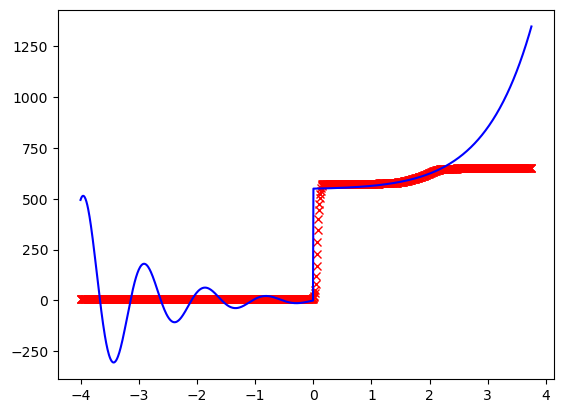

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.36309432900018146
